# Load Needed Packages

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jar
# jax.config.update('jax_platform_name', 'cuda')
import numpy as np
jax.config.update("jax_enable_x64", True)

from pandora import models, utils, GWBFunctions
from pandora import LikelihoodCalculator as LC

from enterprise_extensions import blocks
from enterprise.signals import signal_base, gp_signals
from enterprise.signals import gp_priors as gpp
from enterprise.signals import parameter
from enterprise_extensions.model_utils import get_tspan

import numpyro
from numpyro import distributions as dist
from numpyro import infer

import pickle, json, os, corner, glob, random, copy, time, inspect

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
plt.style.use('dark_background')
hist_settings = dict(
    bins = 40,
    histtype = 'step',
    lw = 3,
    density = True
)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/pandora/GWBFunctions.py:11: UserWarning: The package `interpax` is needed for spline interpolation of ORF.
  warnings.warn("The package `interpax` is needed for spline interpolation of ORF.")


Optional mpi4py package is not installed.  MPI support is not available.


/home/koonima/anaconda3/envs/pandora/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Choose a data set

In [2]:
datadir = '/home/koonima/FAST/Data/Pickle/'
with open(datadir + f'v1p1_de440_pint_bipm2019.pkl', 'rb') as fin:
    psrs = pickle.load(fin)
psrlist = [psr.name for psr in psrs]
with open(datadir + f'v1p1_all_dict.json', 'r') as fin:
    noise_dict = json.load(fin)
inc_ecorr = True
backend = 'backend'
tnequad = False

libstempo not installed. PINT or libstempo are required to use par and tim files.


## Frequency-bins

In [3]:
Tspan = get_tspan(psrs) # The time-span of the entire PTA
crn_bins = 30 # number of frequency-bins for the GWB
int_bins = 30 # number of frequency-bins for the non-GWB (IRN) red noise
assert int_bins >= crn_bins
f_intrin = jnp.arange(1/Tspan, (int_bins + 0.01)/Tspan, 1/Tspan) # an array of frequency-bins for the IRN process
f_common = f_intrin[:crn_bins] # an array of frequency-bins for the common process

# Building the Run in `enteprise`

In [4]:
log10_Agw = parameter.Uniform(-18., -11.)('gw_log10A')
gamma_gw = parameter.Uniform(0., 7.)('gw_gamma')
delta_gw = parameter.Constant(0.)('gw_delta')
kappa_gw = parameter.Constant(0.1)('gw_kappa')
log10_fb_gw = parameter.Uniform(-8.7, -7.)('gw_fbend')
cpl = gpp.broken_powerlaw(log10_A=log10_Agw,
                            gamma=gamma_gw,
                            delta=delta_gw,
                            log10_fb=log10_fb_gw,
                            kappa=kappa_gw)

In [ ]:
tm = gp_signals.MarginalizingTimingModel(use_svd=True)
wn = blocks.white_noise_block(
    vary=False,
    inc_ecorr=True,
    gp_ecorr=False,
    select='backend',
    tnequad=tnequad,
)
rn = blocks.red_noise_block(
    psd="powerlaw",
    prior="log-uniform",
    Tspan=Tspan,
    components=int_bins,
    gamma_val=None,
)
gwb = gp_signals.FourierBasisGP(cpl, coefficients=False, combine=True,
                                        components=crn_bins, Tspan=Tspan,
                                        name='gw', pshift=None, pseed=None)

s = tm + wn + rn + gwb

pta = signal_base.PTA(
    [s(p) for p in psrs], signal_base.LogLikelihoodDenseCholesky
)
pta.set_default_params(noise_dict)

Package `fastshermanmorrison` not installed. Fallback to sherman-morrison


In [7]:
pta.params

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1937+21_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1937+21_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1953+29_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1953+29_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0023+0923_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0023+0923_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0030+0451_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0340+4130_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0340+4130_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0406+3039_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0406+3039_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0437-4715_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0437-4715_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0509+0856_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0509+0856_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J05

## To save on GPU memory, save `TNT` and `TNr`

In [9]:
# np.save('./TNT.npy', np.array(pta.get_TNT(params={})))
# np.save('./TNr.npy', np.array(pta.get_TNr(params={}))[..., None])

# Building the Run in `pandora`

In [10]:
chosen_psd_model, chosen_orf_model, gwb_helper_dictionary = utils.broken_pl(renorm_const = 1, 
                                                                                        lower_amp=-18.0, upper_amp=-11.0, 
                                                                                        lower_gamma = 0., upper_gamma = 7.,
                                                                                        lower_log10_fb = -8.7, upper_log10_fb = -7.)
gwb_helper_dictionary

{'ordered_gwb_psd_model_params': array(['log10_A', 'gamma', 'delta', 'log10_fb', 'kappa'], dtype='<U8'),
 'fixed_gwb_psd_params': ['delta', 'kappa'],
 'varied_gwb_psd_params': [np.str_('log10_A'),
  np.str_('gamma'),
  np.str_('log10_fb')],
 'gwb_psd_param_lower_lim': Array([-18. ,   0. ,  -8.7], dtype=float64),
 'gwb_psd_param_upper_lim': Array([-11.,   7.,  -7.], dtype=float64),
 'fixed_gwb_psd_param_indices': Array([2, 4], dtype=int64),
 'fixed_gwb_psd_param_values': Array([0. , 0.1], dtype=float64)}

In [22]:
pnames = [pname for pname in pta.param_names[:2 * len(psrs)]]
[pnames.append('gw_' + str(_)) for _ in gwb_helper_dictionary['varied_gwb_psd_params']]
pnames

['B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'B1937+21_red_noise_gamma',
 'B1937+21_red_noise_log10_A',
 'B1953+29_red_noise_gamma',
 'B1953+29_red_noise_log10_A',
 'J0023+0923_red_noise_gamma',
 'J0023+0923_red_noise_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'J0340+4130_red_noise_gamma',
 'J0340+4130_red_noise_log10_A',
 'J0406+3039_red_noise_gamma',
 'J0406+3039_red_noise_log10_A',
 'J0437-4715_red_noise_gamma',
 'J0437-4715_red_noise_log10_A',
 'J0509+0856_red_noise_gamma',
 'J0509+0856_red_noise_log10_A',
 'J0557+1551_red_noise_gamma',
 'J0557+1551_red_noise_log10_A',
 'J0605+3757_red_noise_gamma',
 'J0605+3757_red_noise_log10_A',
 'J0610-2100_red_noise_gamma',
 'J0610-2100_red_noise_log10_A',
 'J0613-0200_red_noise_gamma',
 'J0613-0200_red_noise_log10_A',
 'J0636+5128_red_noise_gamma',
 'J0636+5128_red_noise_log10_A',
 'J0645+5158_red_noise_gamma',
 'J0645+5158_red_noise_log10_A',
 'J0709+0458_red_noise_gamma',
 'J0709+0458_red_nois

In [23]:
# save paramter list
with open(os.path.join('./', "pars.txt"), "w") as fout:
    for pname in pnames:
        fout.write(pname + "\n")

### Now, construct the model using `models.UniformPrior`

In [12]:
o = models.UniformPrior(gwb_psd_func = chosen_psd_model,
                orf_func = chosen_orf_model,
                crn_bins = crn_bins,
                int_bins = int_bins,
                f_common = f_common, 
                f_intrin = f_intrin,
                df = 1/Tspan,
                Tspan = Tspan, 
                Npulsars = len(psrs),
                psr_pos = [psr.pos for psr in psrs],
                gwb_helper_dictionary = gwb_helper_dictionary,
                gamma_min = 0,
                gamma_max = 7,
                log10A_min = -20 + 0.5,
                log10A_max = -11 + 0.5,
                renorm_const = 1)

In [ ]:
m  = LC.CURN(psrs = psrs,
            device_to_run_likelihood_on = 'cuda',
            TNr = jnp.load('./TNr.npy', mmap_mode = 'r'),
            TNT = jnp.load('./TNT.npy', mmap_mode = 'r'),
            run_type_object = o,
            noise_dict = None, 
            backend = None, 
            tnequad = False, 
            inc_ecorr = True, 
            del_pta_after_init = True,
            matrix_stabilization = False)

In [19]:
x0 = o.make_initial_guess(key = jar.key(100)) # Some random draw from the prior given an RNG key

# Likelihood Comparison

In [22]:
def lnlike_offset(params):
    likelihood_adjust = 0
    likelihood_adjust += -0.5 * np.sum([ell for ell in pta.get_rNr_logdet(params)])
    likelihood_adjust += sum(pta.get_logsignalprior(params))
    return likelihood_adjust
params = pta.map_params(y0)
ln_offset = lnlike_offset(params)

In [77]:
for _ in np.arange(1, 10, 1, dtype = int):
    x0 = o.make_initial_guess(key = jar.key(_))
    y0 = np.array(x0)
    y0[-1] = x0[134] 
    y0[134] = x0[-1] 
    print(_, m.get_lnliklihood(x0), pta.get_lnlikelihood(y0) - ln_offset)

1 45201.774287167216 45196.43237105105
2 45011.57153127397 45011.571531274356
3 45330.97268528157 45330.972685412504
4 46330.11836529024 46330.11836528778
5 45748.42853141046 45748.42853142042
6 45400.540849854624 45400.540849900804
7 4190.624171156423 4003.8928829701617
8 42125.58930972323 42125.58930972498
9 45630.1213770102 45630.12137701083


## Surprised by the difference? Take a look!

In [91]:
x = jar.normal(key = jar.key(101), shape = (2, 2, 2))
# x = x @ x.transpose((0, 2 ,1)) + 1 * jnp.repeat(jnp.eye(x.shape[0])[None], 2, axis =0)
x = x @ x.T + 1 * jnp.repeat(jnp.eye(x.shape[0])[None], 2, axis =0)
print(jnp.linalg.cholesky(x))
print('**********')
print(np.linalg.cholesky(x))

[[[ 1.59301095  0.        ]
  [-0.55096064  0.98819403]]

 [[ 2.04754109  0.        ]
  [-0.0396215   0.94478896]]]
**********
[[[ 1.59301095  0.        ]
  [-0.18807613  1.11566681]]

 [[ 2.04754109  0.        ]
  [ 0.25620108  0.91025109]]]


In [76]:
%timeit o.get_phi_mat(x0); m.get_lnliklihood(x0)

550 μs ± 16.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## `PANDORA` sampling

In [47]:
m.sample(x0 = np.array(x0), niter = int(1e6), savedir = './testnew/', 
         resume=False, 
         sample_enterprise = False)

Finished 1.00 percent in 19.310385 s Acceptance rate = 0.379811Adding DE jump with weight 50
Finished 94.30 percent in 1622.043531 s Acceptance rate = 0.349406

KeyboardInterrupt: 

# numpyro NUTS Sampler

In [17]:
ll = jnp.array(m.lower_prior_lim_all)
ul = jnp.array(m.upper_prior_lim_all)

In [18]:
def model():
    xs = numpyro.sample("xs", dist.Uniform(low = ll, 
                                           high = ul))
    numpyro.factor("ll", m.get_lnliklihood(xs))

In [40]:
infer_object = infer.MCMC(
    infer.NUTS(model),
    num_warmup=250,
    num_samples=4096,
    num_chains=4,
    progress_bar=True,
    chain_method='vectorized',
)

In [41]:
infer_object.run(jax.random.key(100))

sample: 100%|██████████| 4346/4346 [26:47<00:00,  2.70it/s] 


In [42]:
samps = infer_object.get_samples()['xs']

In [43]:
samps.shape

(16384, 137)

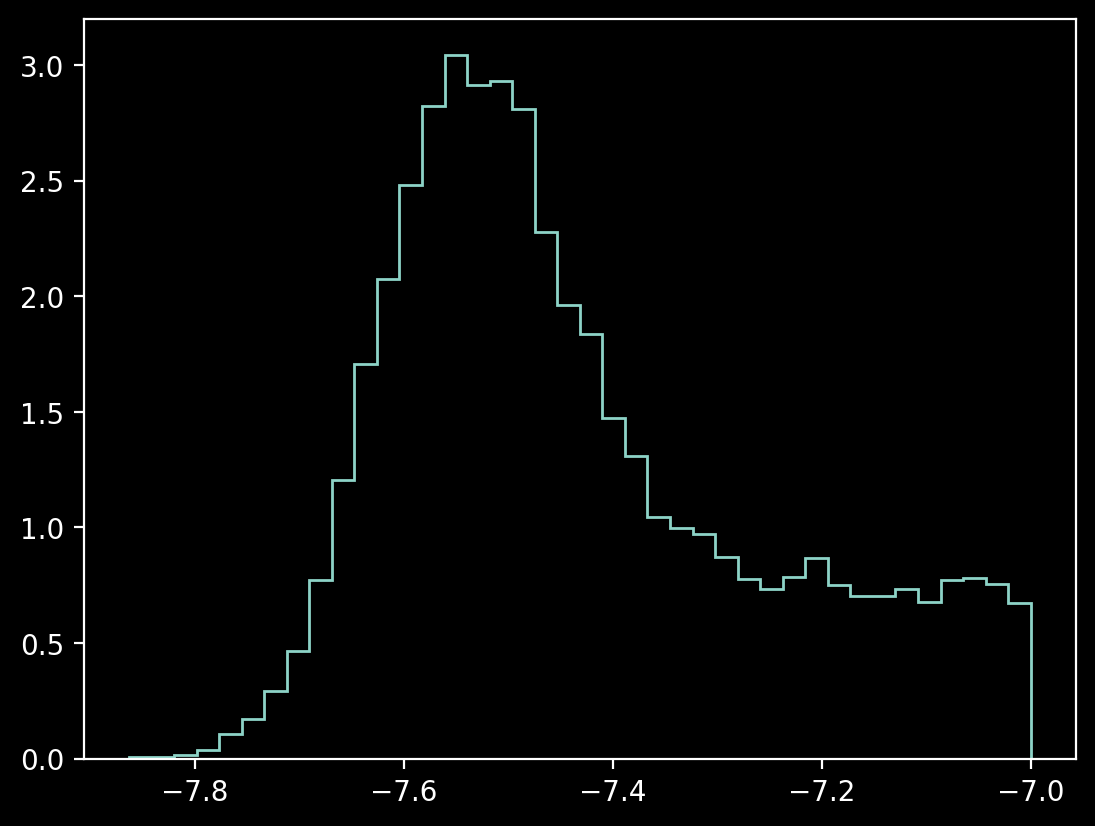

In [44]:
plt.hist(samps[:, 136], **hist_settings)
plt.show()

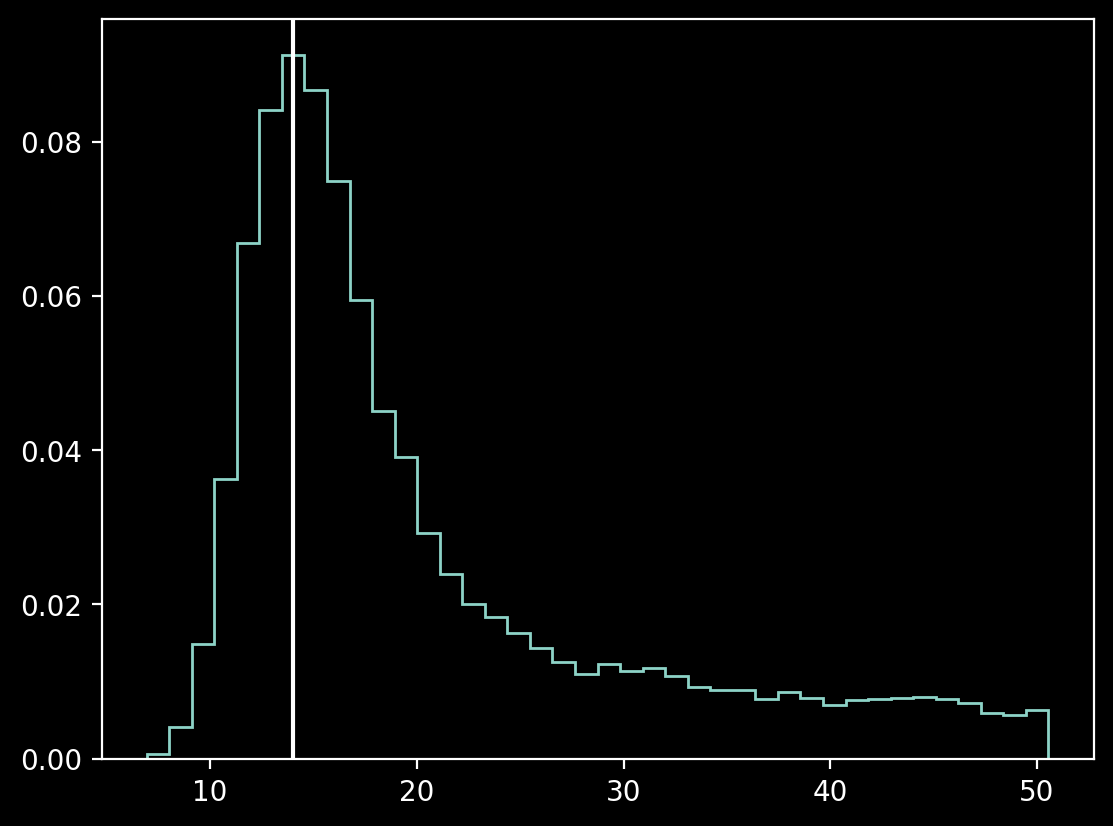

In [ ]:
plt.hist(Tspan * 10**(samps[:, 136]) , **hist_settings)
plt.axvline(14)
plt.show()

In [78]:
jnp.mean(Tspan * 10**(samps[:, 136]))

Array(20.47331092, dtype=float64)

In [59]:
infer_object.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     xs[0]      3.98      1.24      3.94      2.15      6.27   4446.13      1.00
     xs[1]    -14.58      1.23    -14.18    -16.07    -13.32    633.85      1.01
     xs[2]      4.17      0.39      4.15      3.54      4.82   9326.18      1.00
     xs[3]    -13.62      0.11    -13.61    -13.80    -13.45  10437.17      1.00
     xs[4]      2.32      1.04      2.22      0.66      4.02   8007.33      1.00
     xs[5]    -12.93      0.26    -12.89    -13.34    -12.54   8290.78      1.00
     xs[6]      3.11      2.01      2.89      0.00      6.05  15697.17      1.00
     xs[7]    -16.75      1.94    -16.85    -19.98    -13.91   8627.64      1.00
     xs[8]      4.39      1.66      4.61      1.88      7.00   6176.53      1.00
     xs[9]    -15.54      1.58    -15.00    -18.44    -13.67   2046.89      1.00
    xs[10]      3.30      2.01      3.20      0.00      6.20  16250.74      1.00
    xs[11]    -16.96      1

In [56]:
samps[:, 0:1].shape

(16384, 1)

In [58]:
numpyro.diagnostics.effective_sample_size(samps[:, 1:2].T)

np.float64(650.494570513177)

In [48]:
chain = np.loadtxt('./testnew/chain_1.txt')
chain = chain[int(0.25 * chain.shape[0]):, :-4]
chain.shape

(70726, 137)

In [68]:
# numpyro.diagnostics.effective_sample_size(samps[:, -2:-1].T)

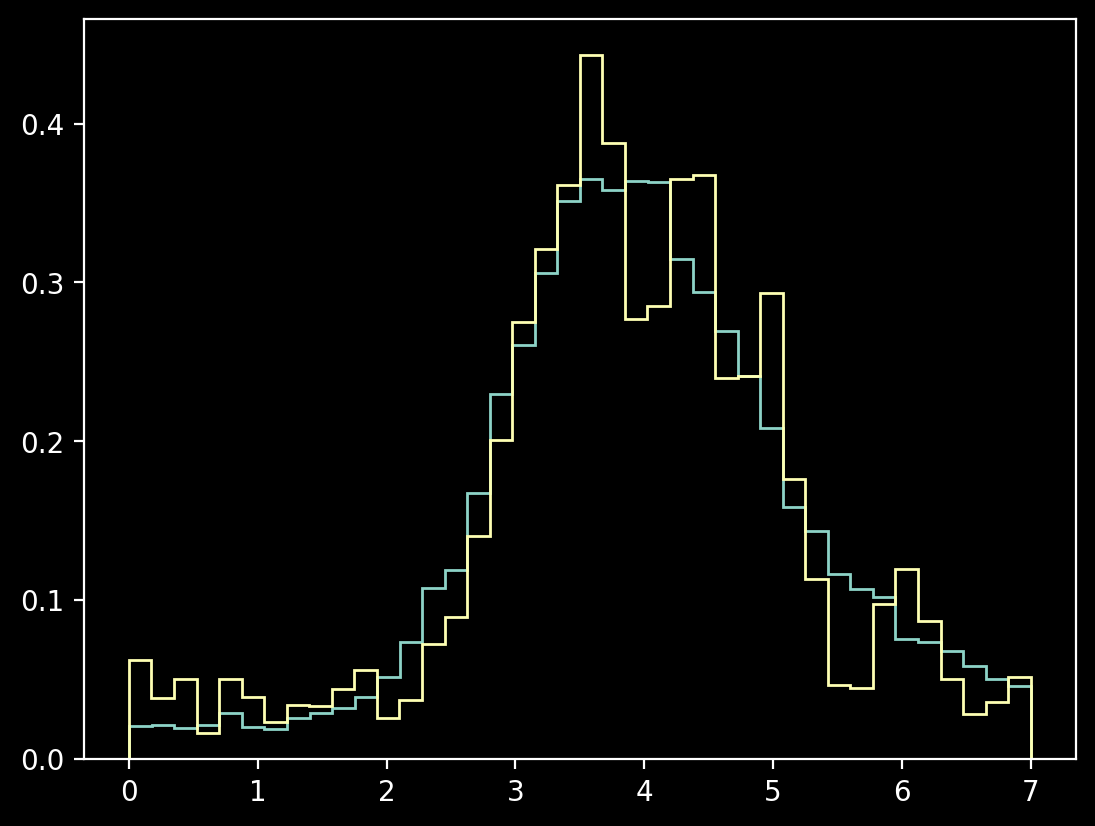

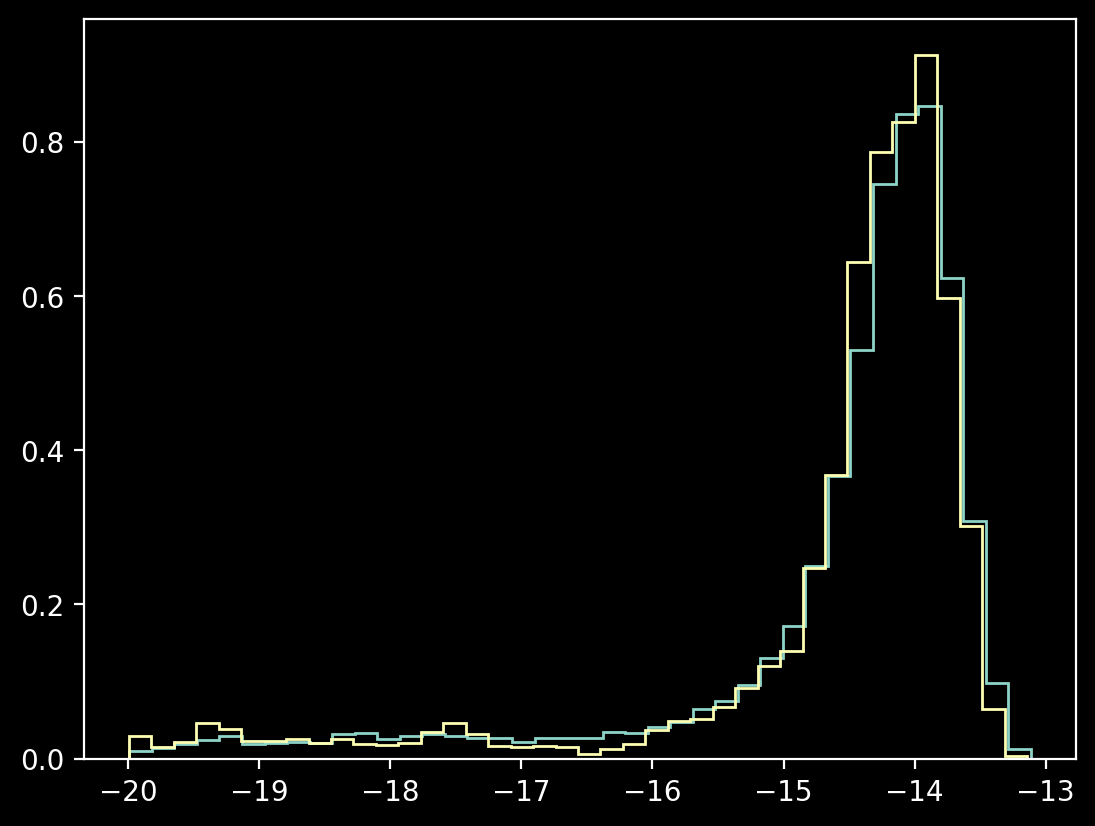

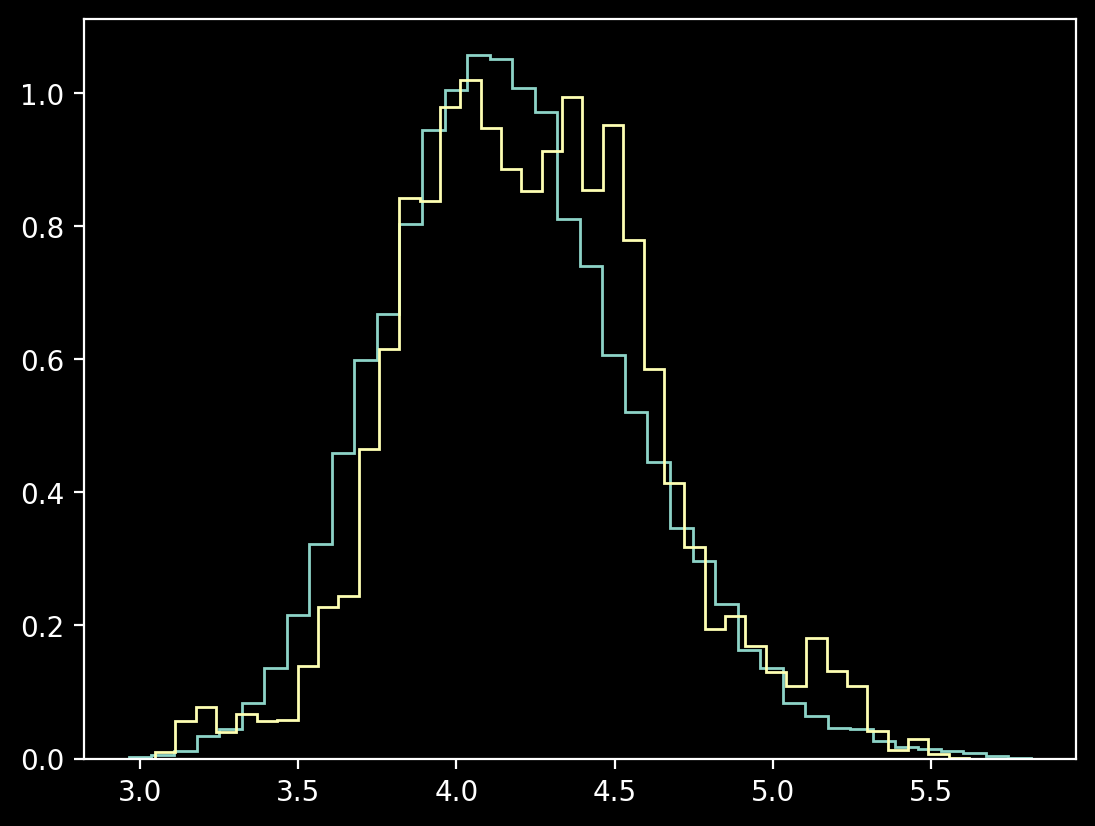

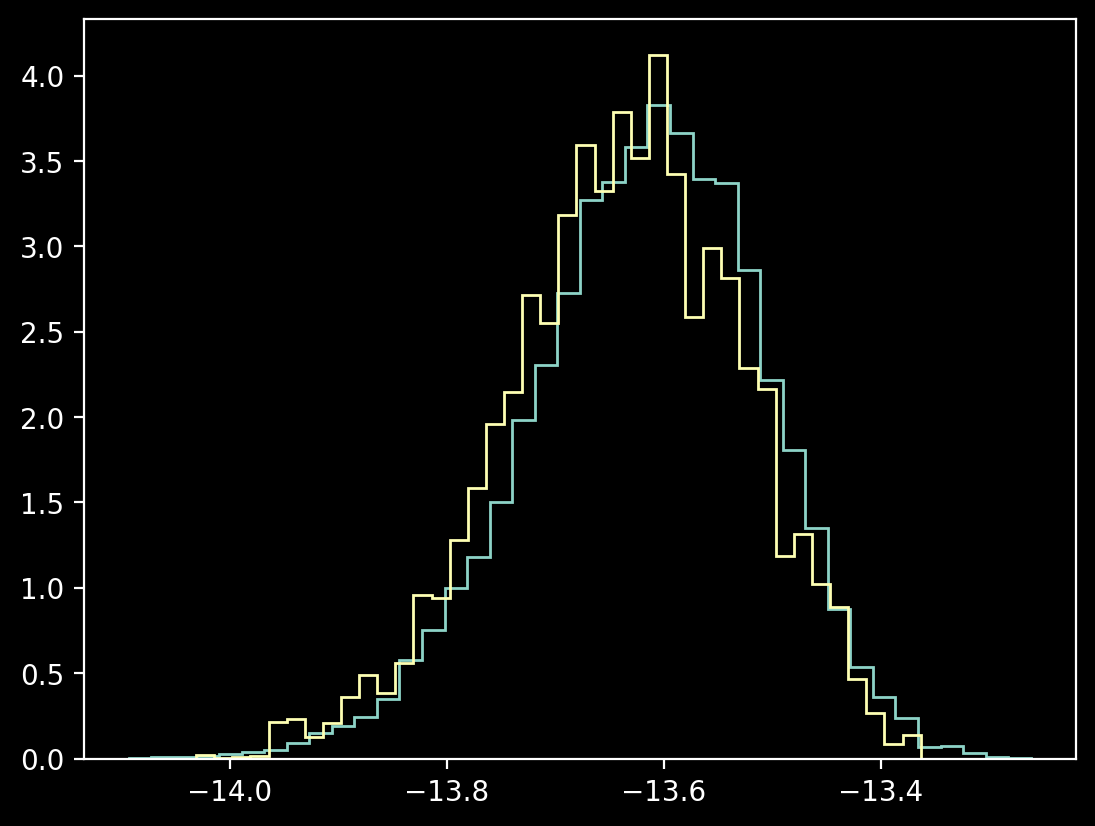

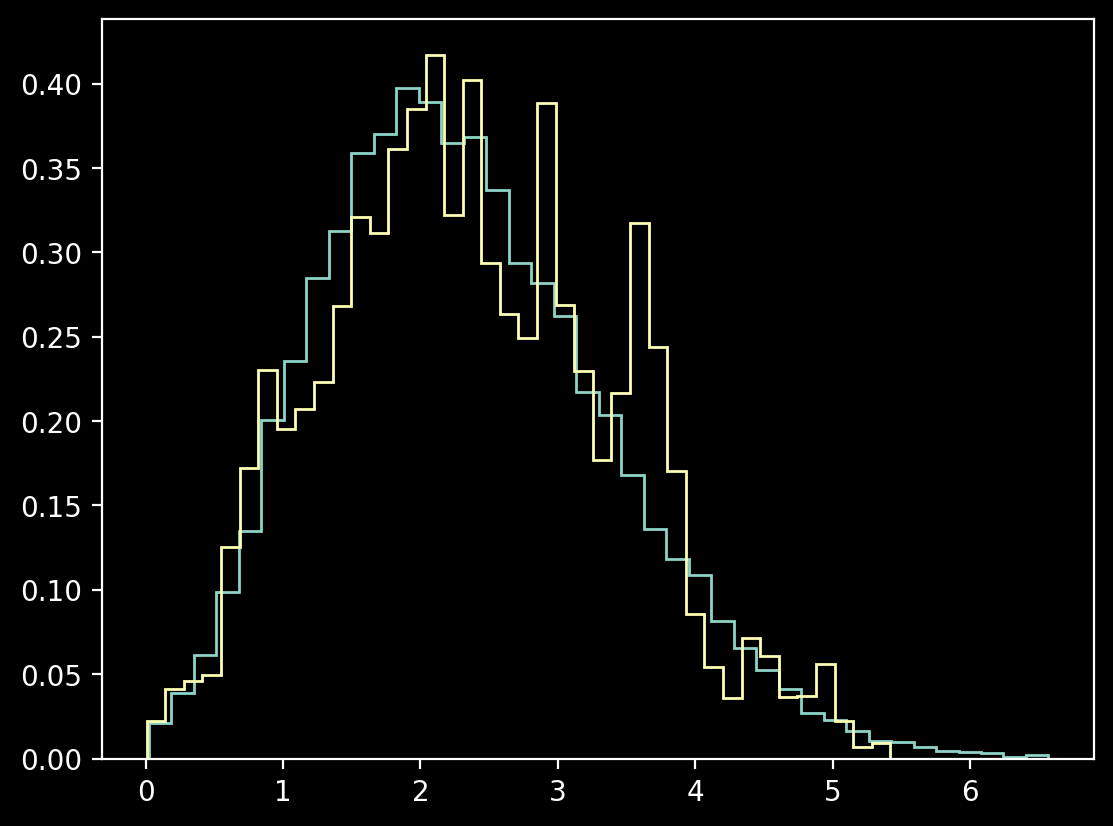

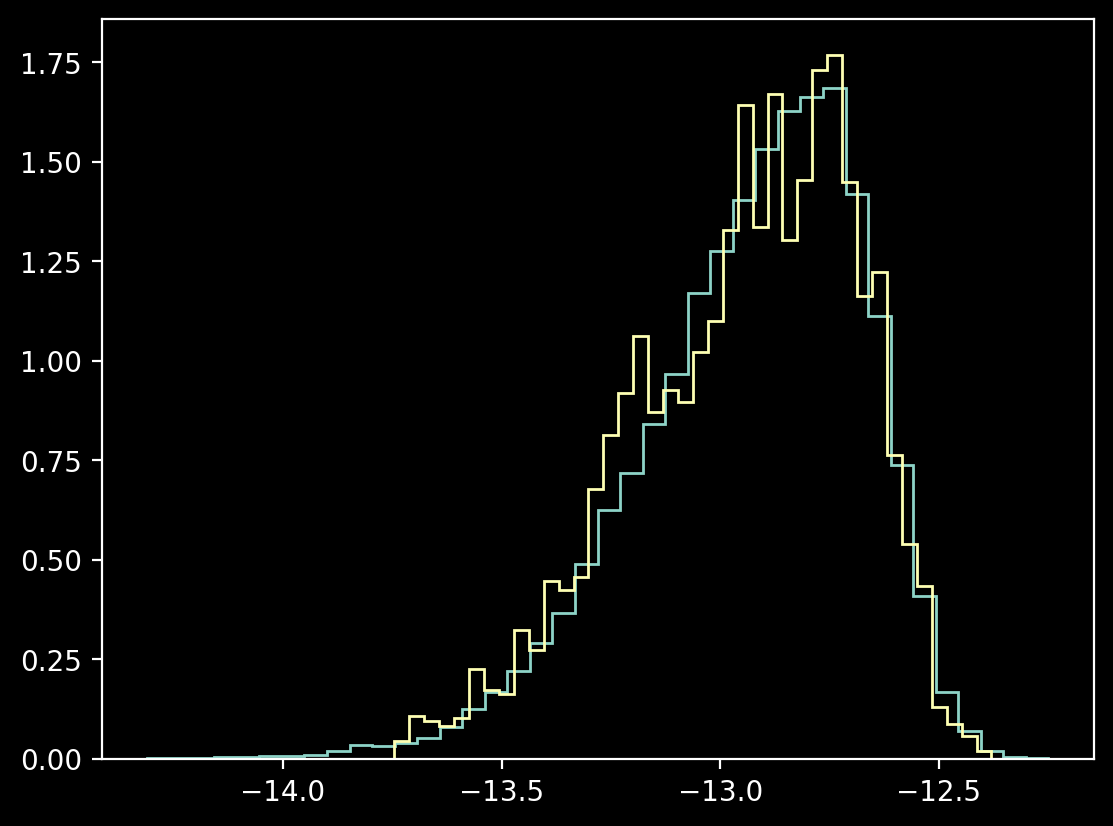

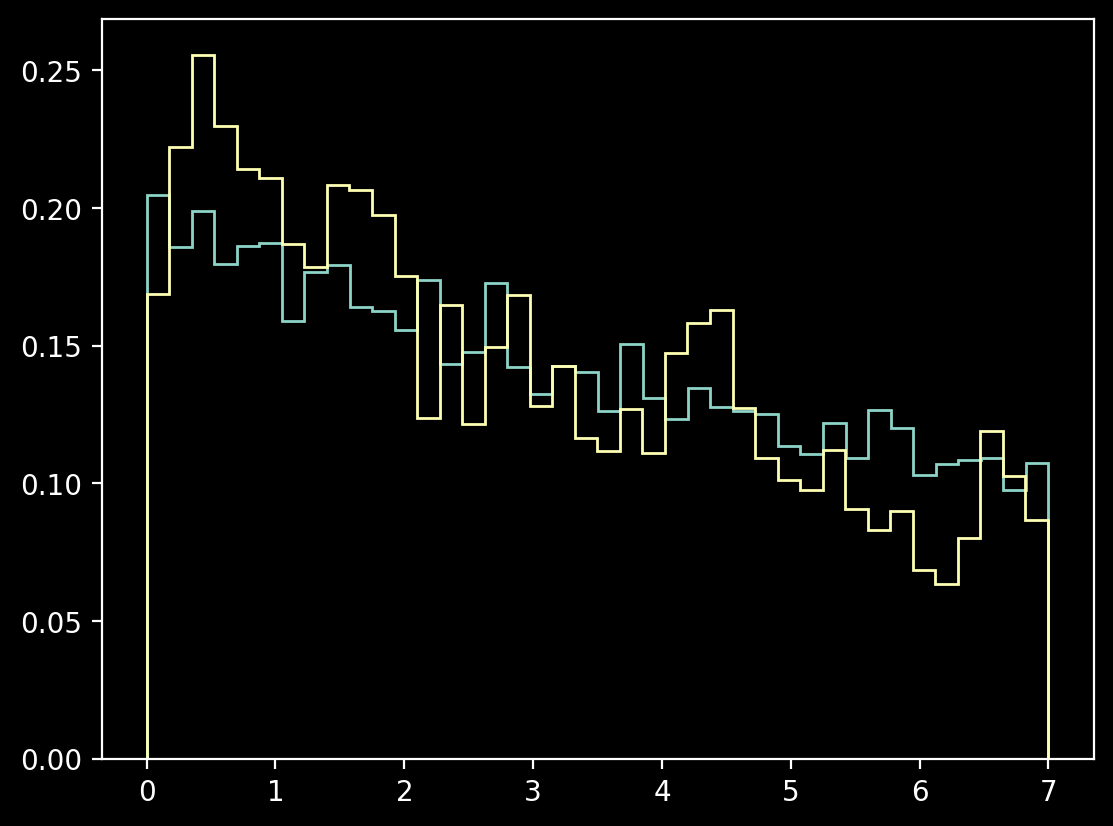

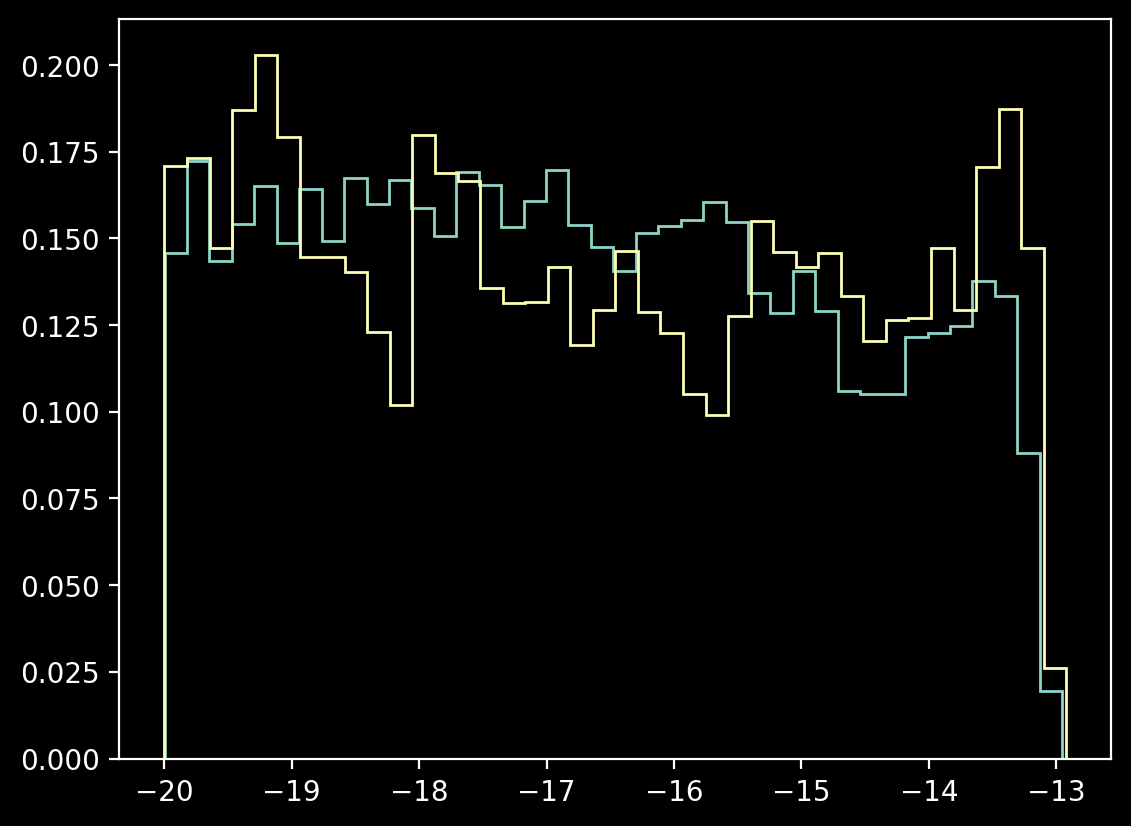

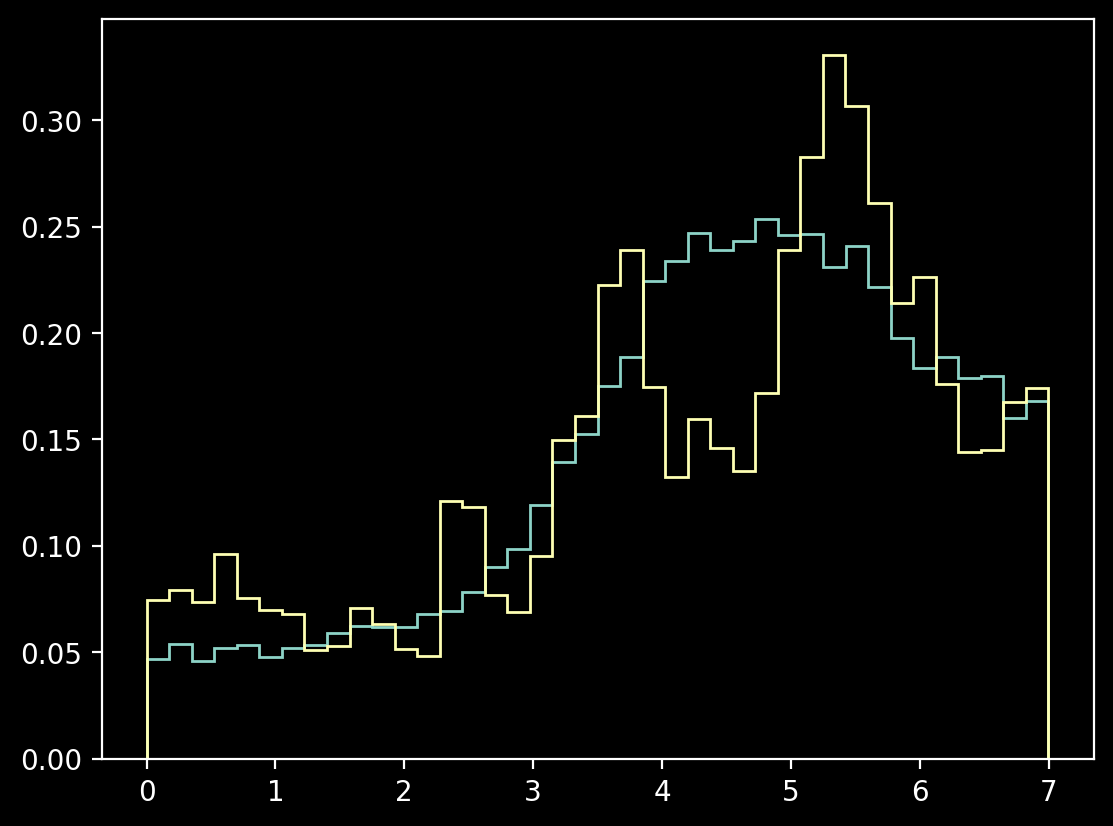

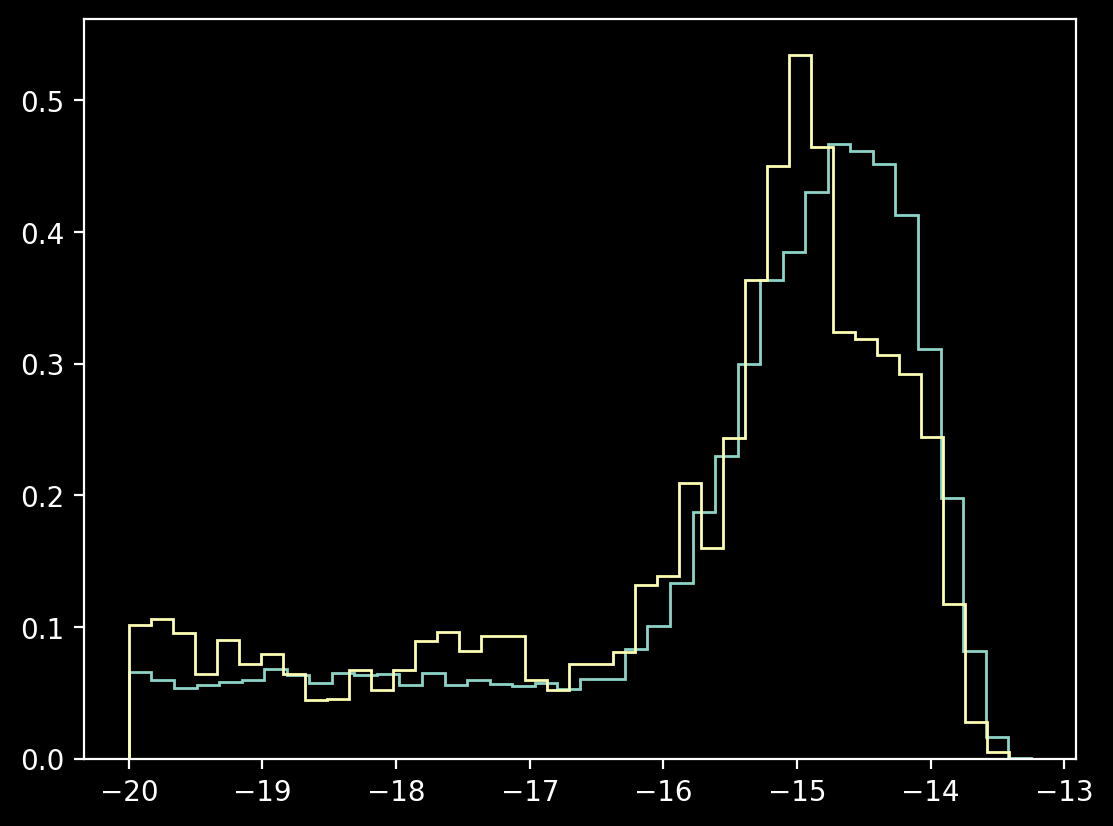

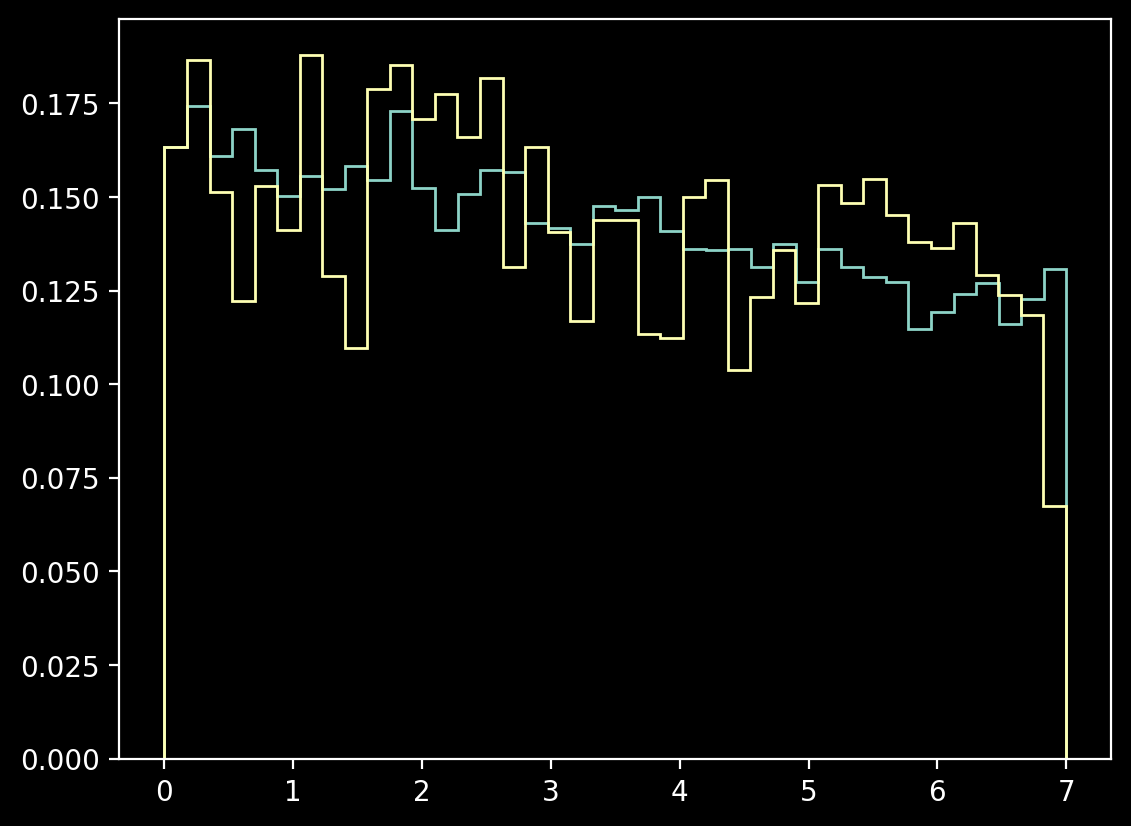

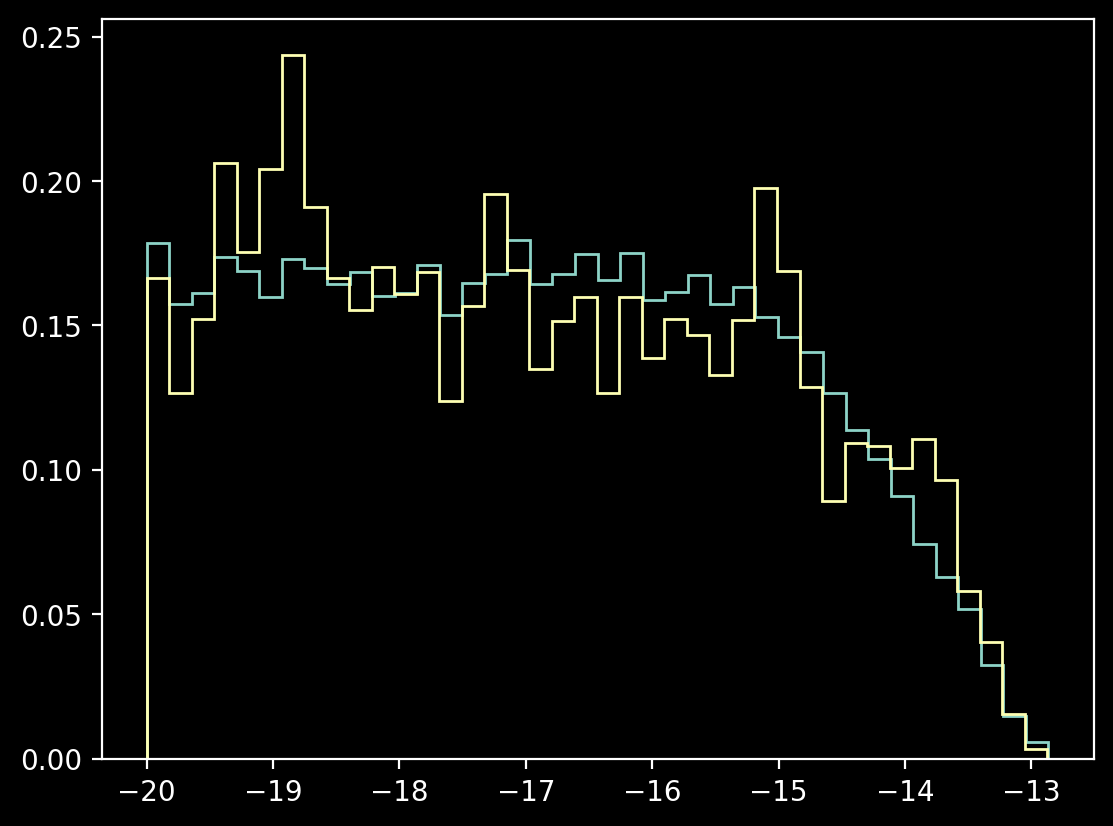

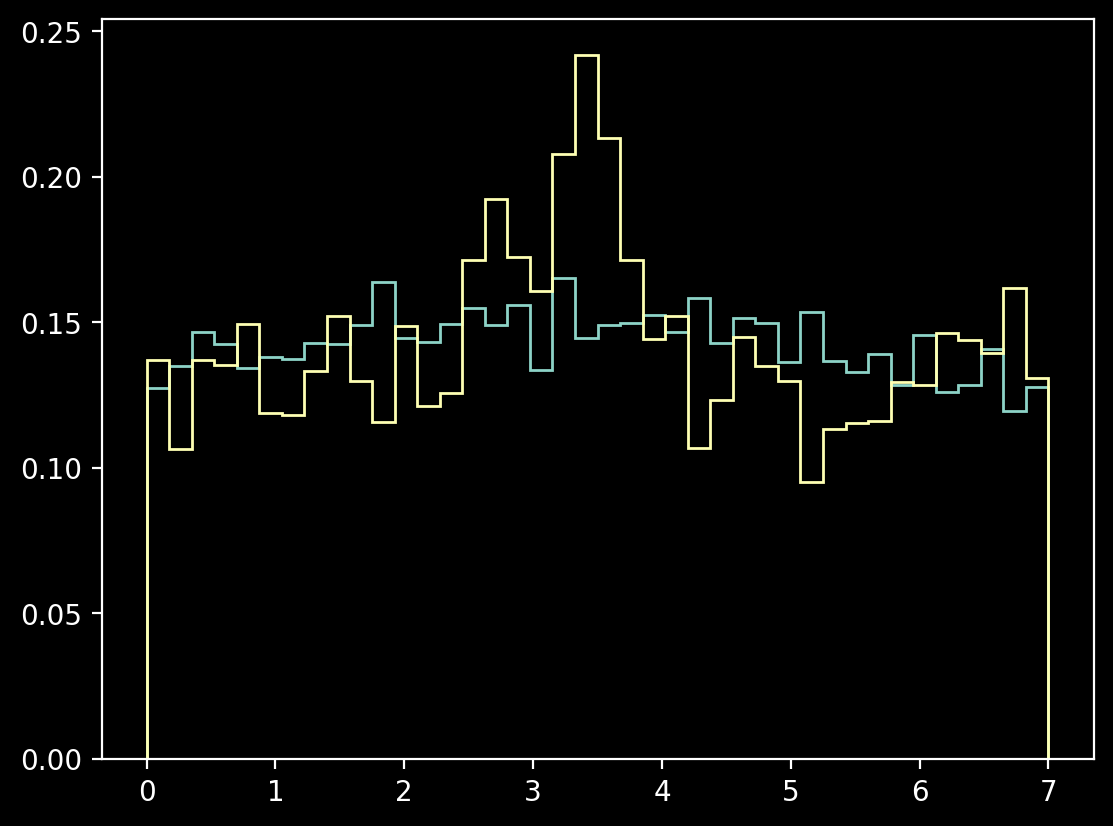

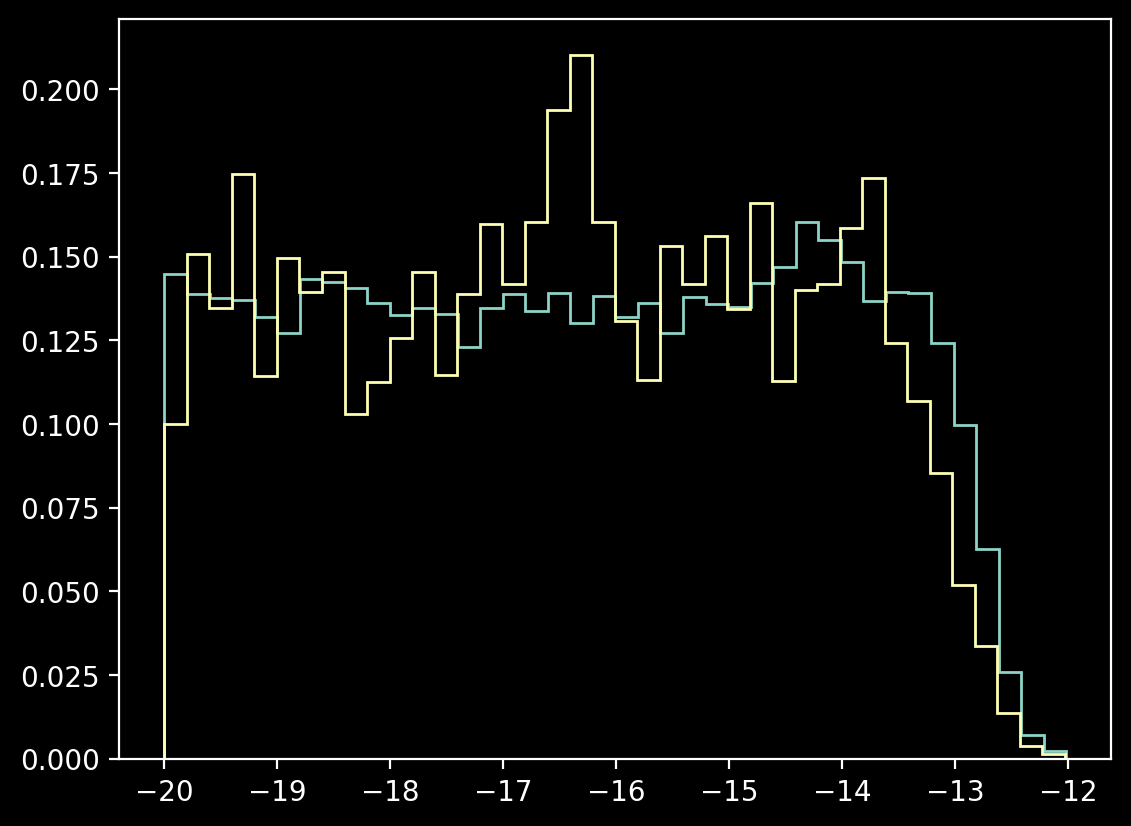

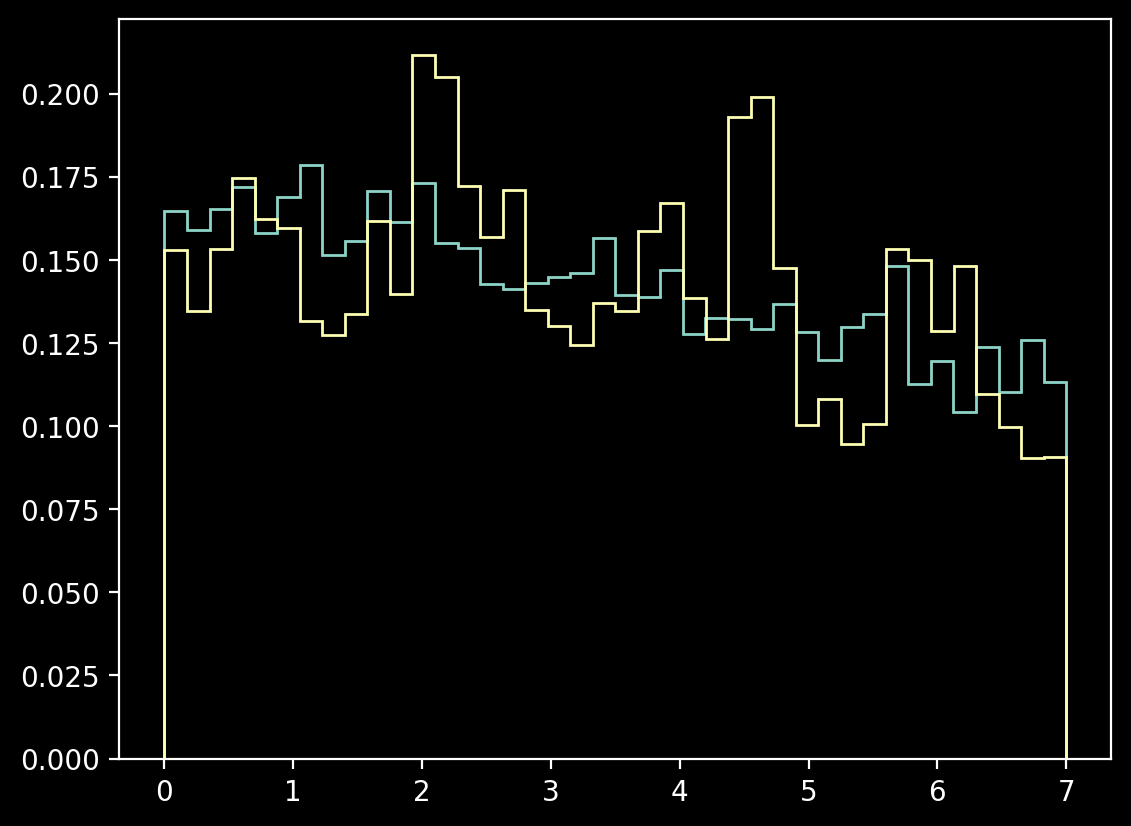

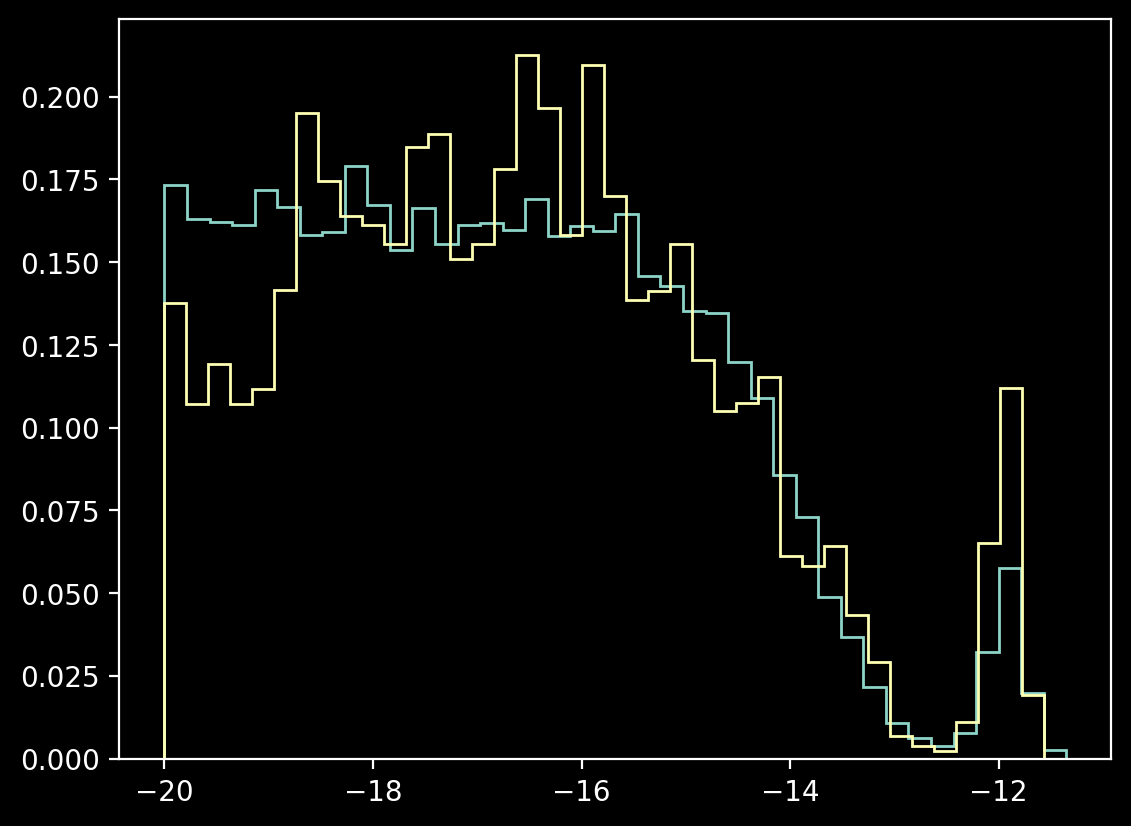

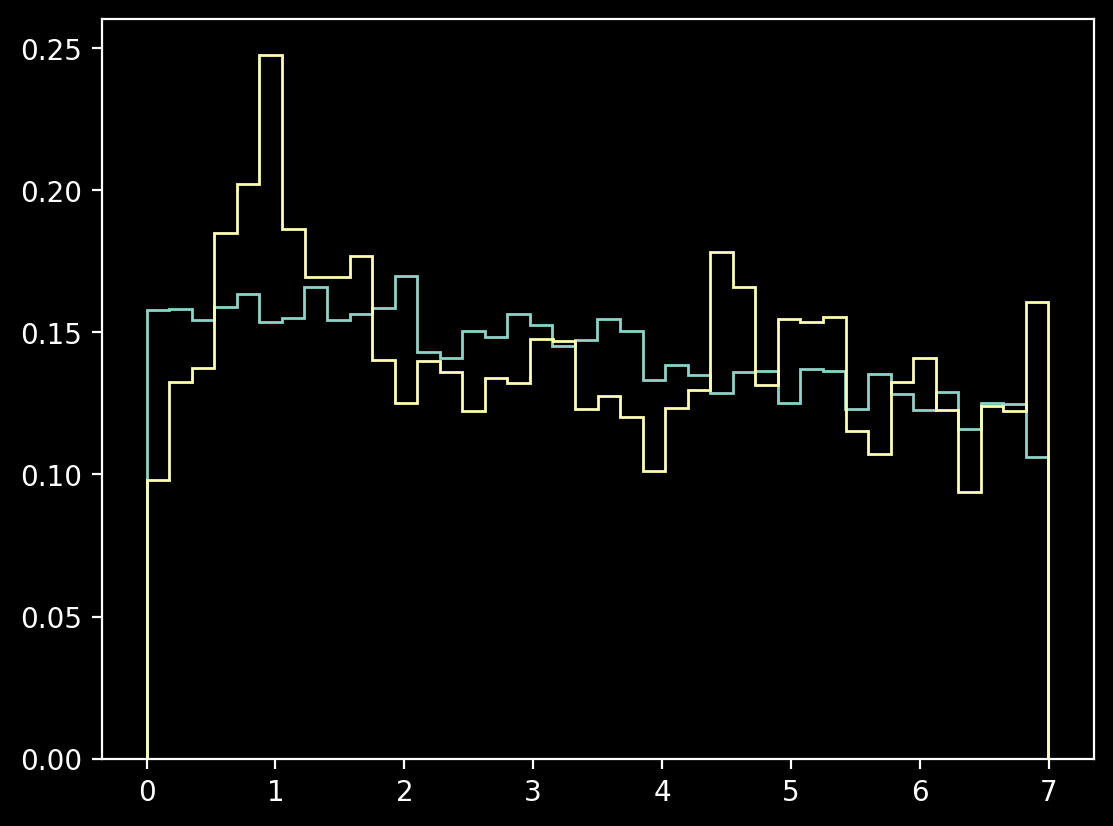

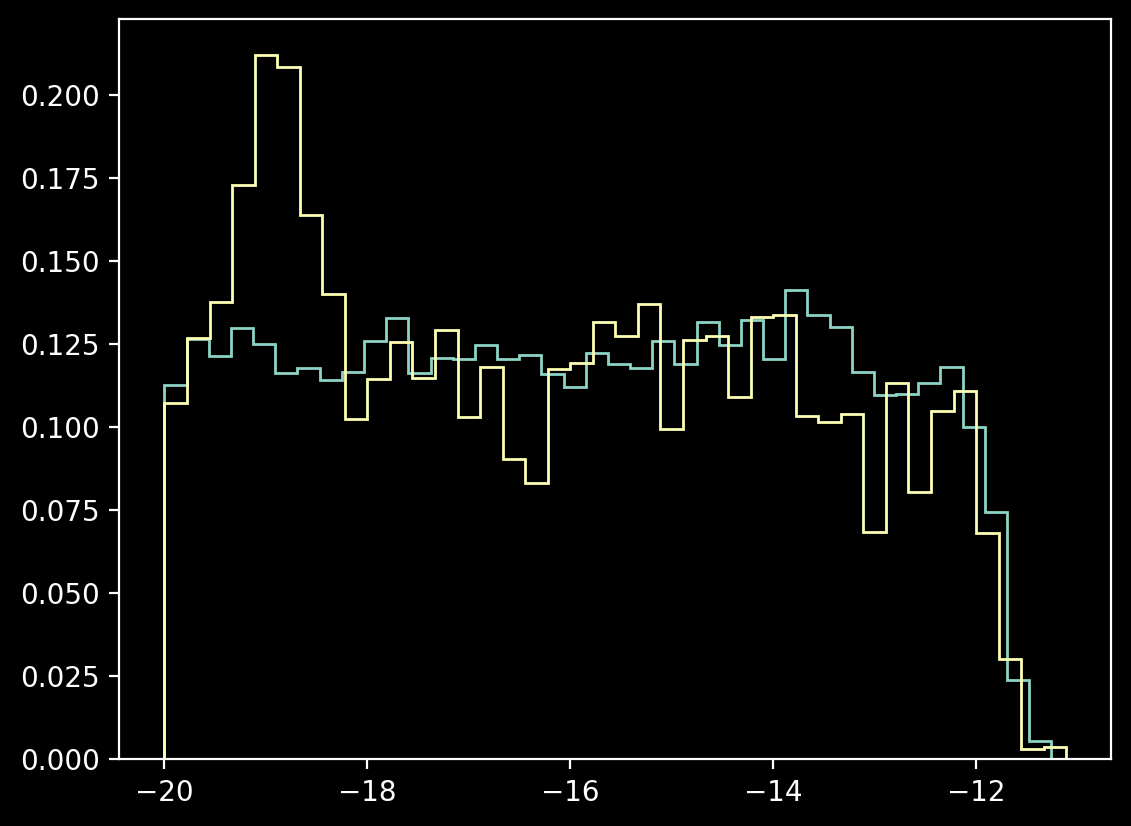

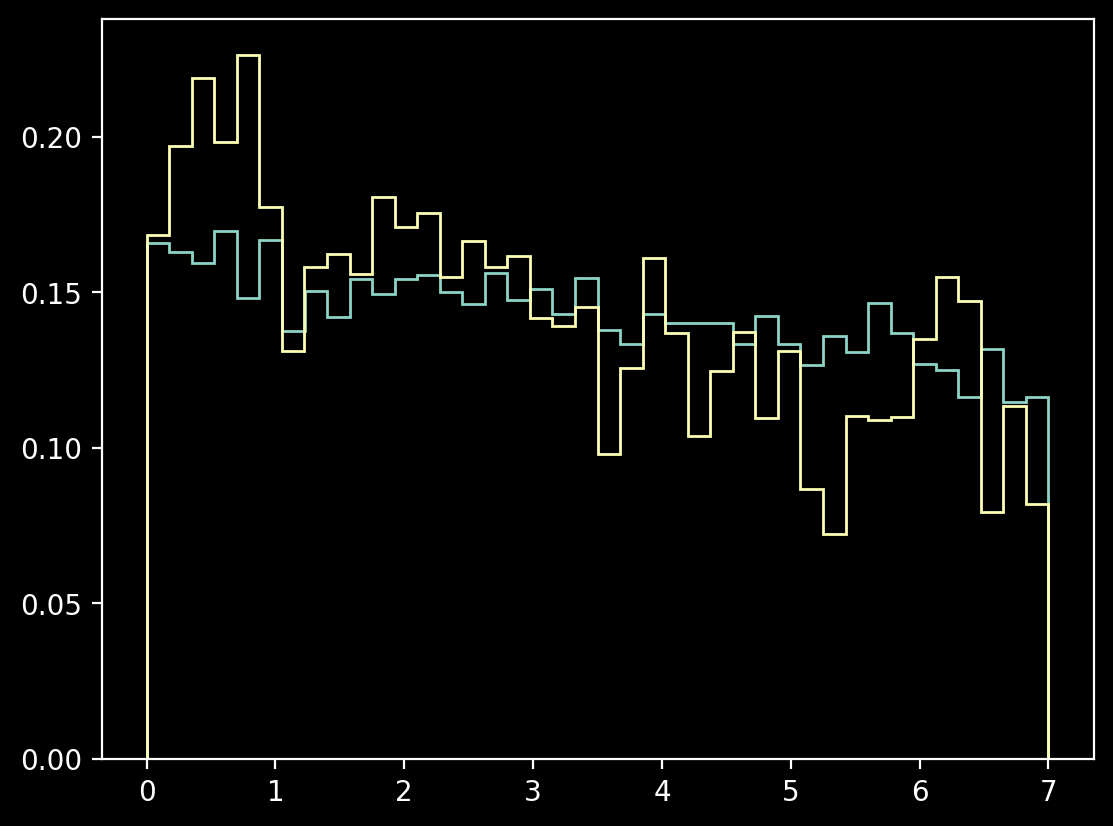

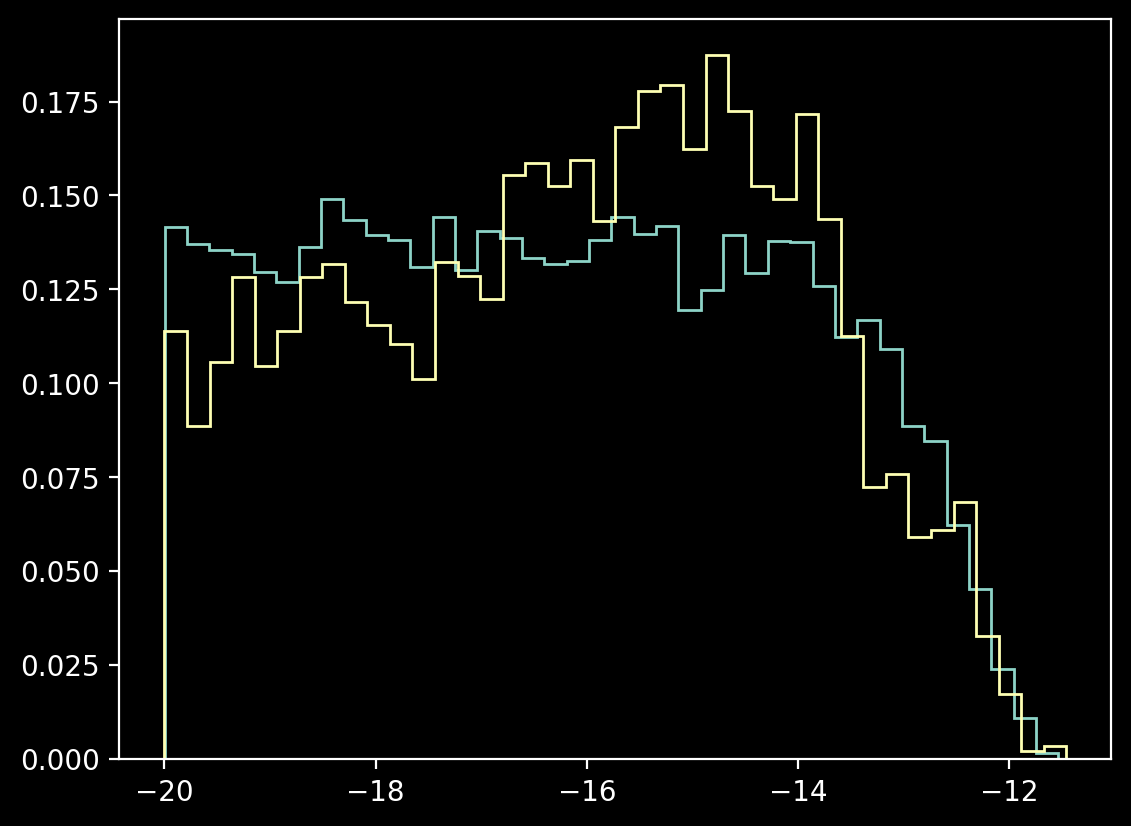

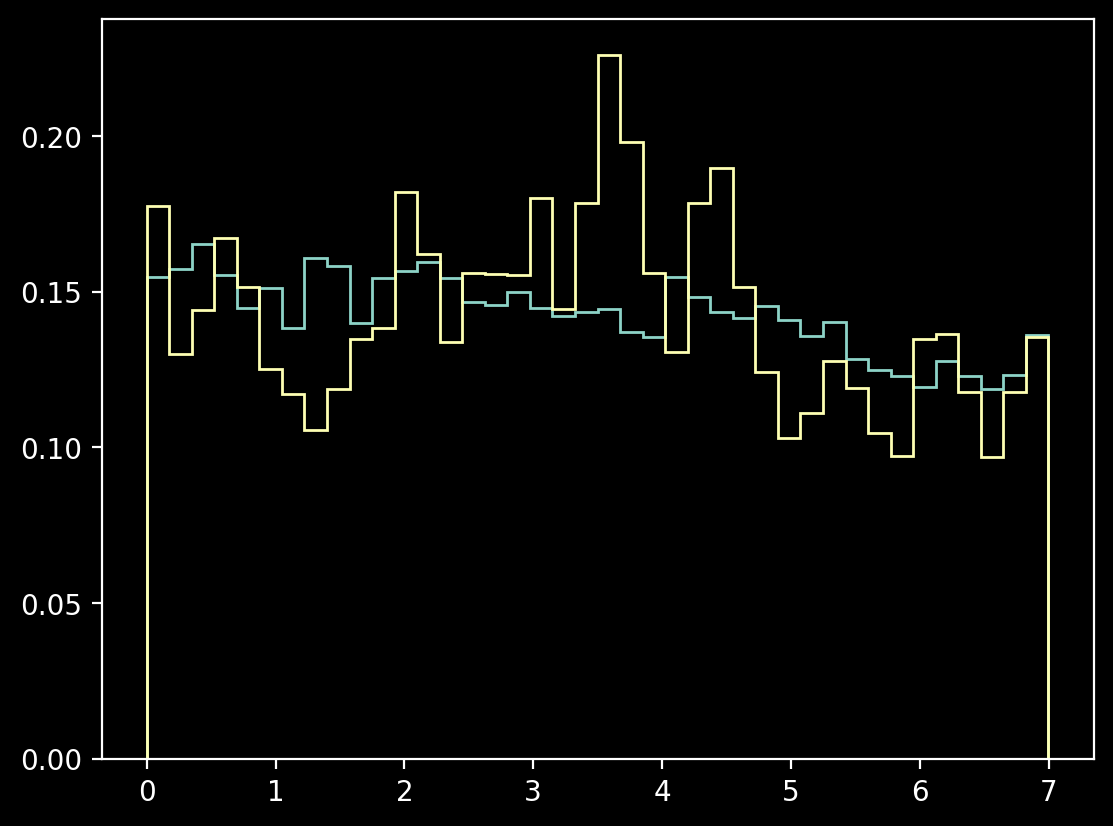

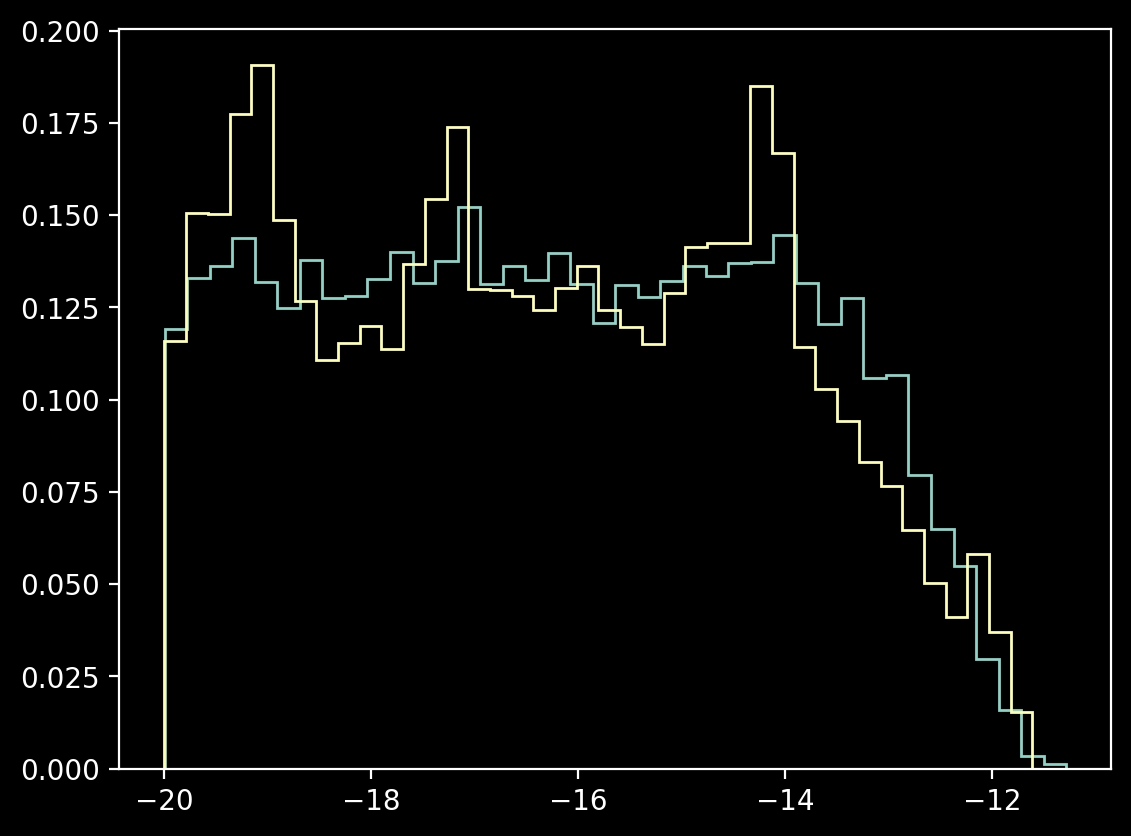

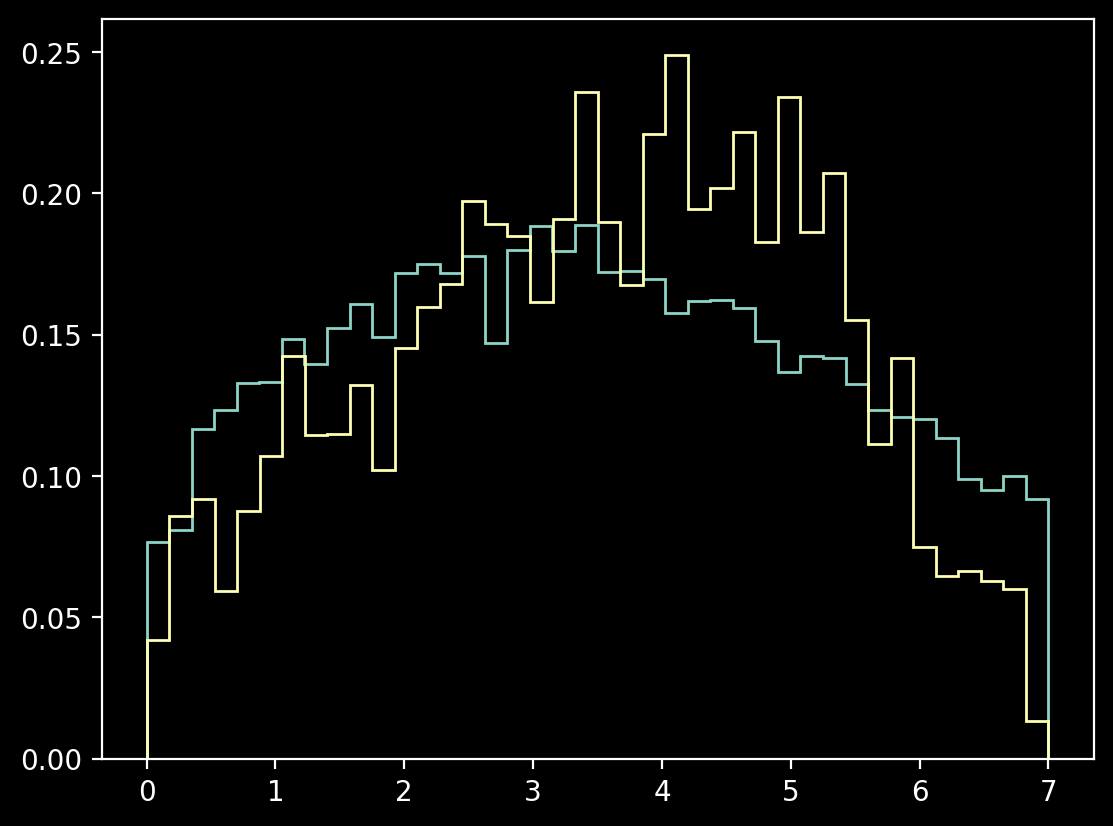

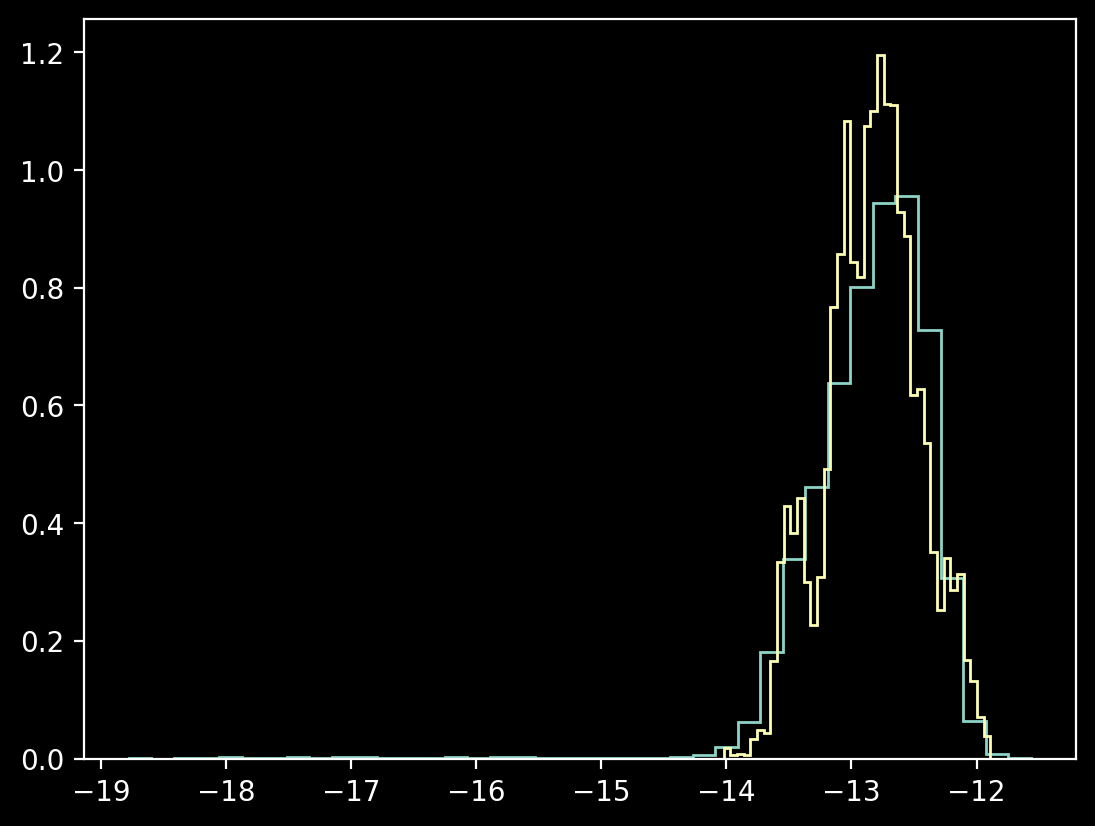

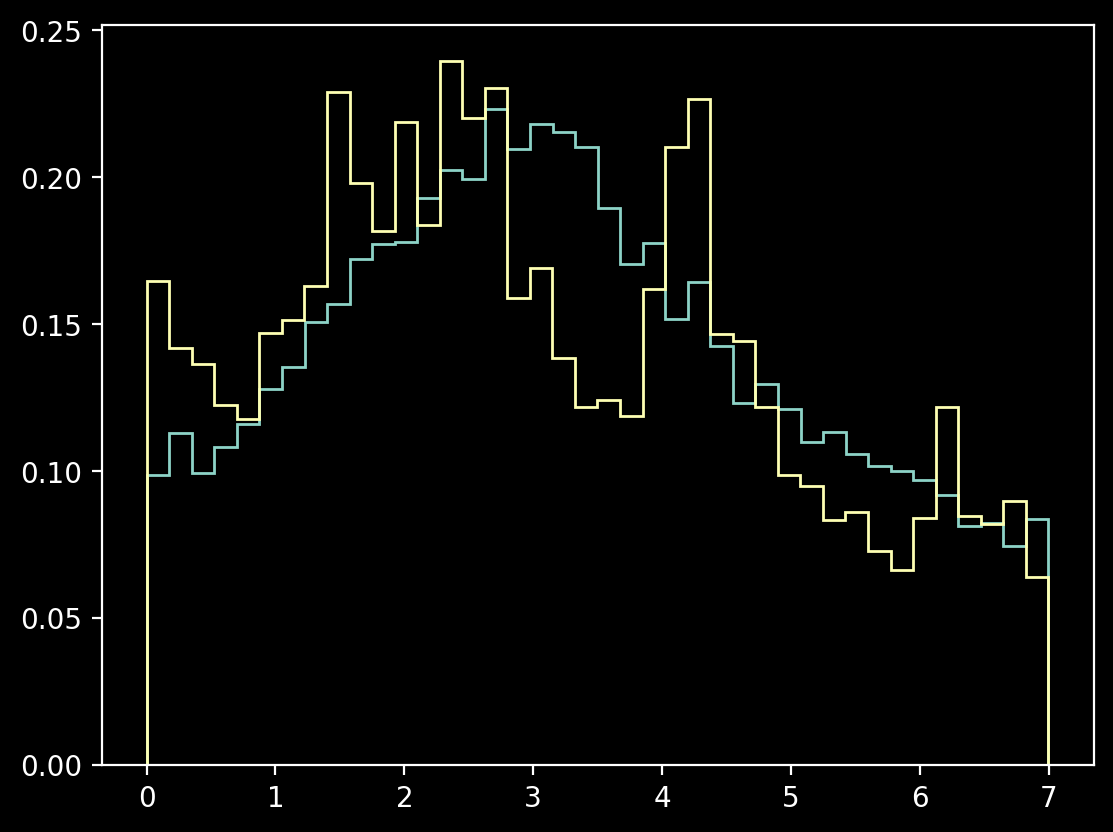

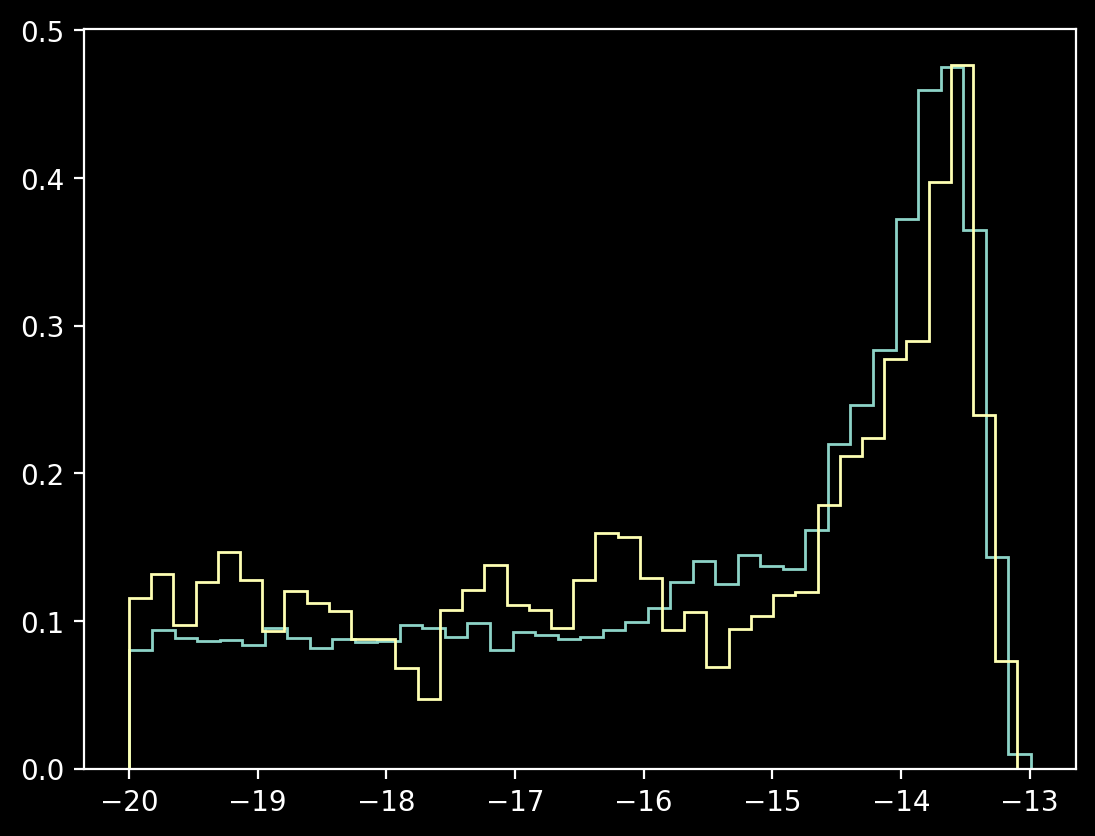

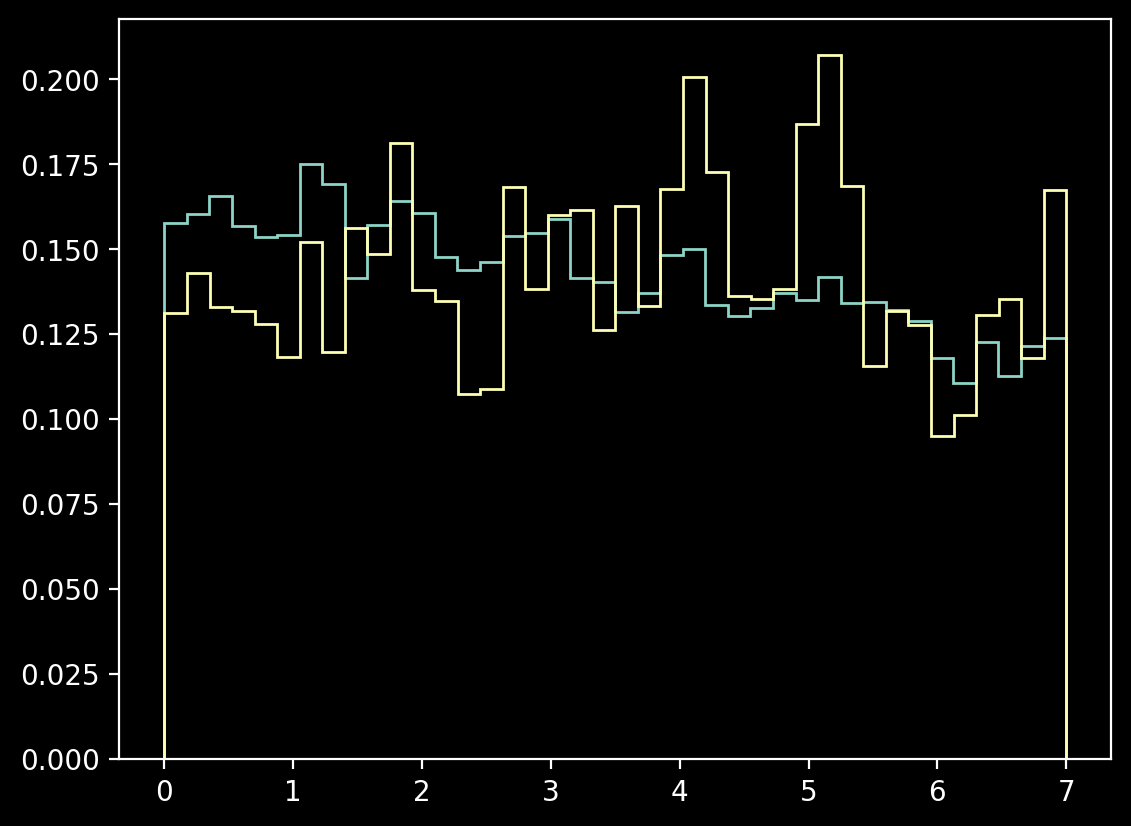

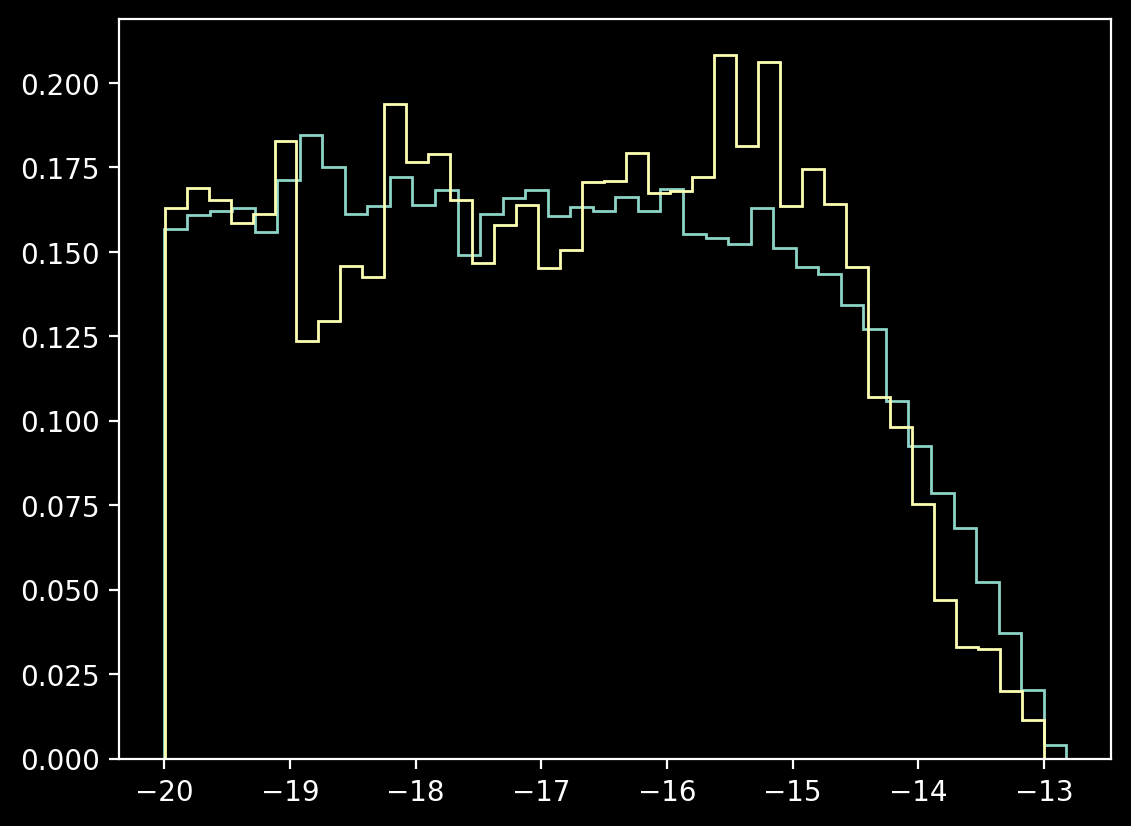

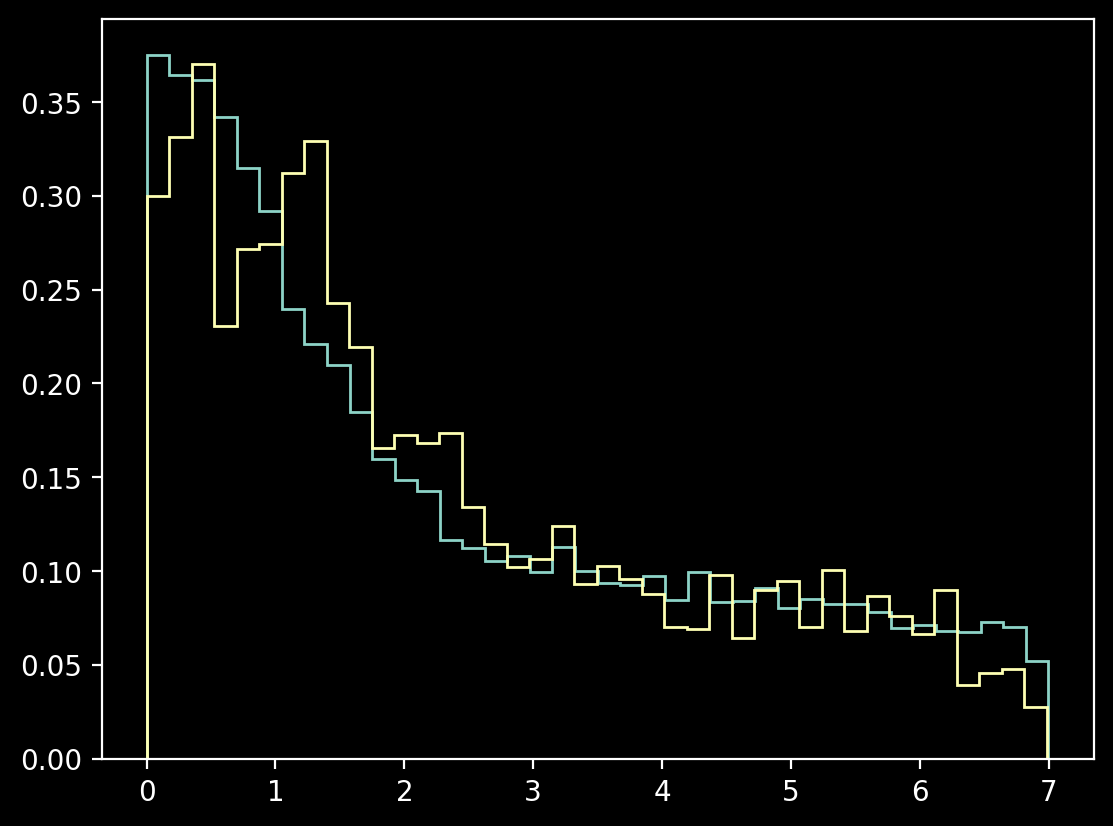

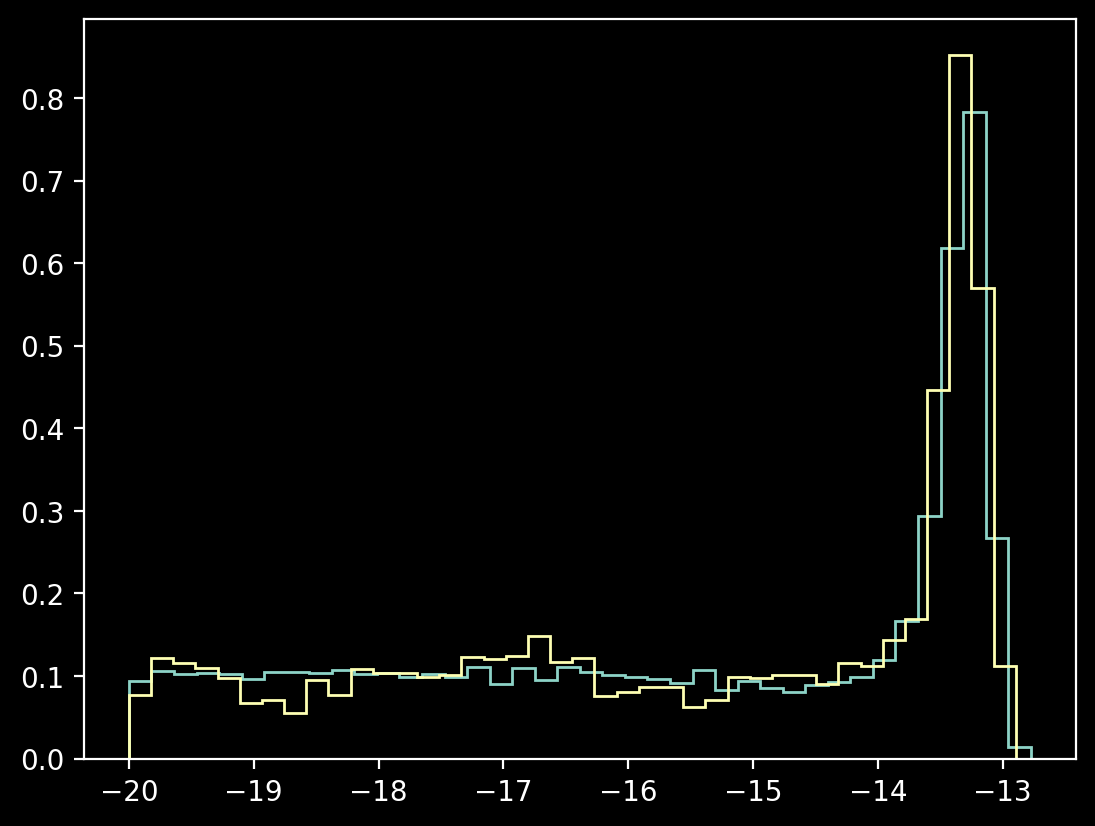

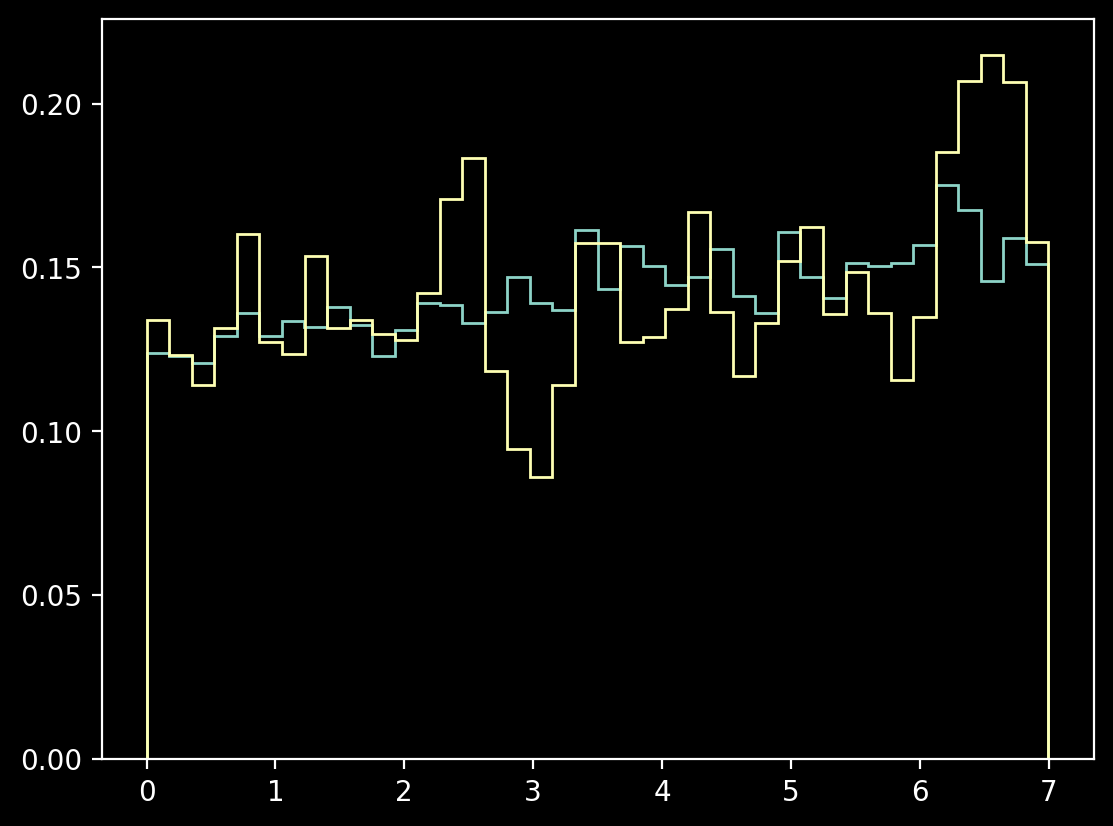

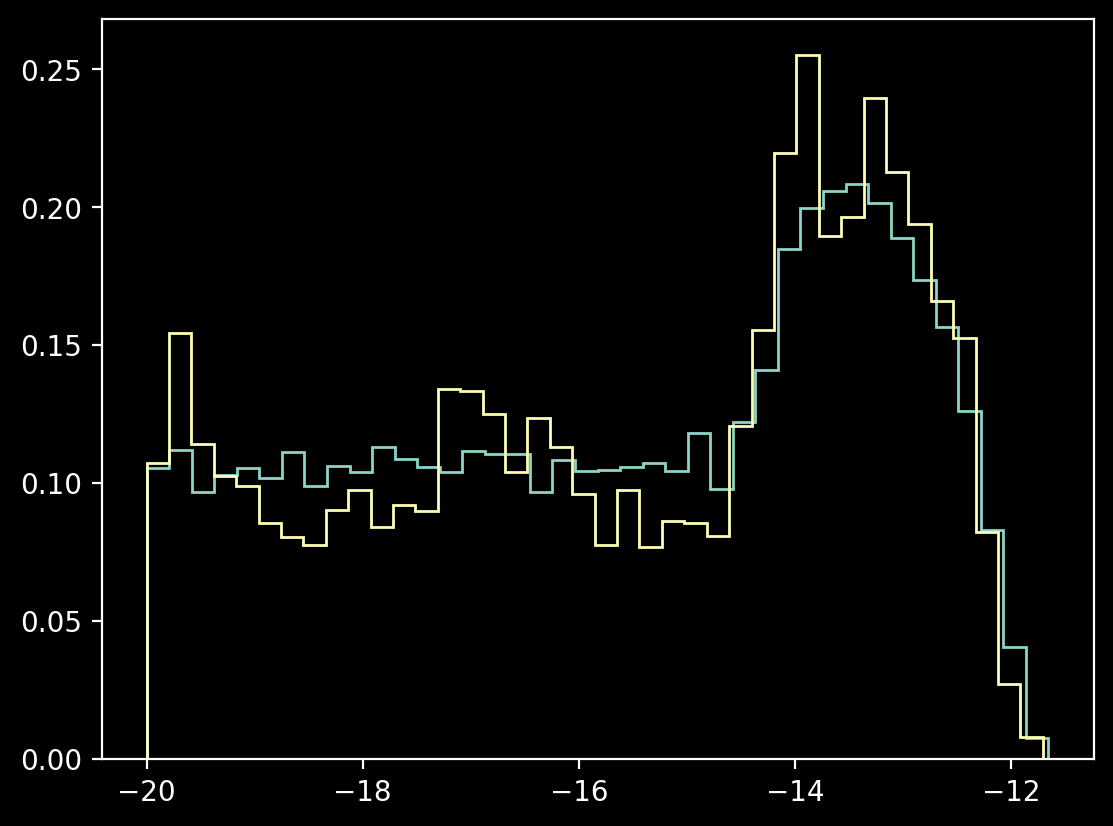

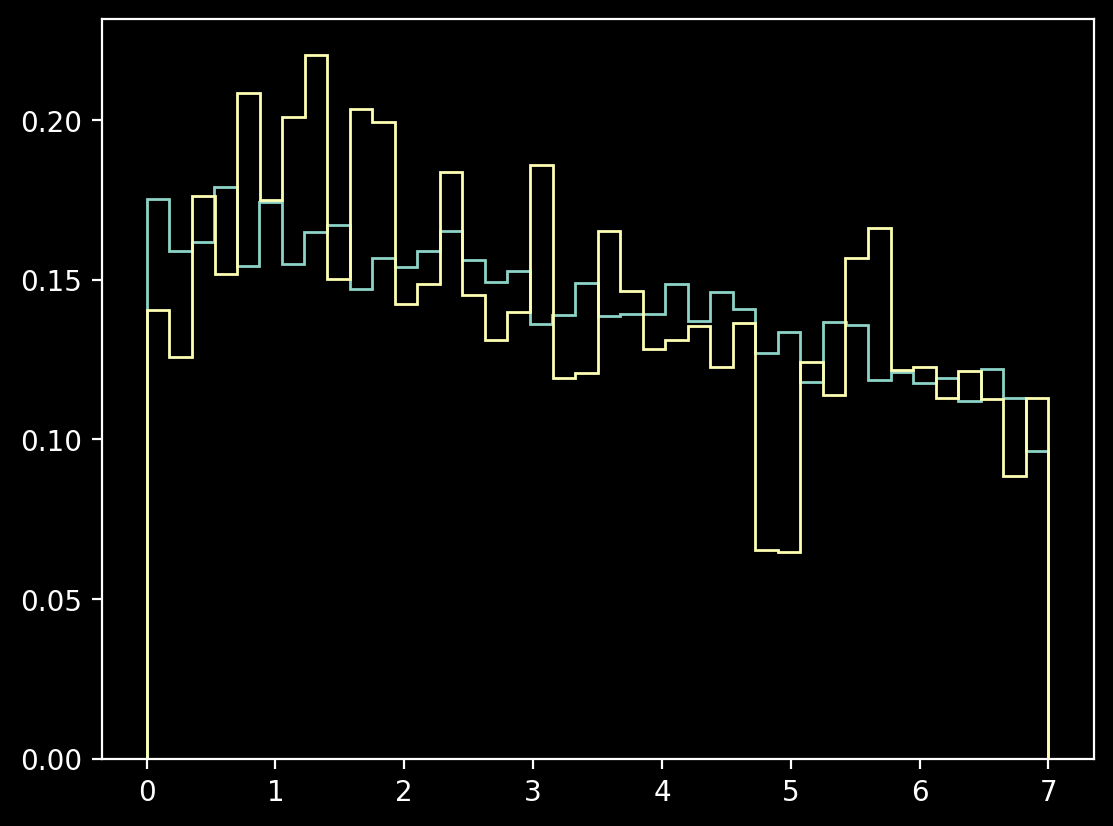

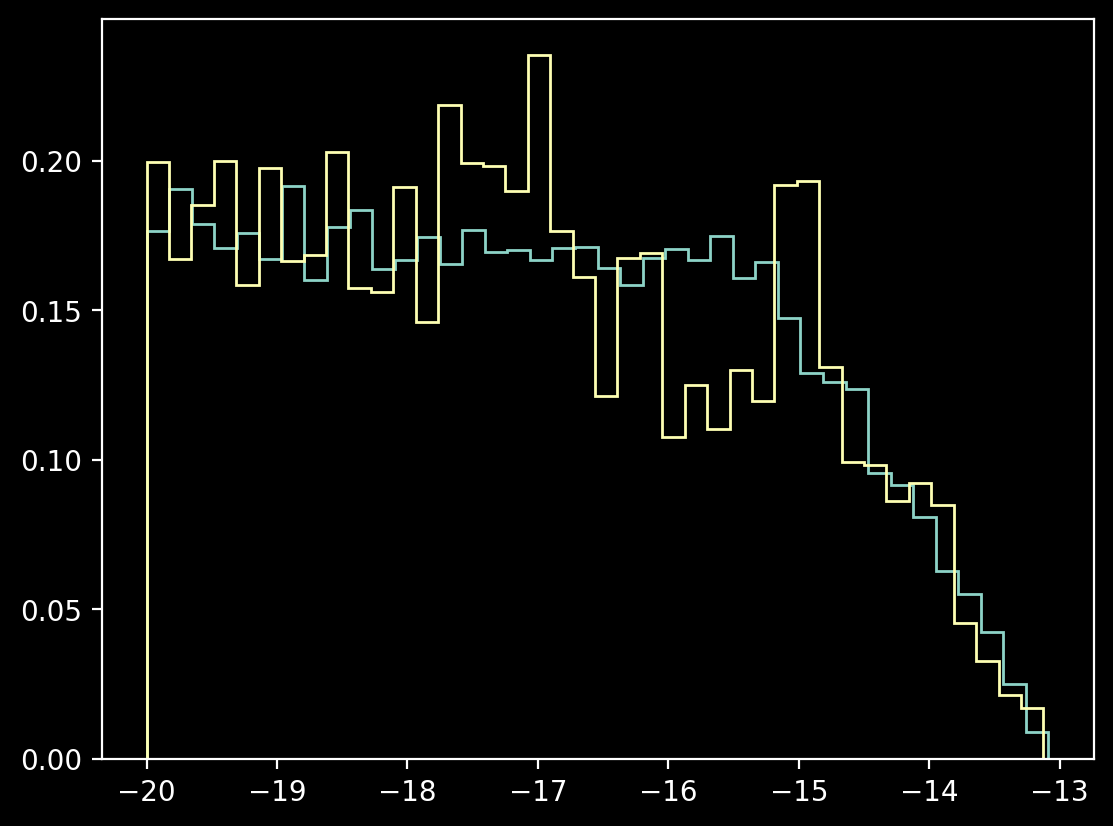

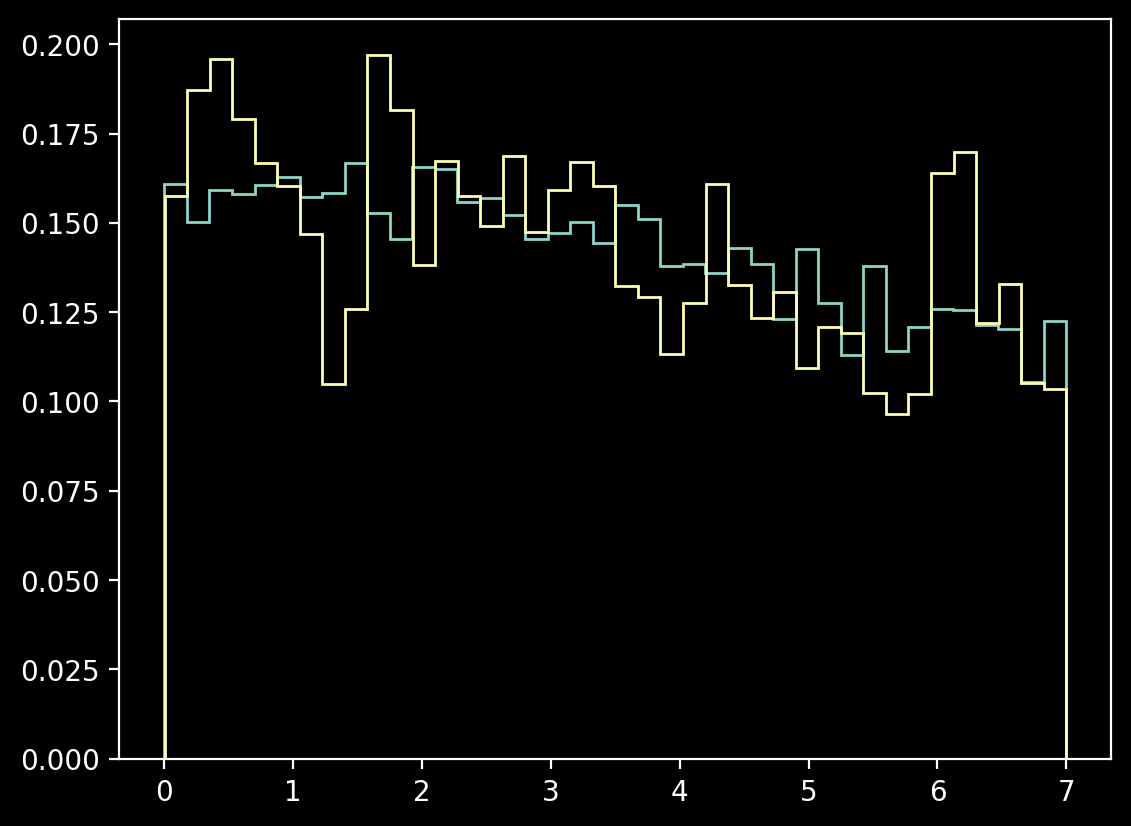

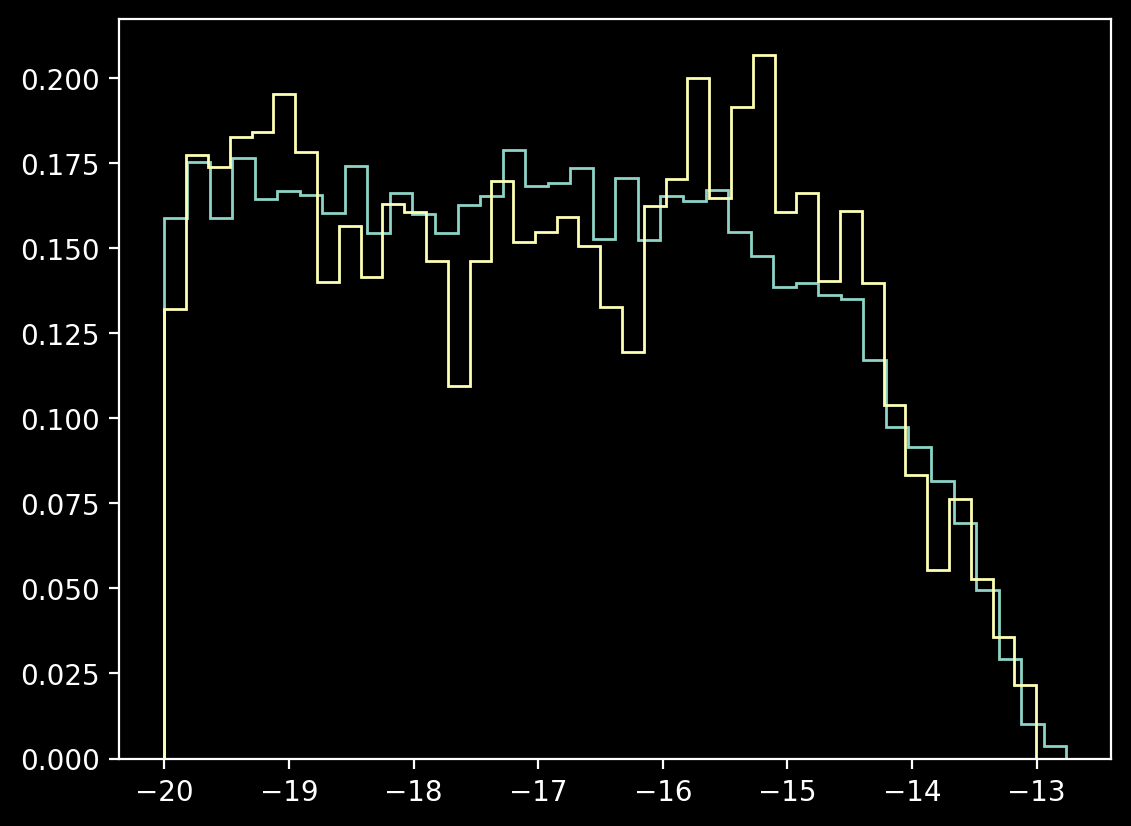

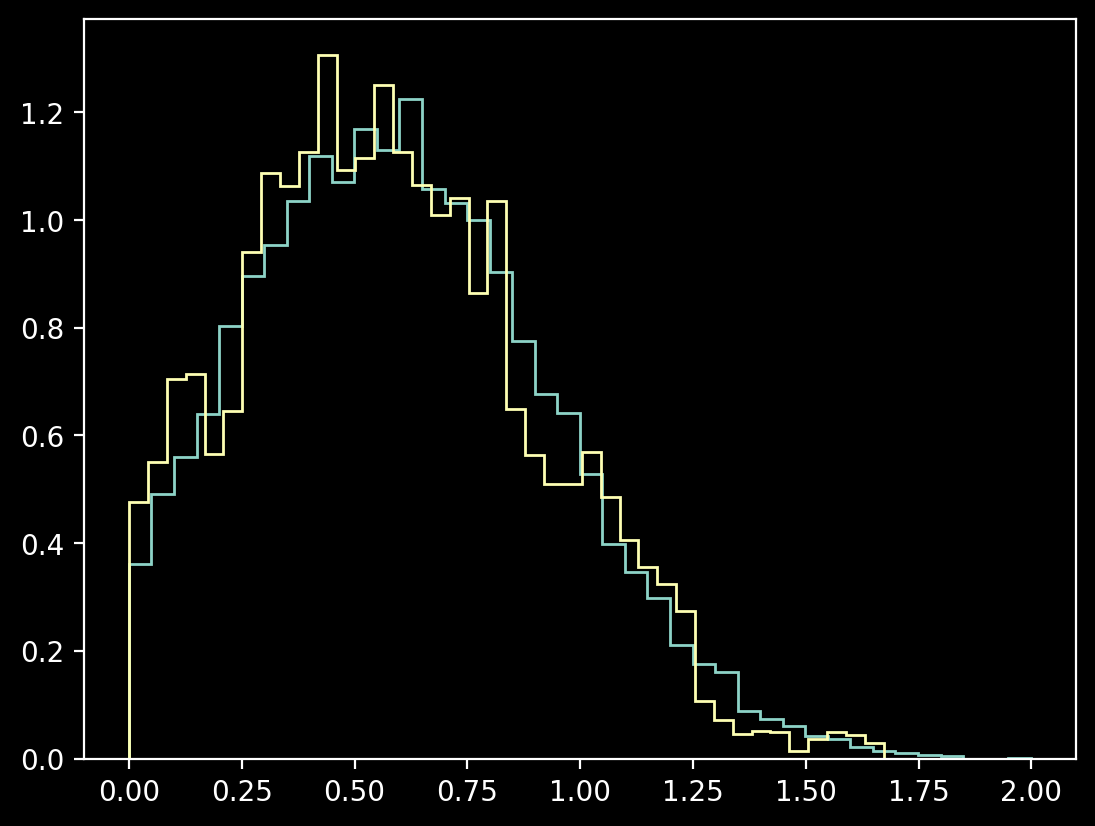

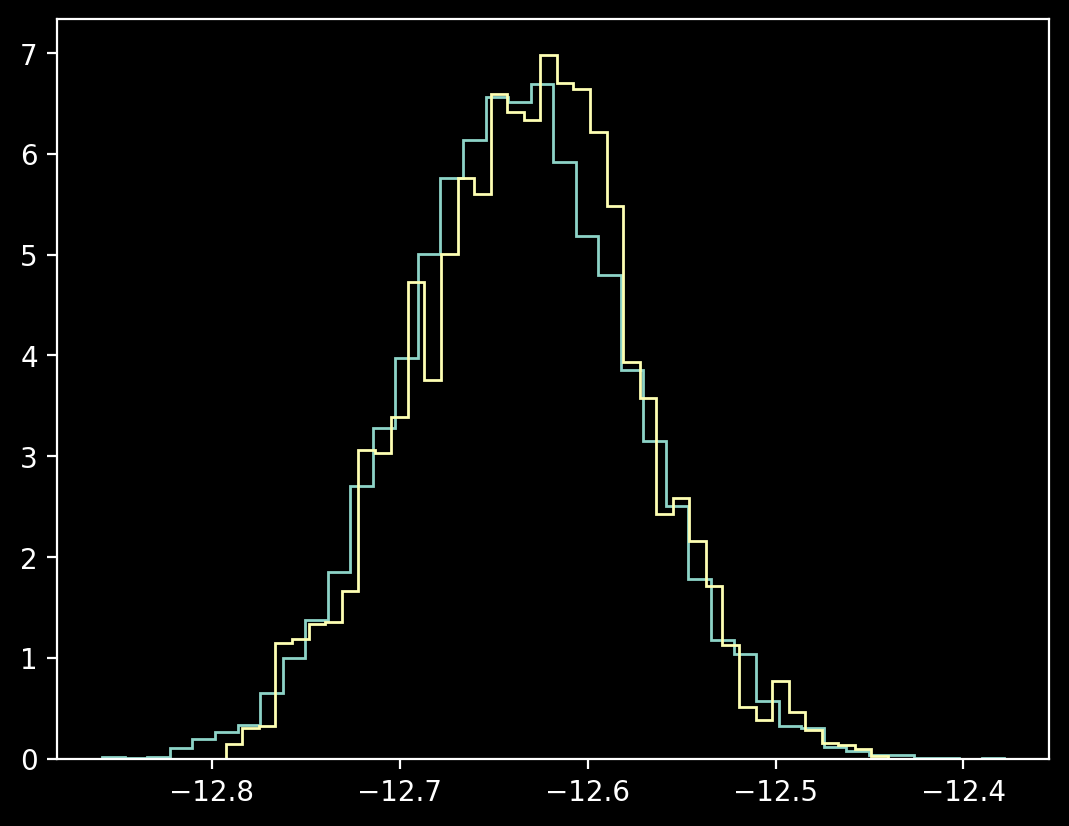

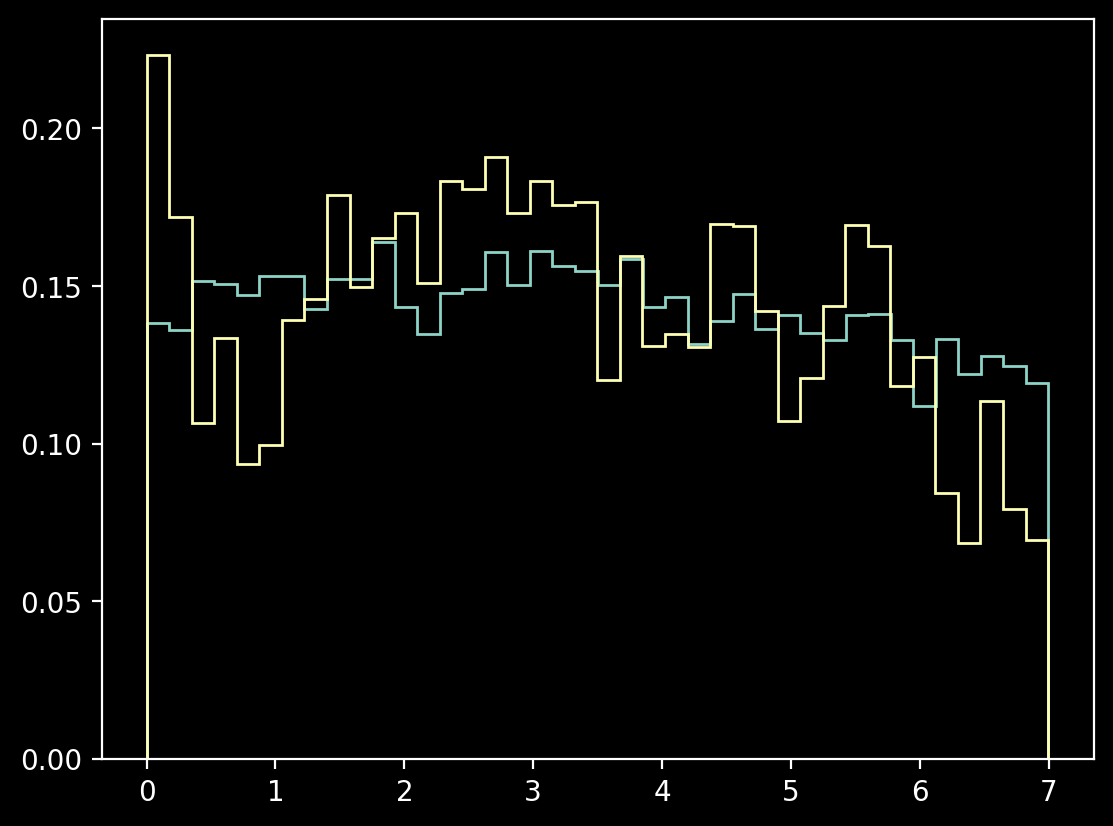

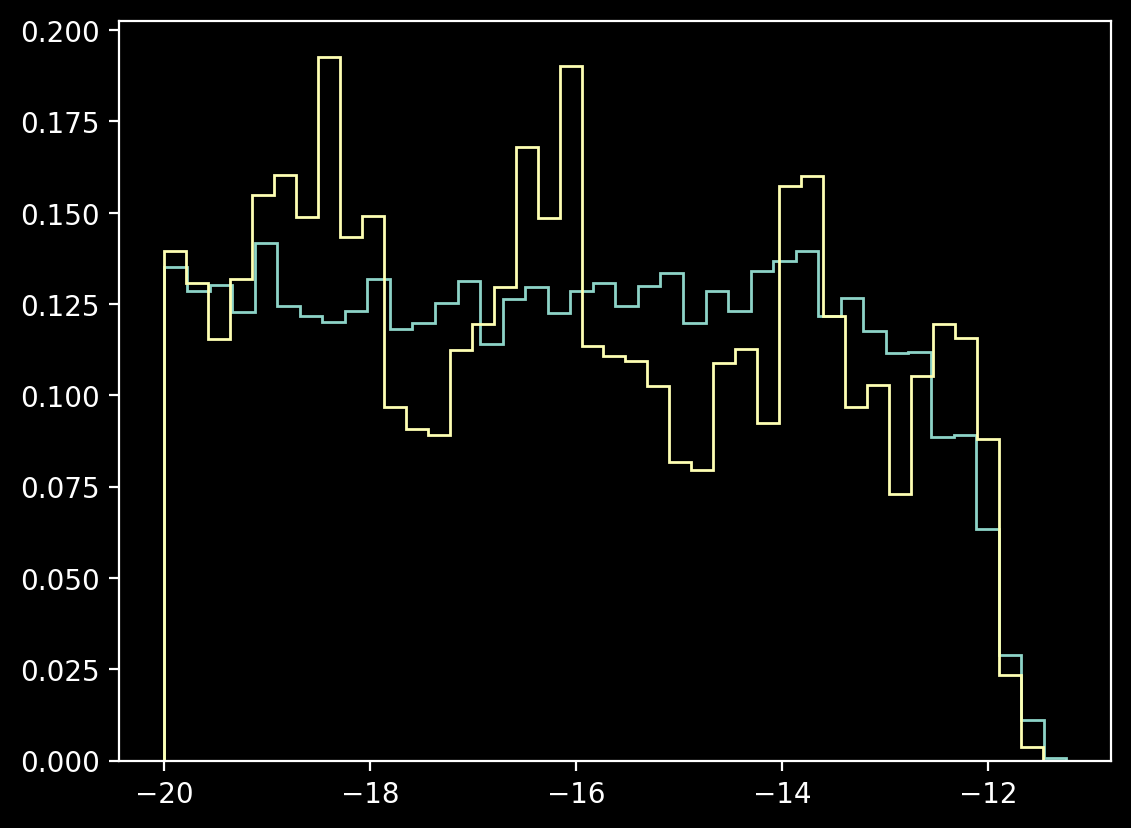

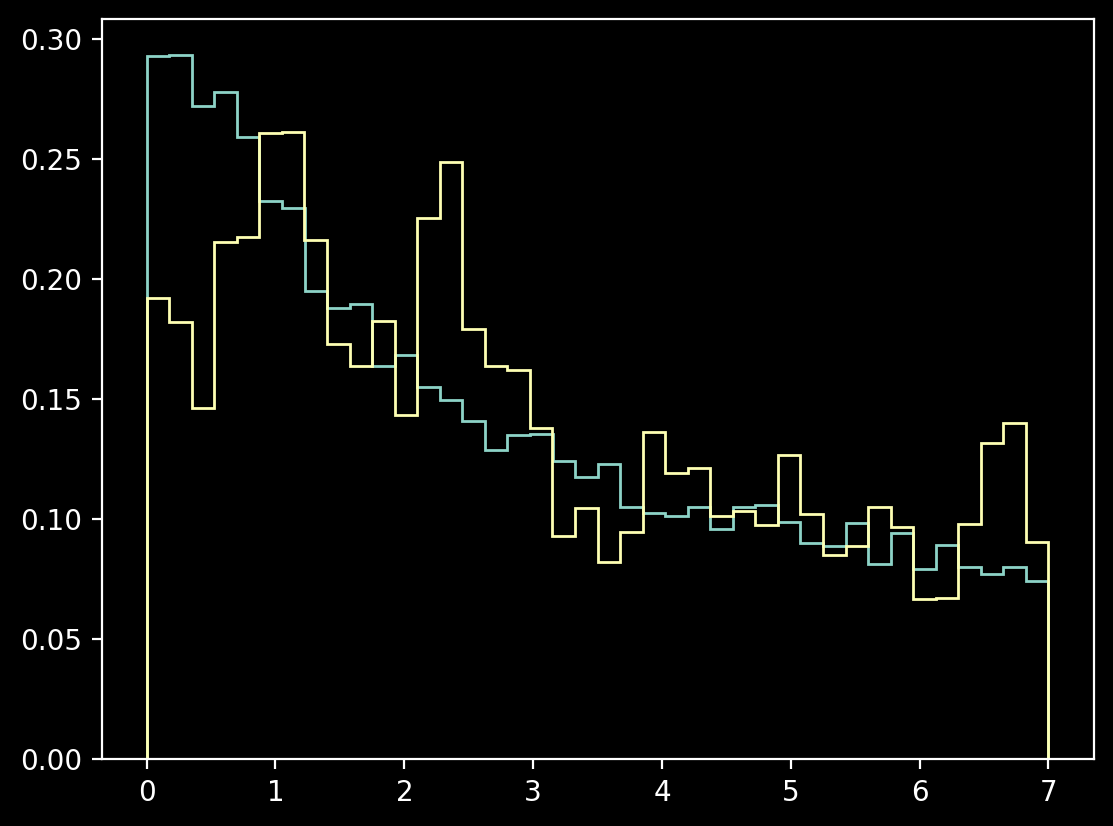

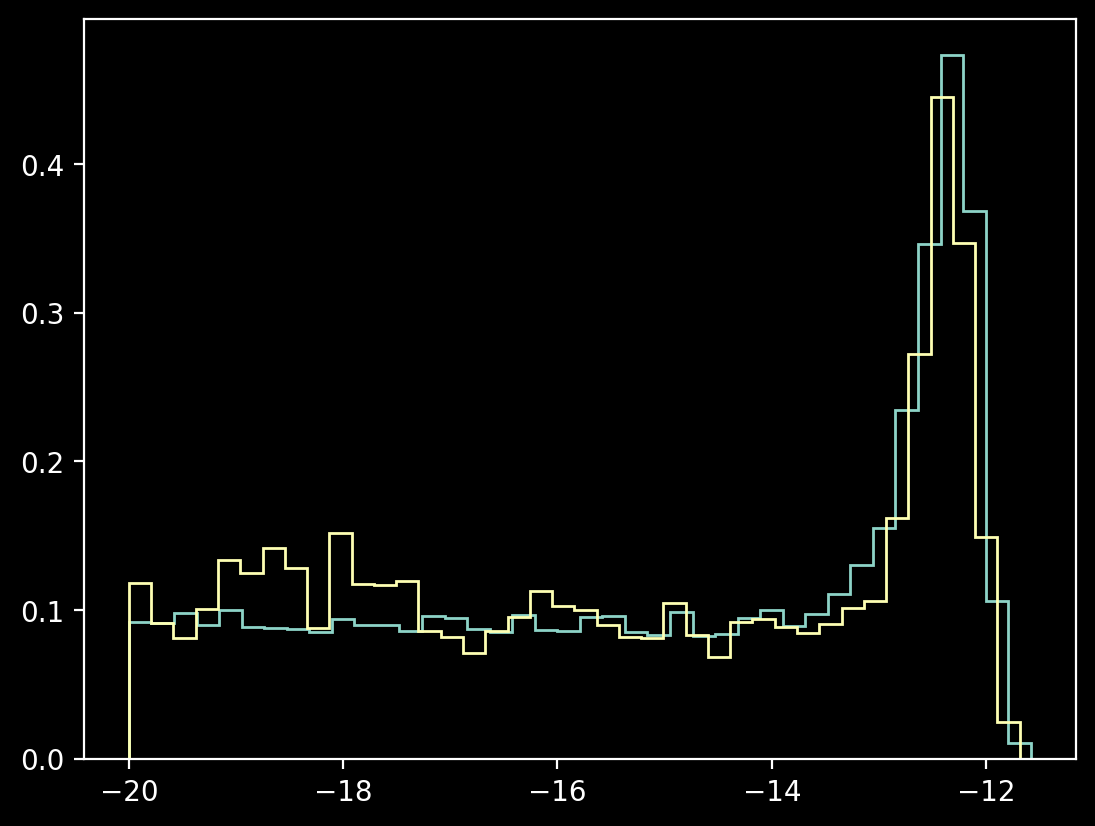

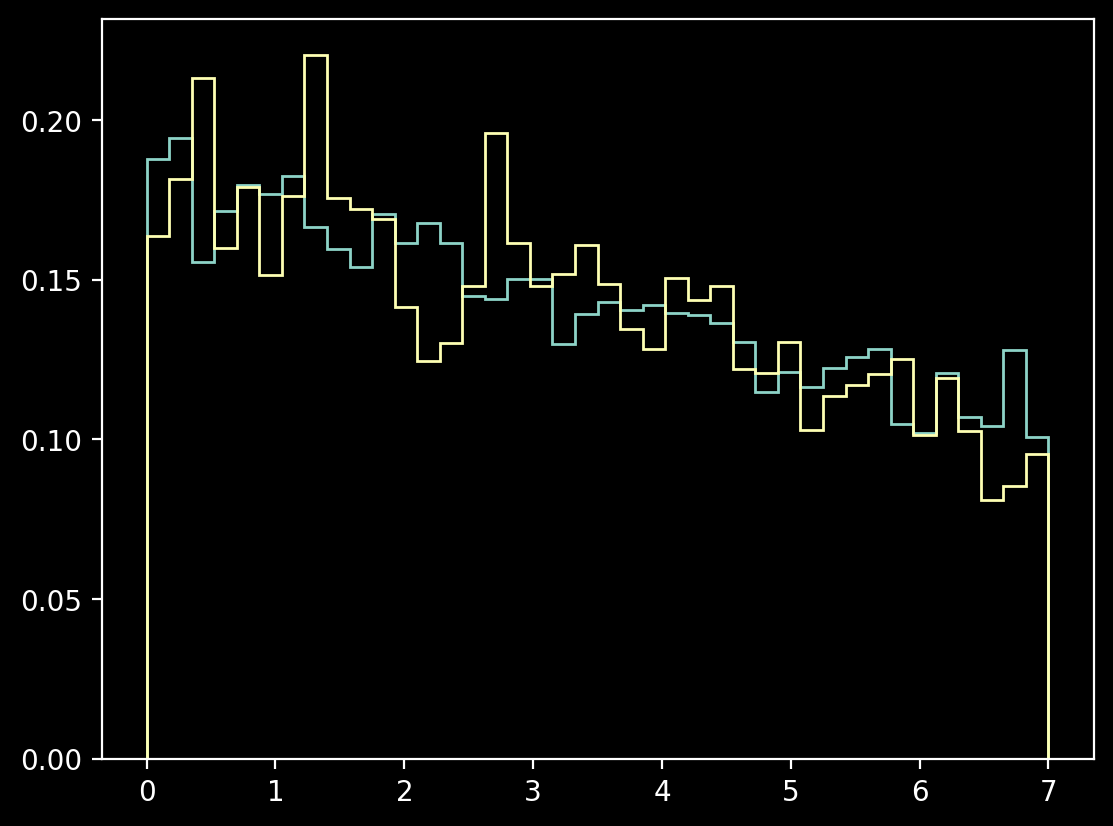

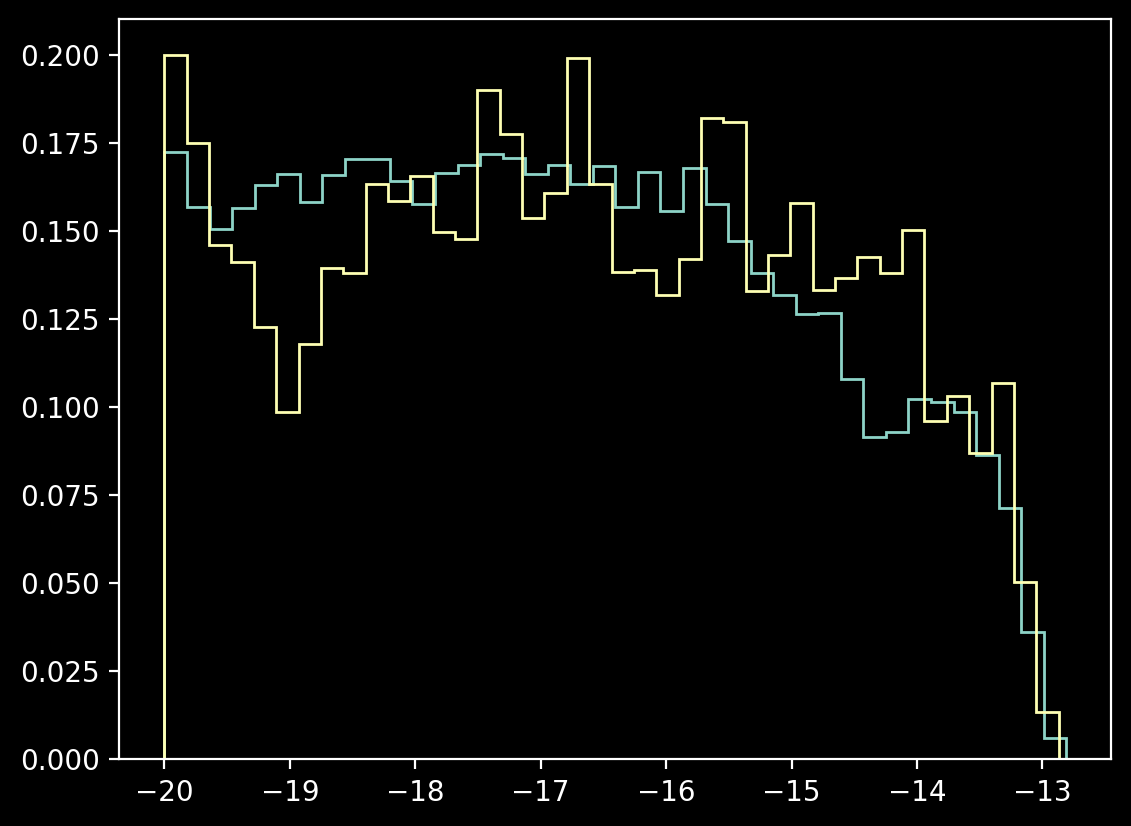

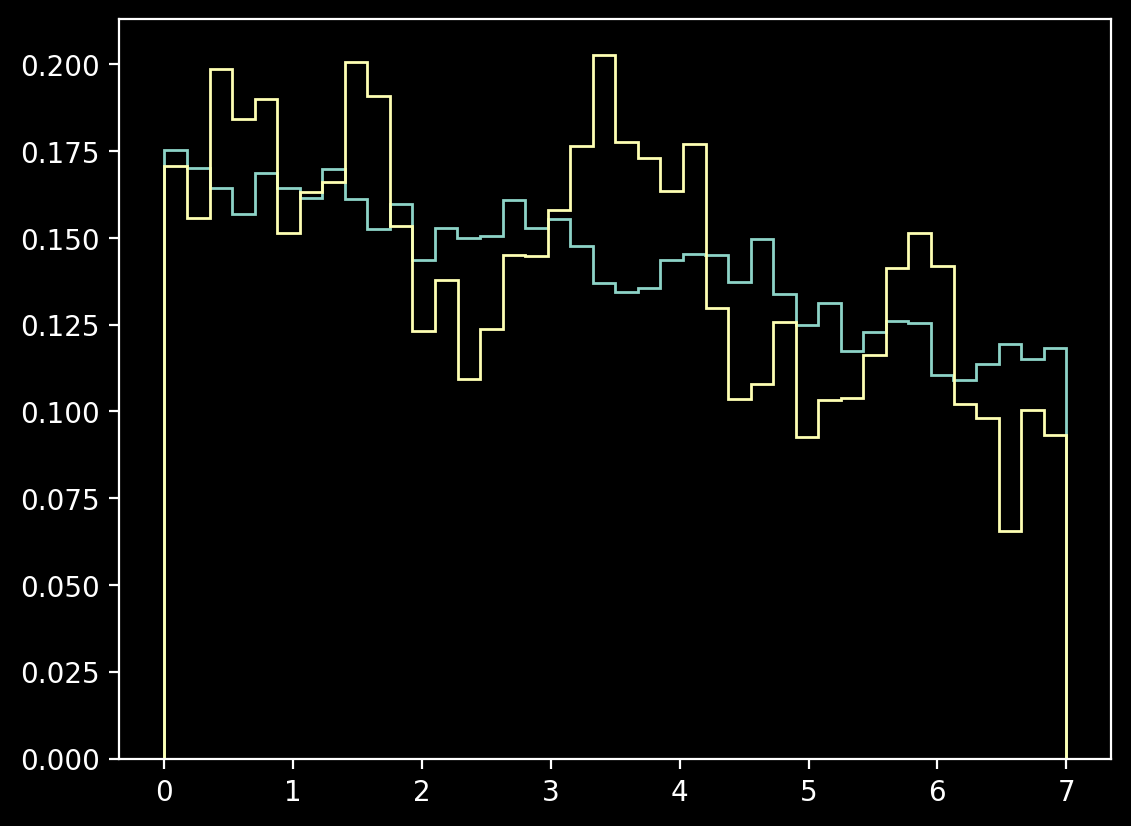

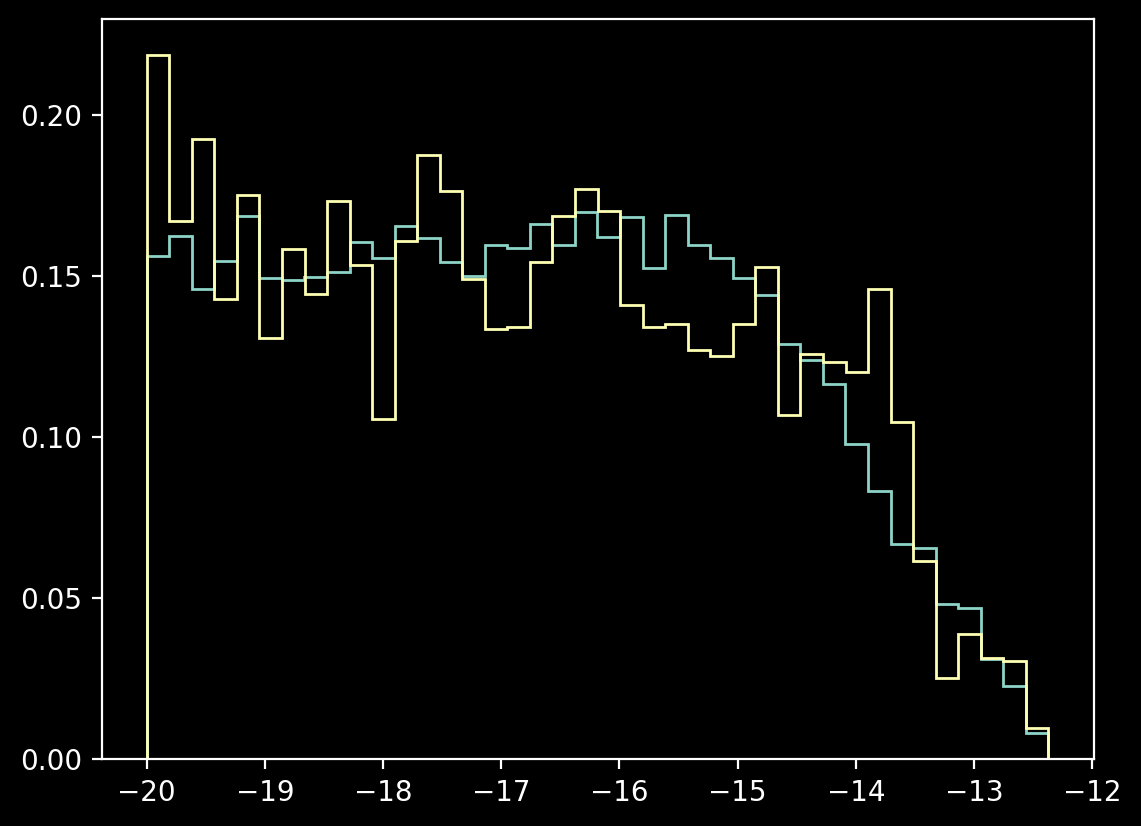

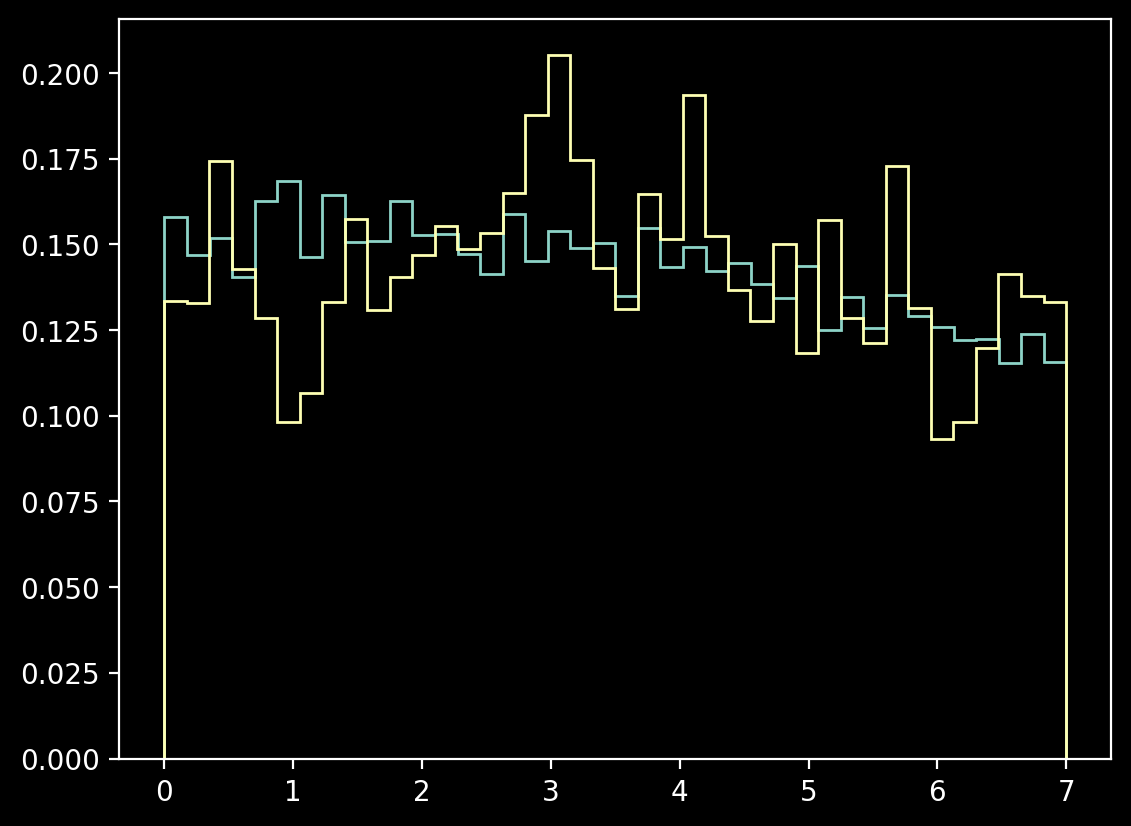

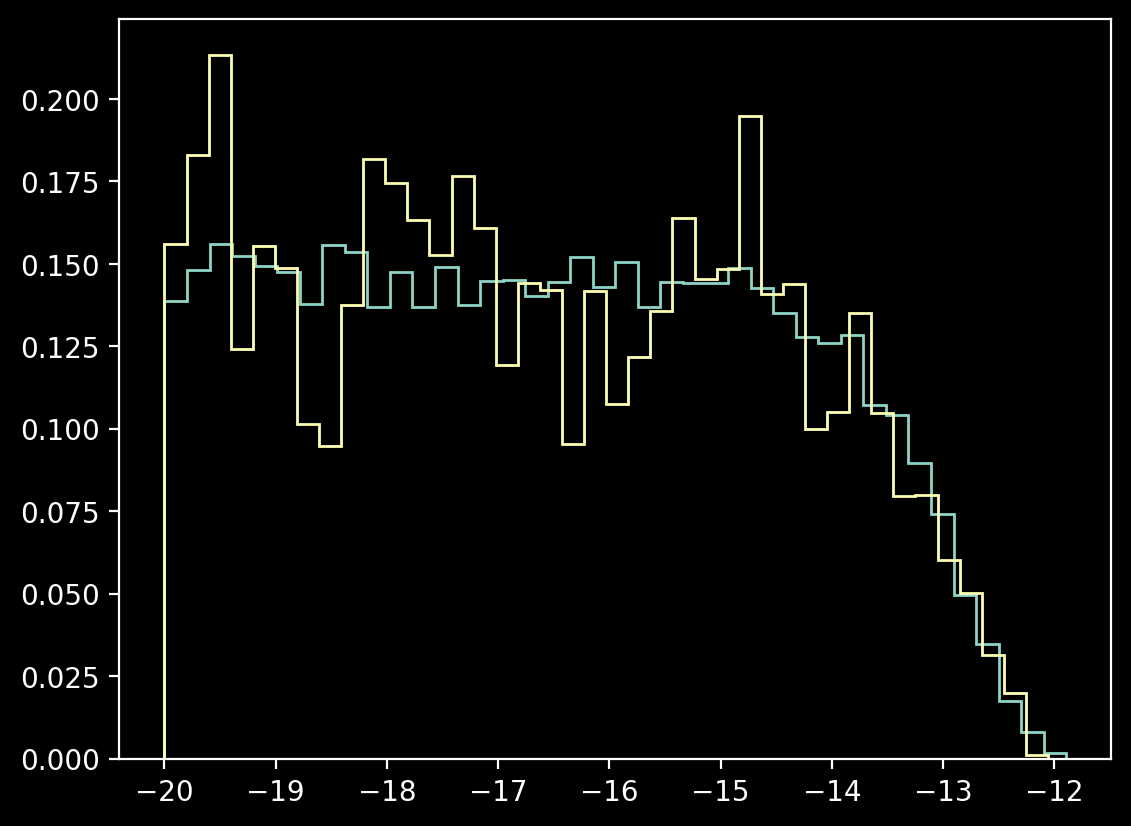

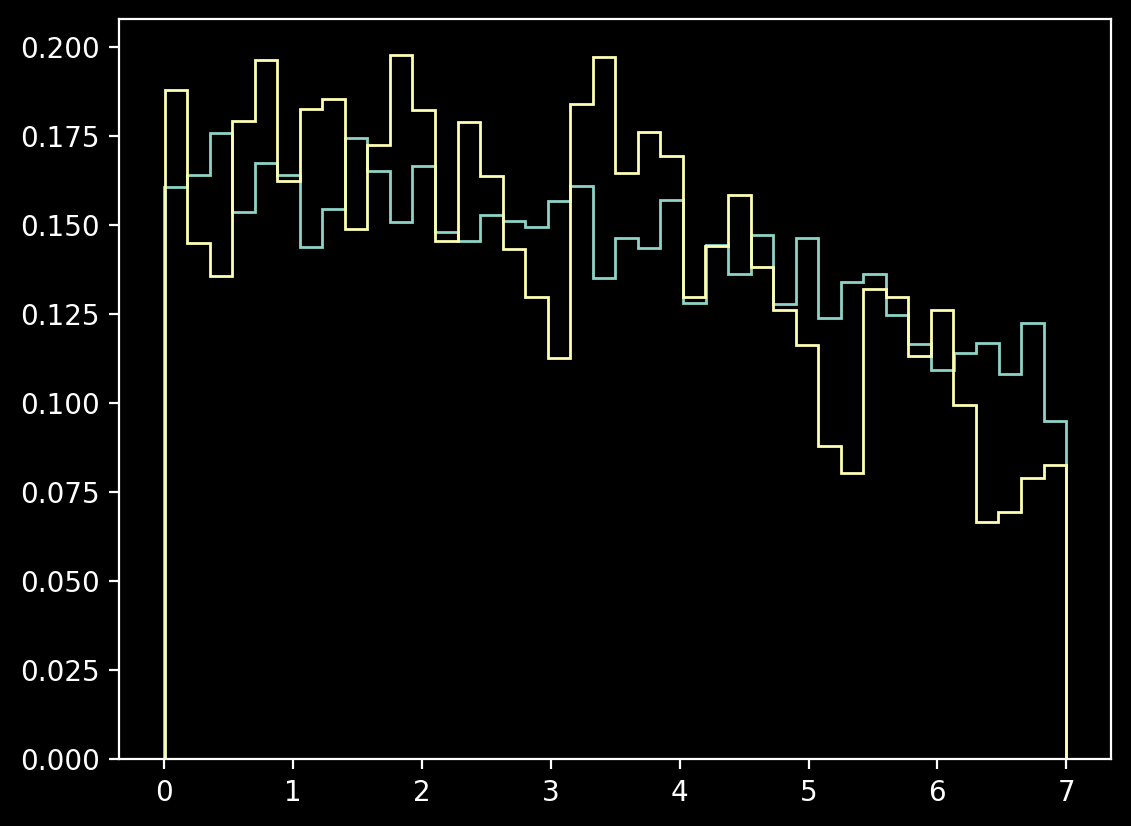

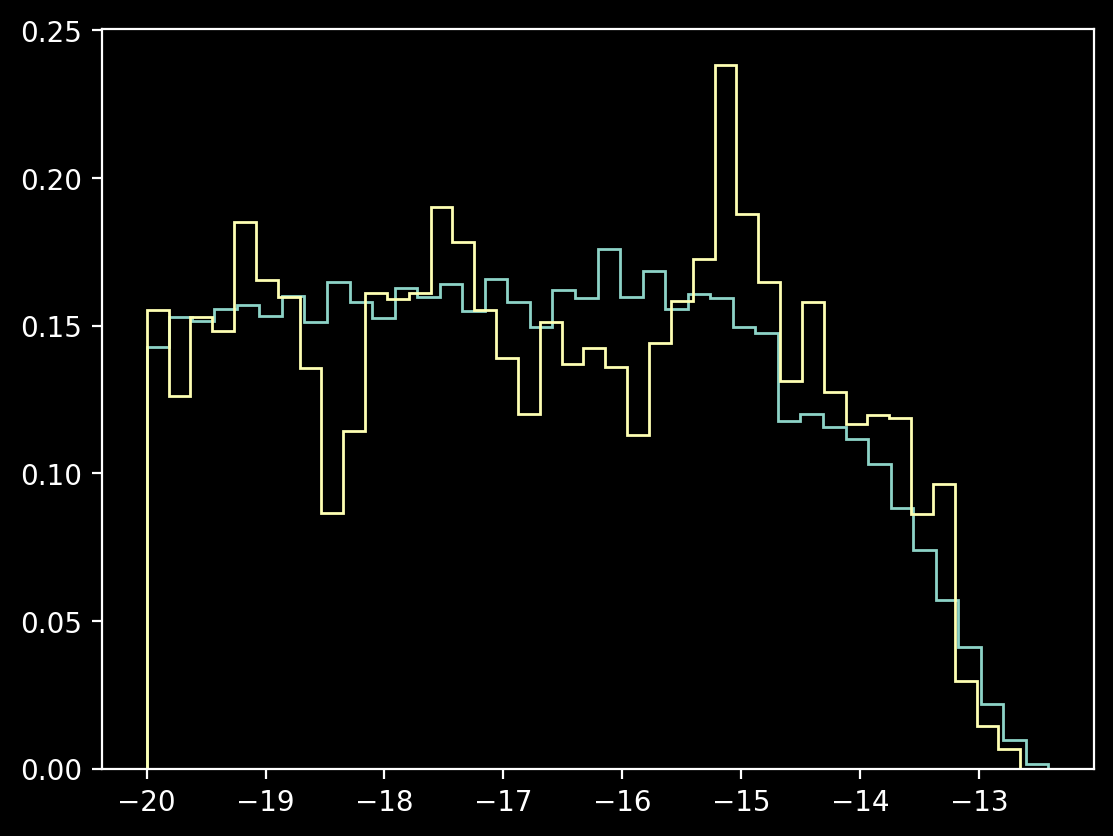

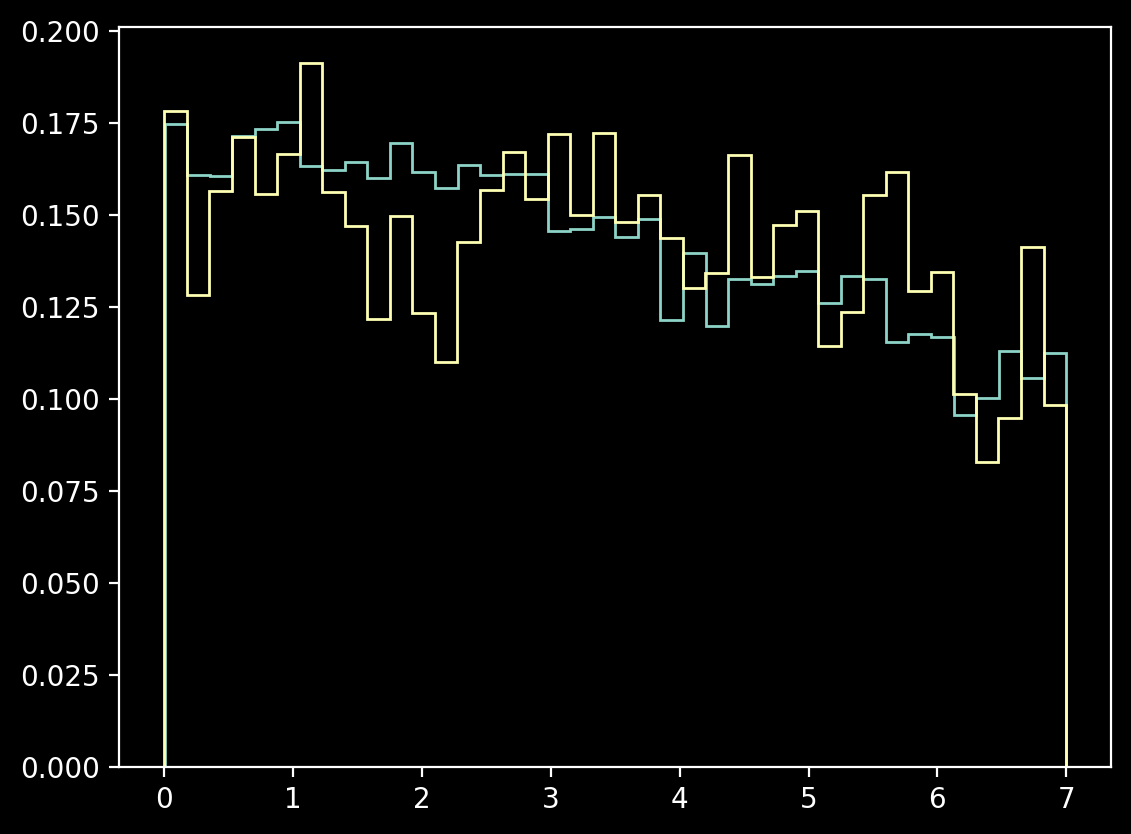

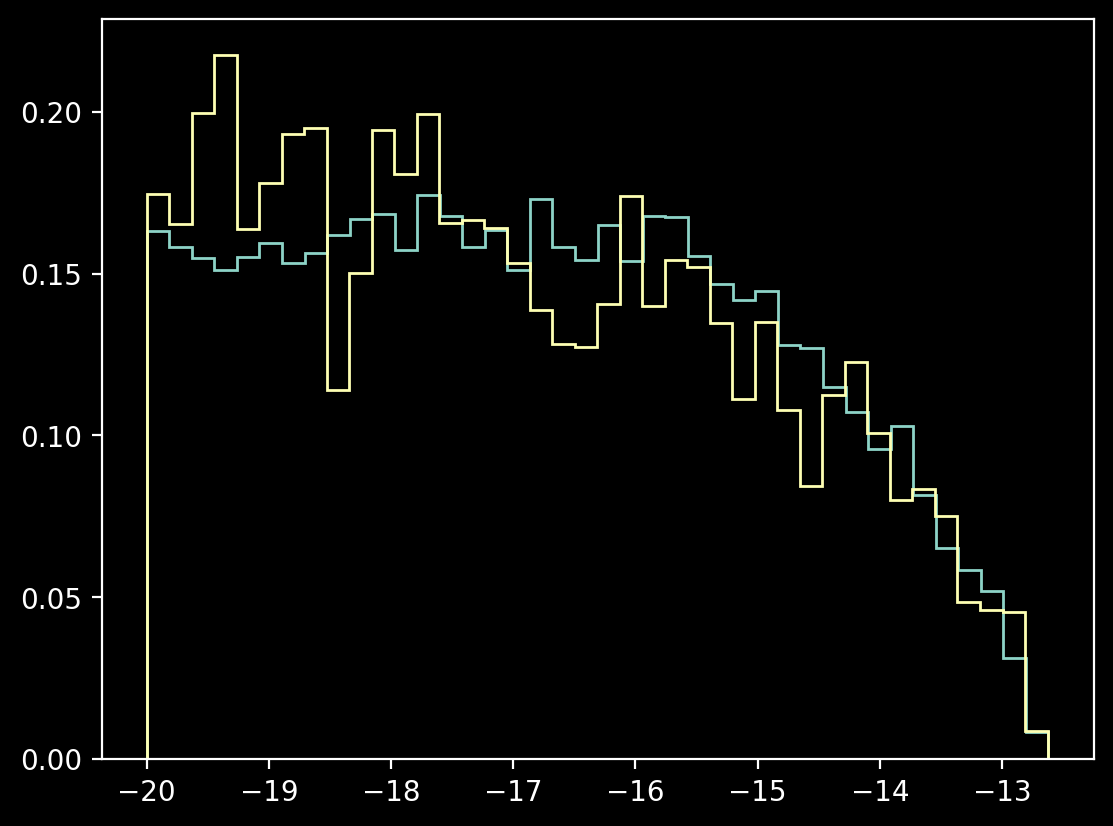

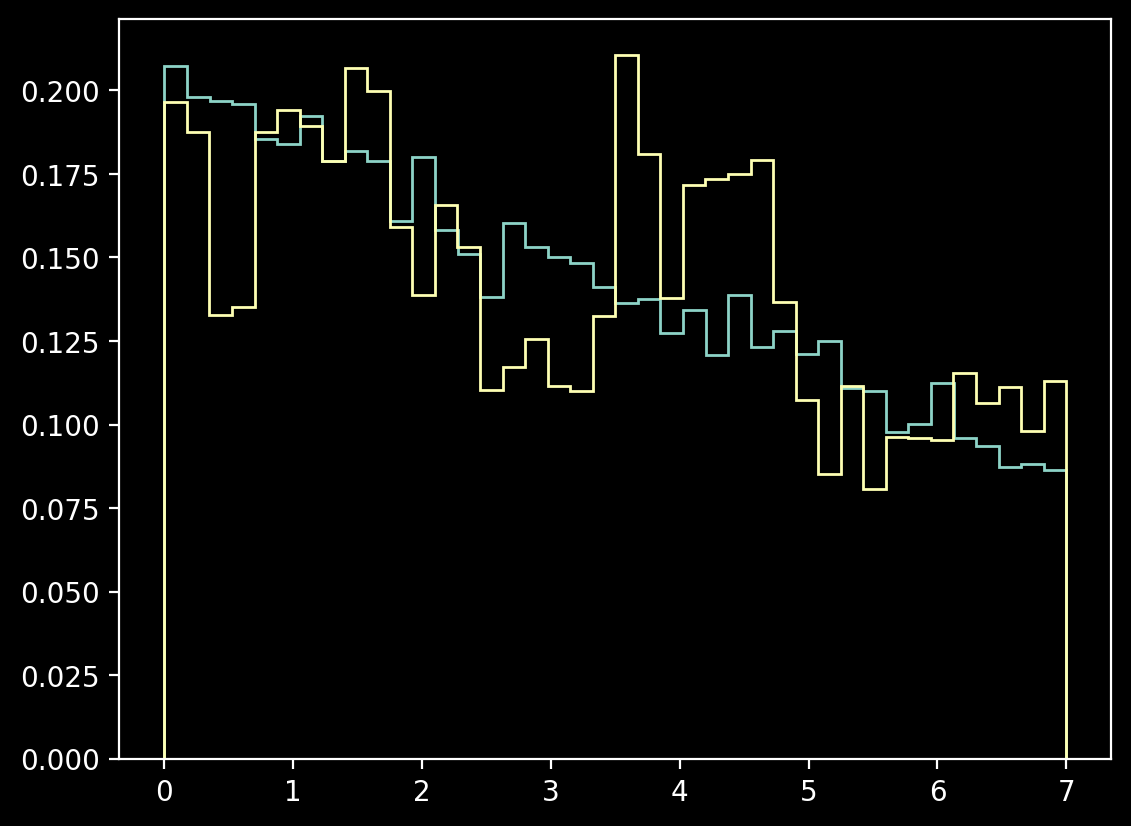

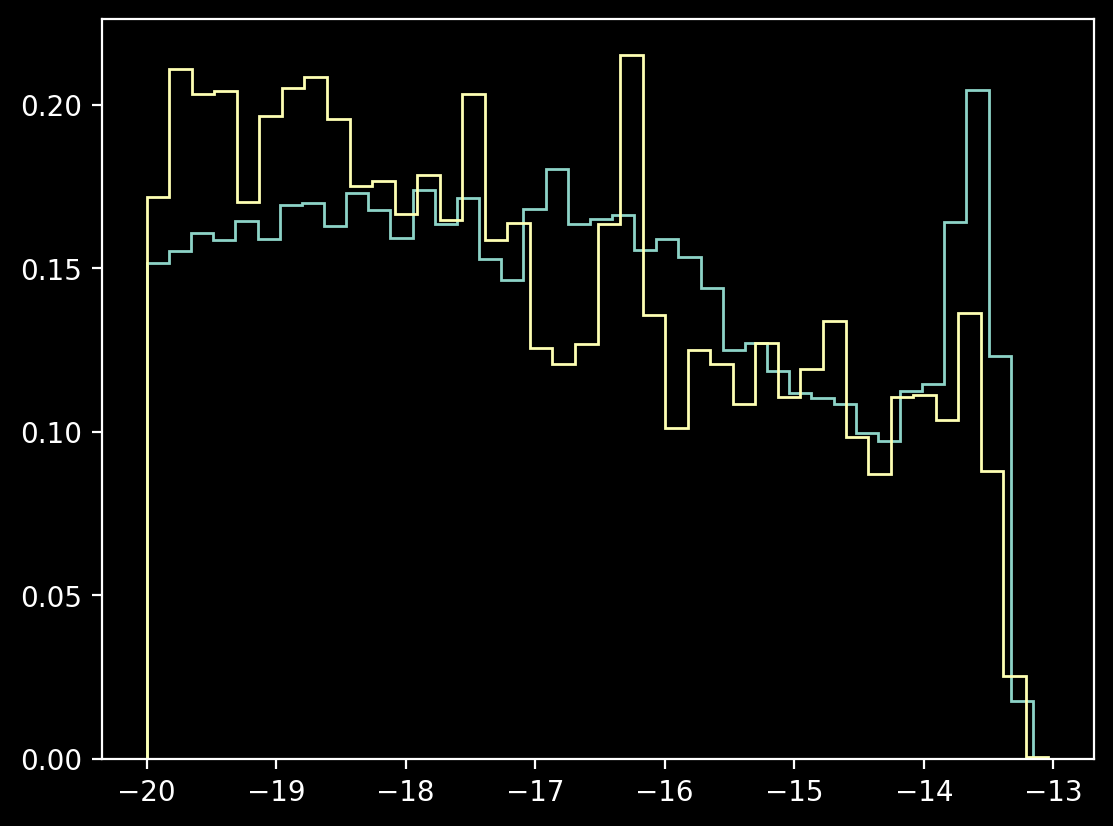

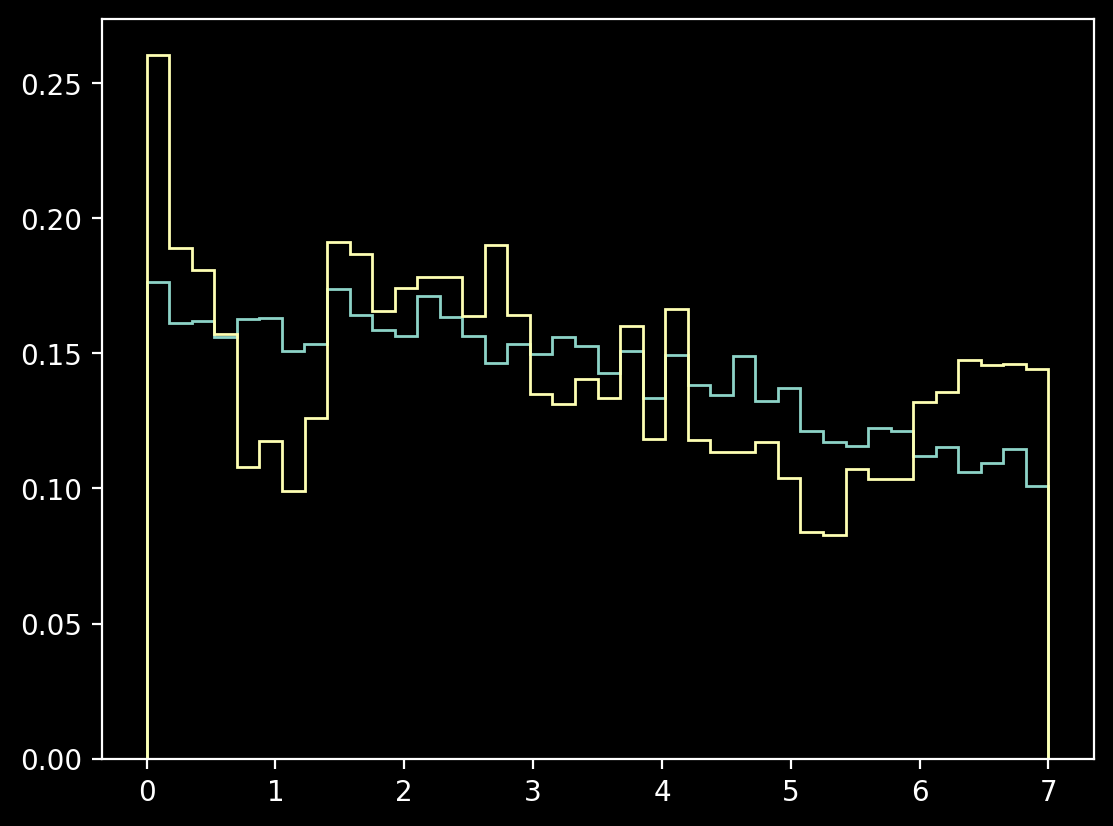

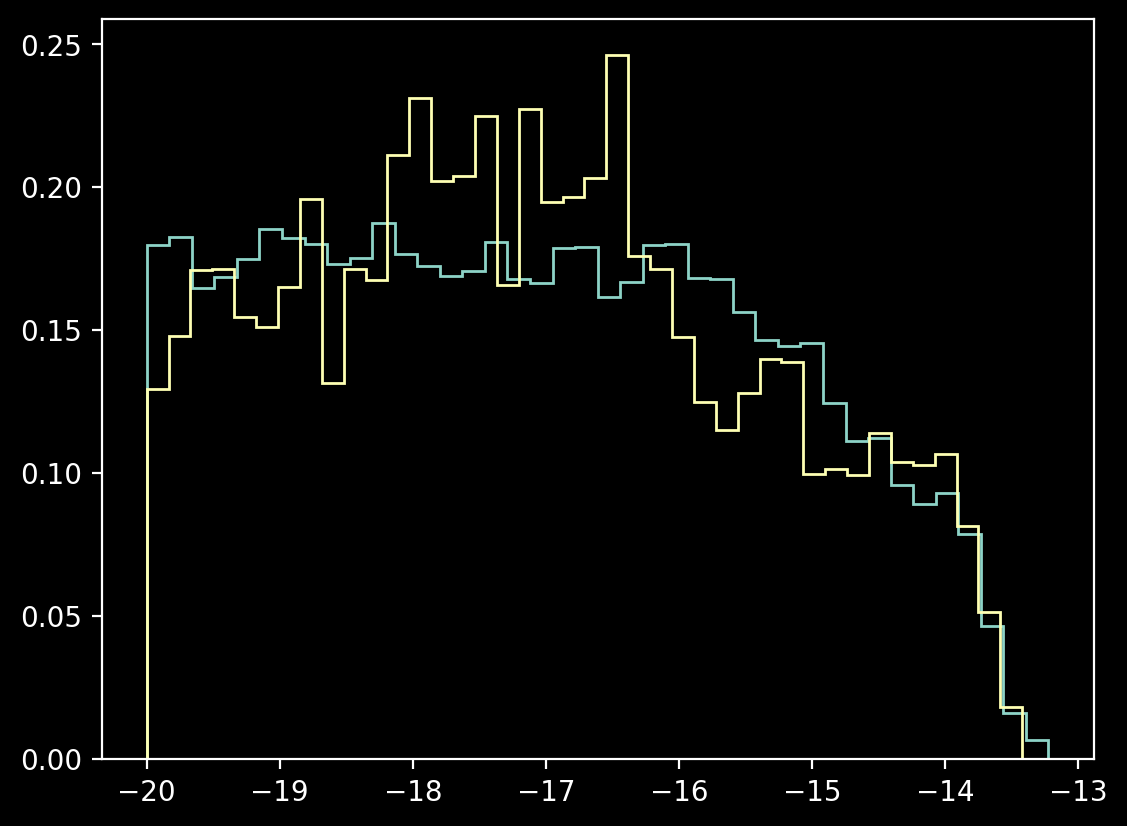

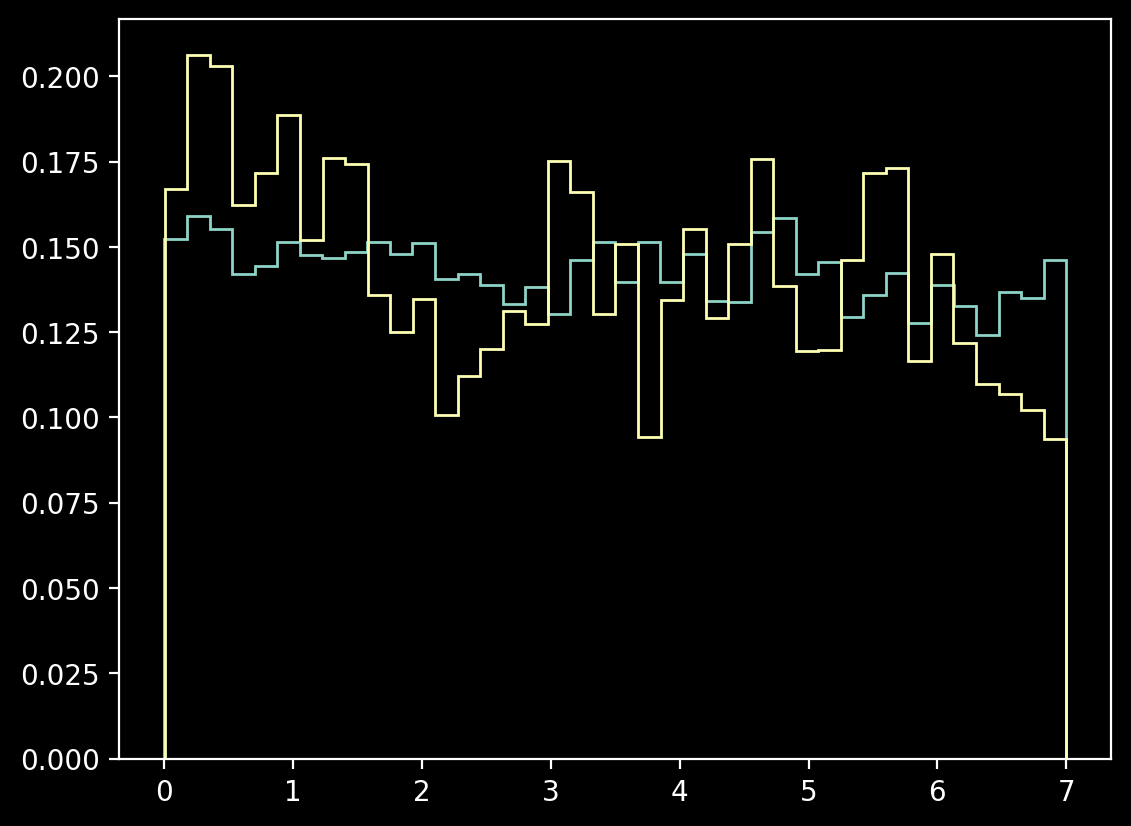

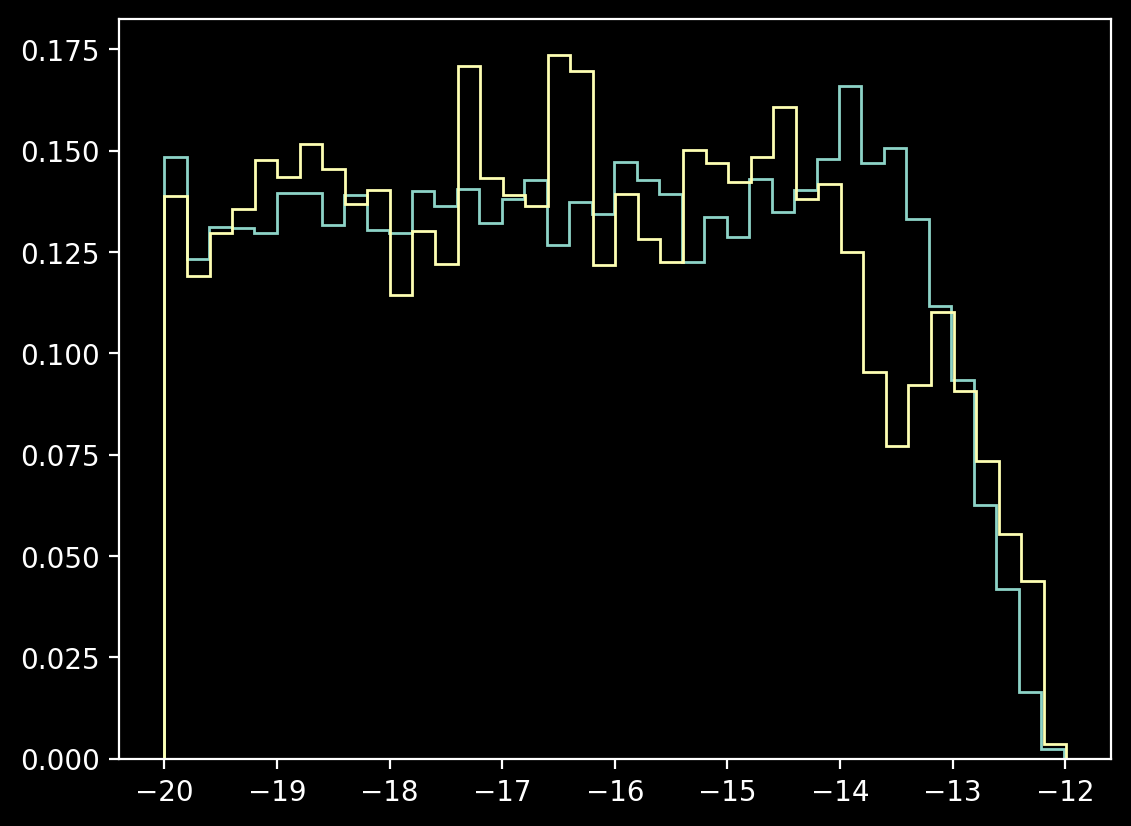

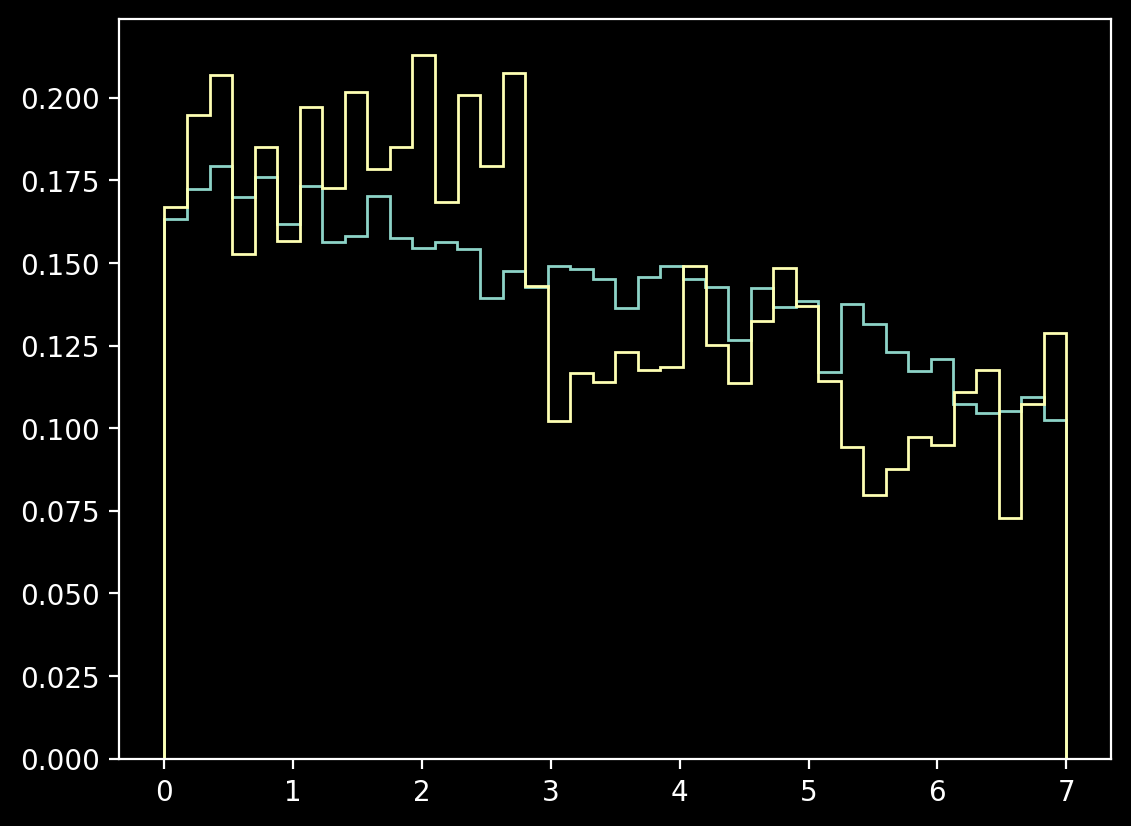

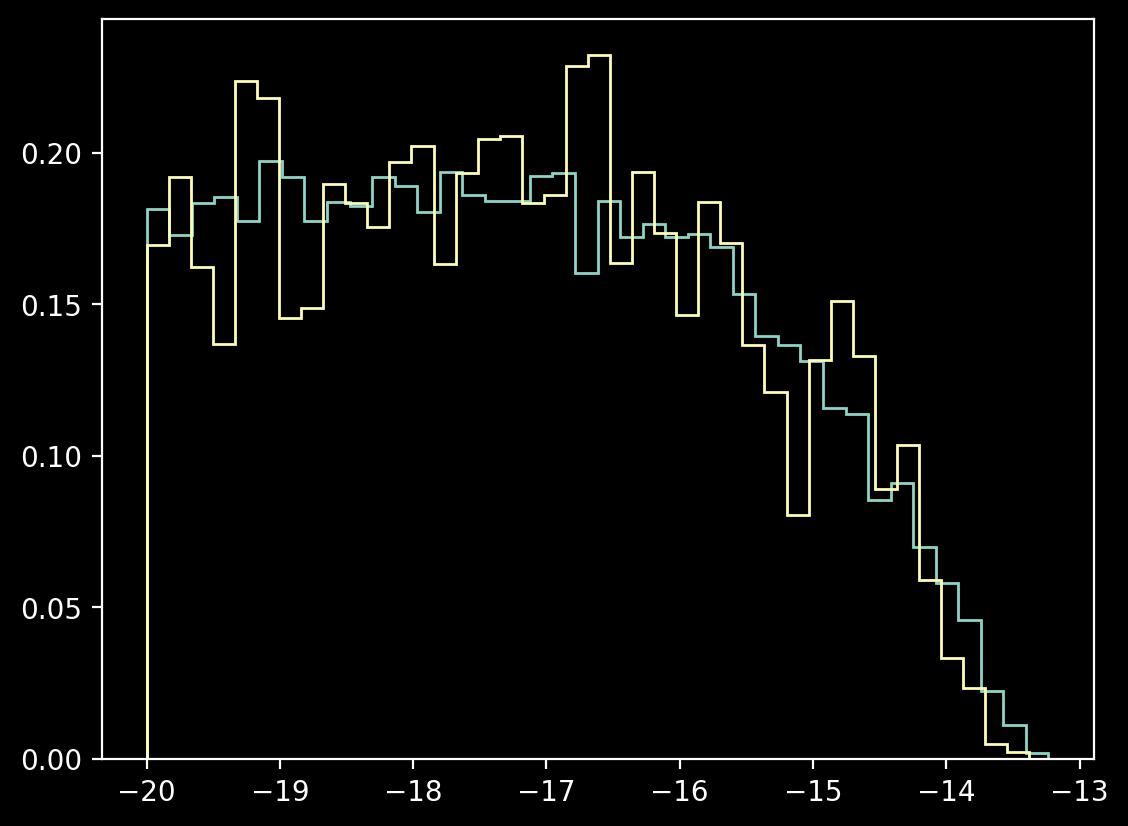

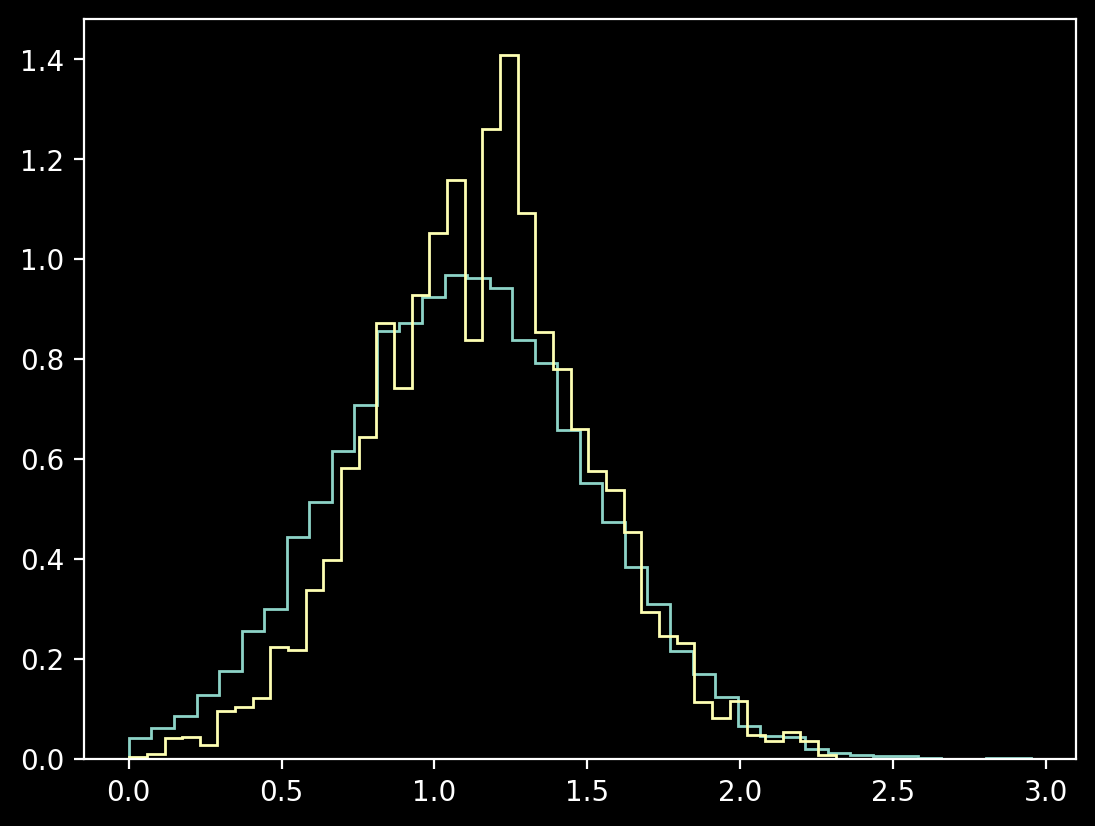

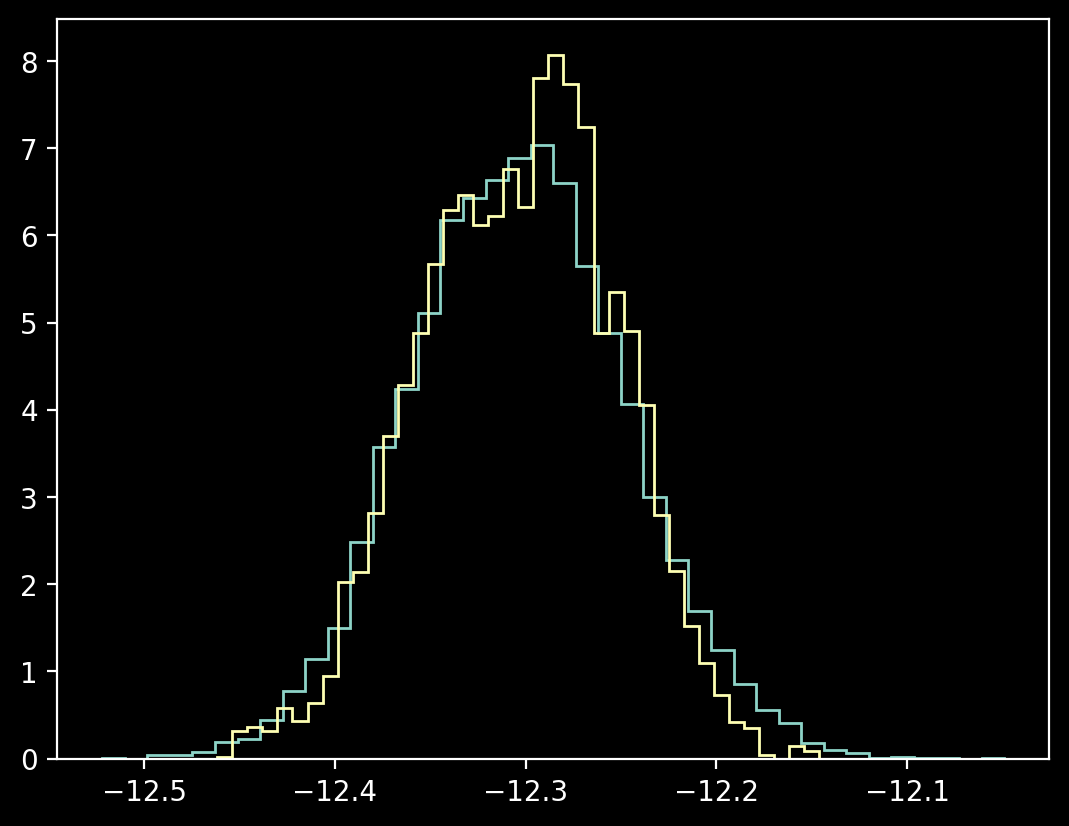

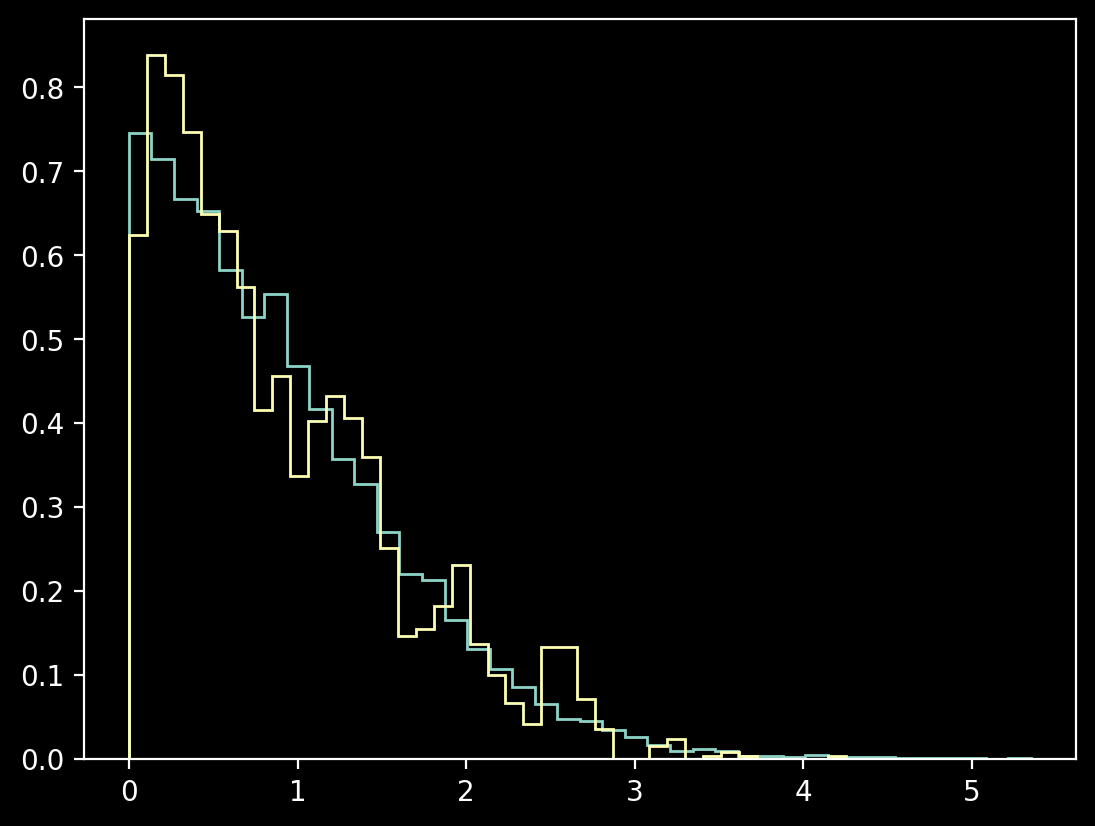

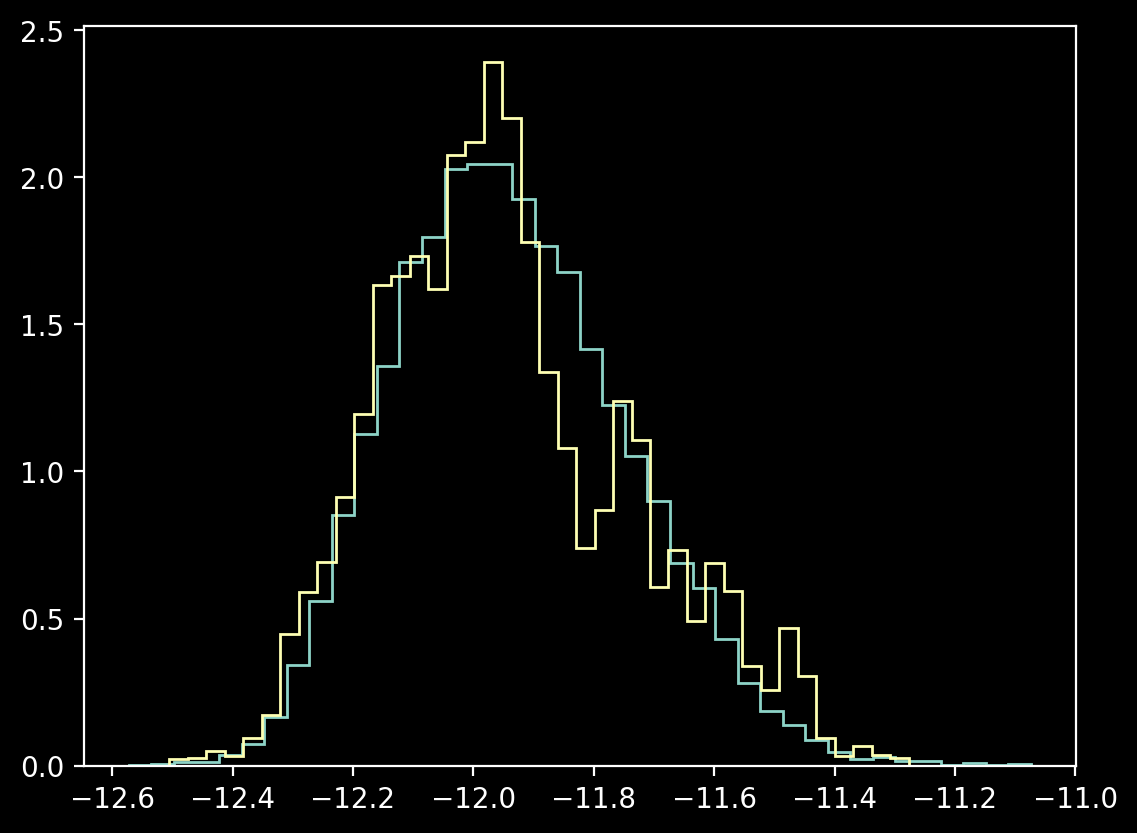

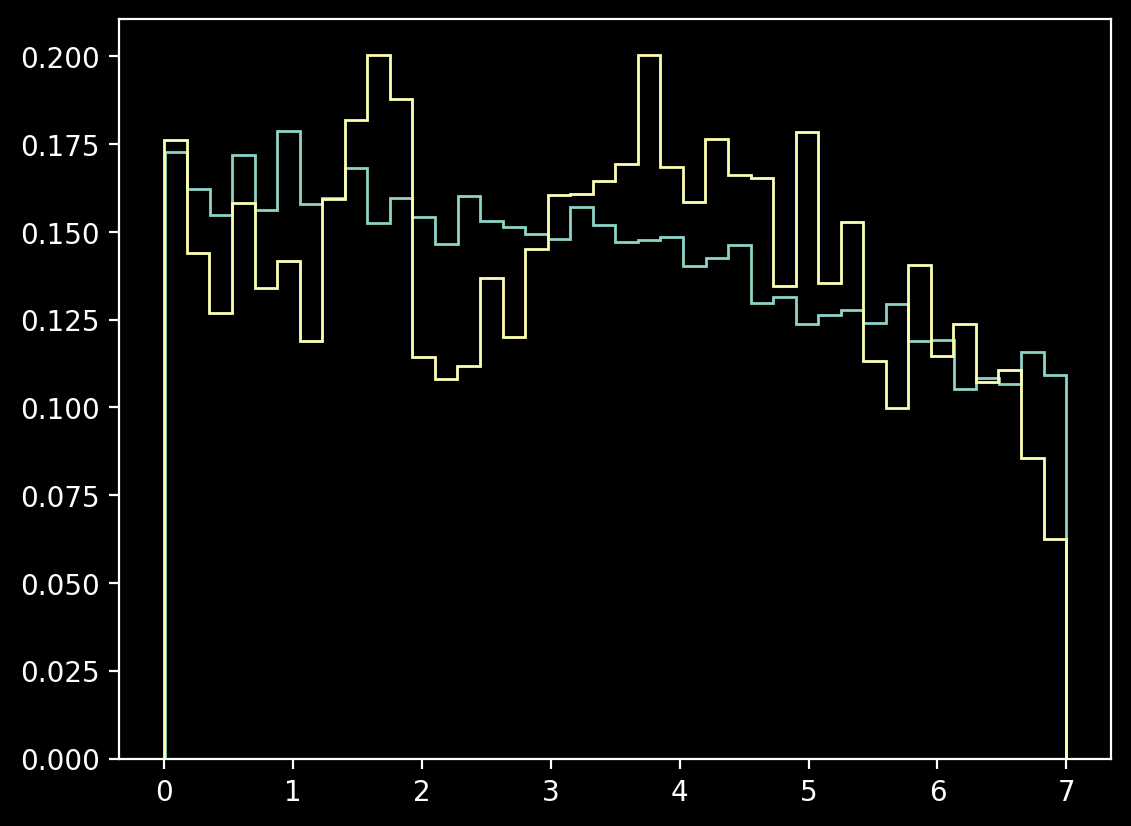

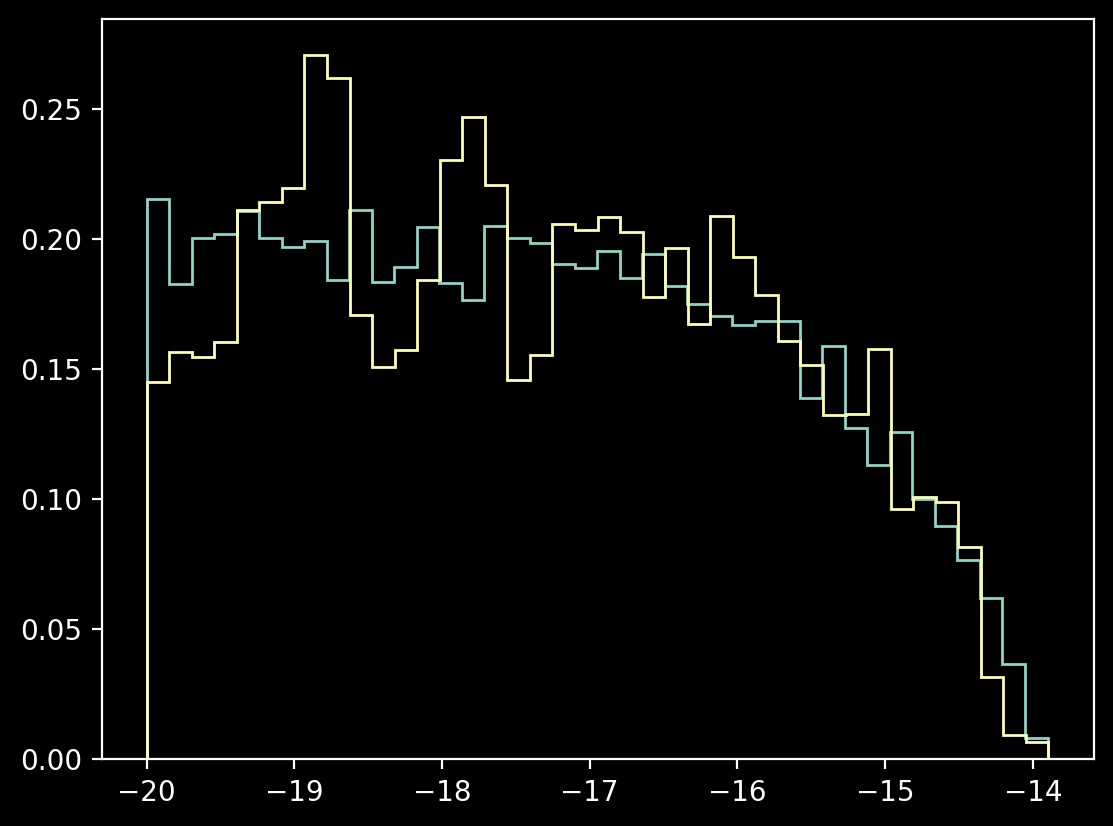

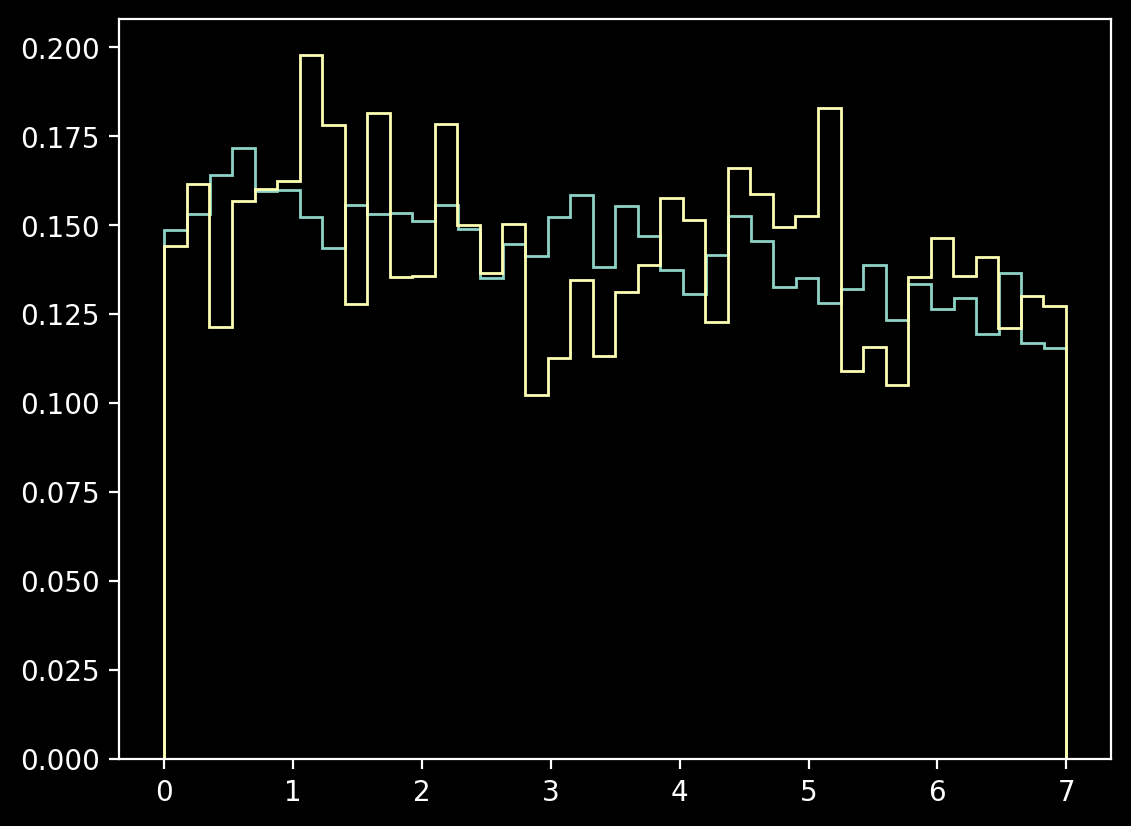

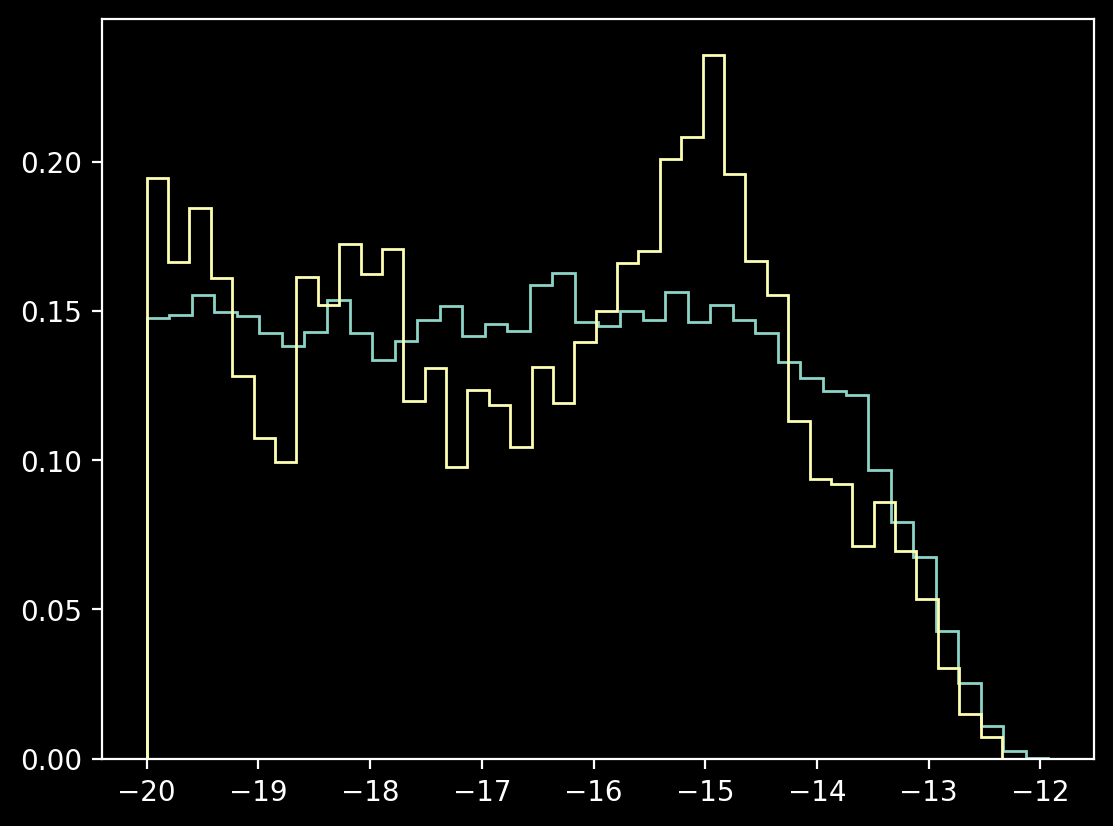

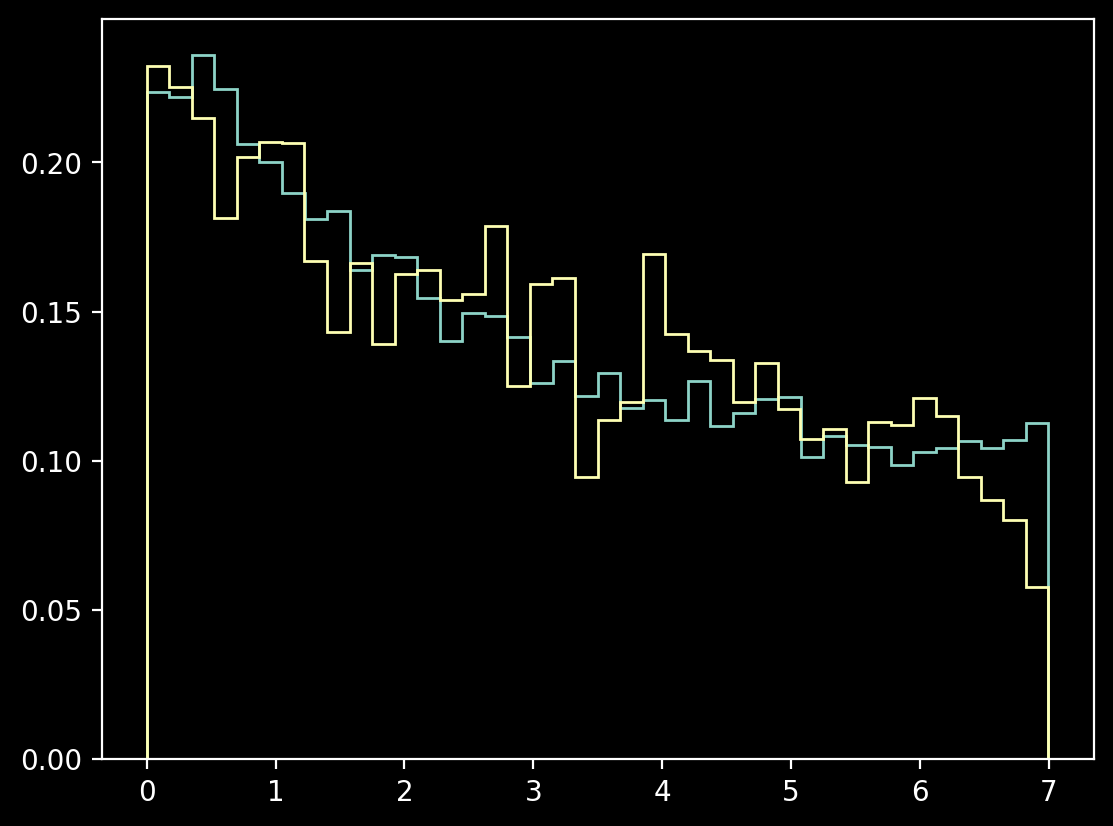

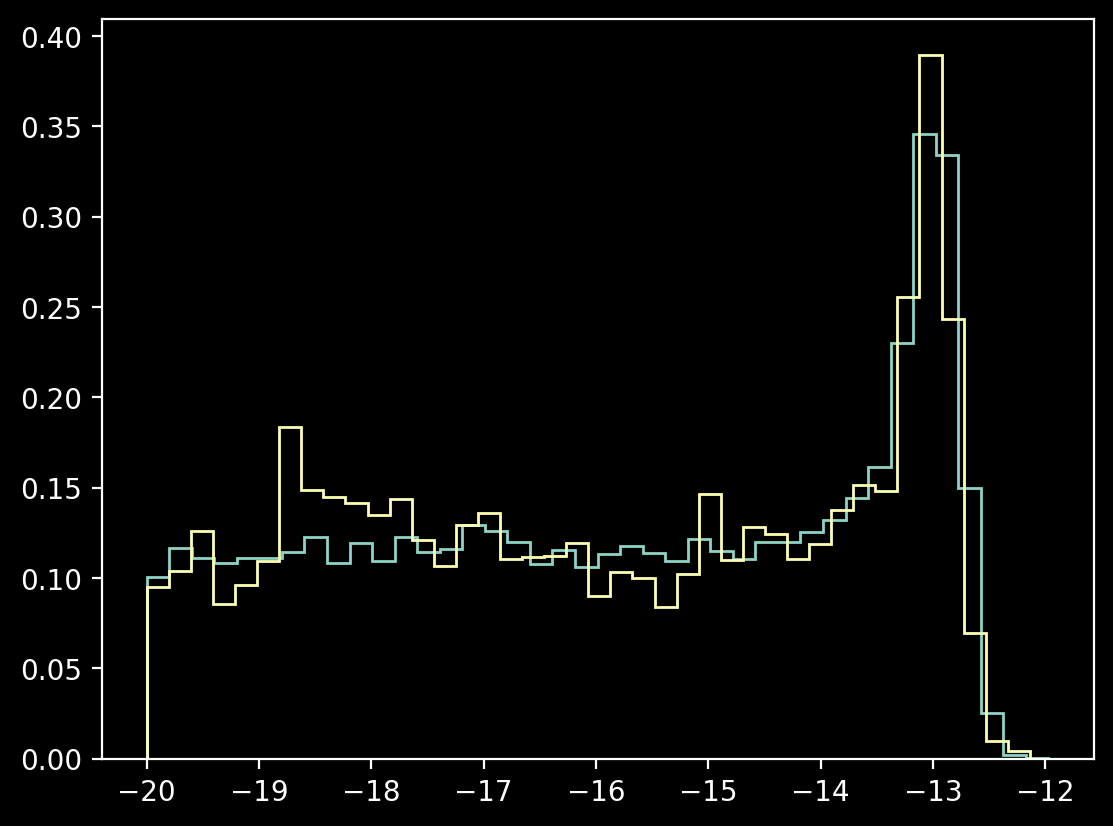

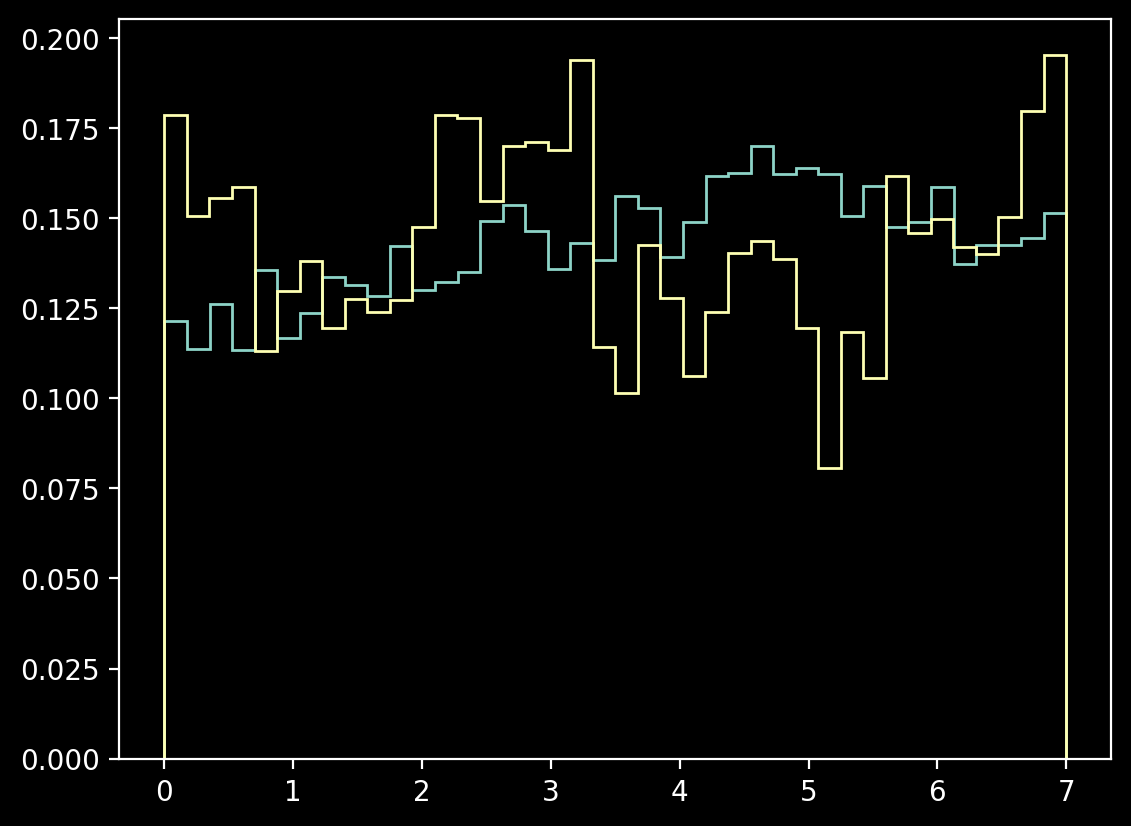

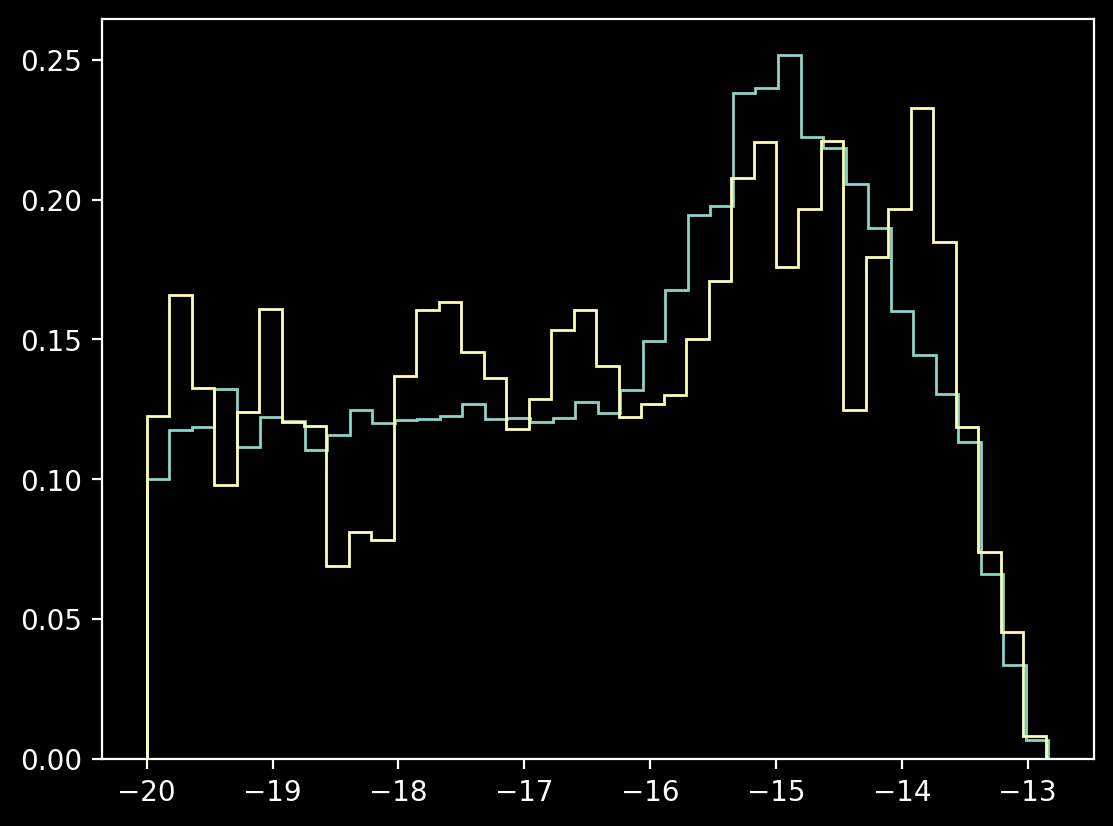

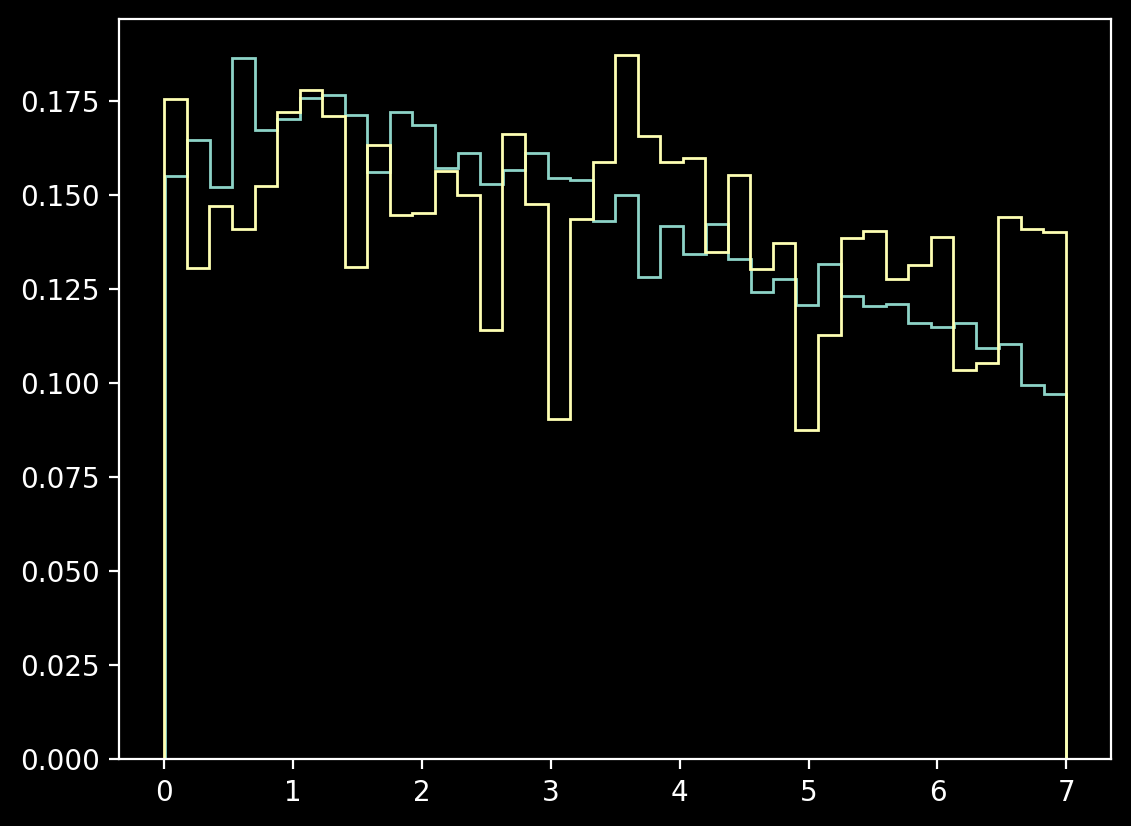

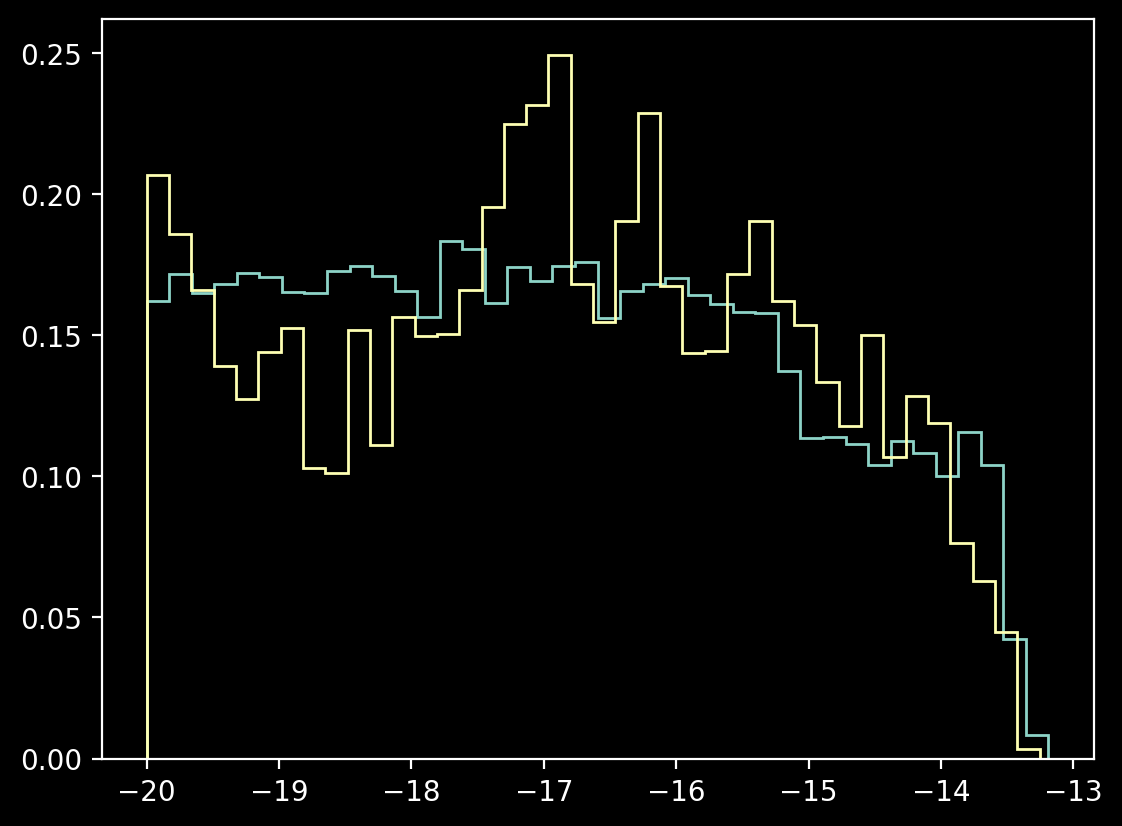

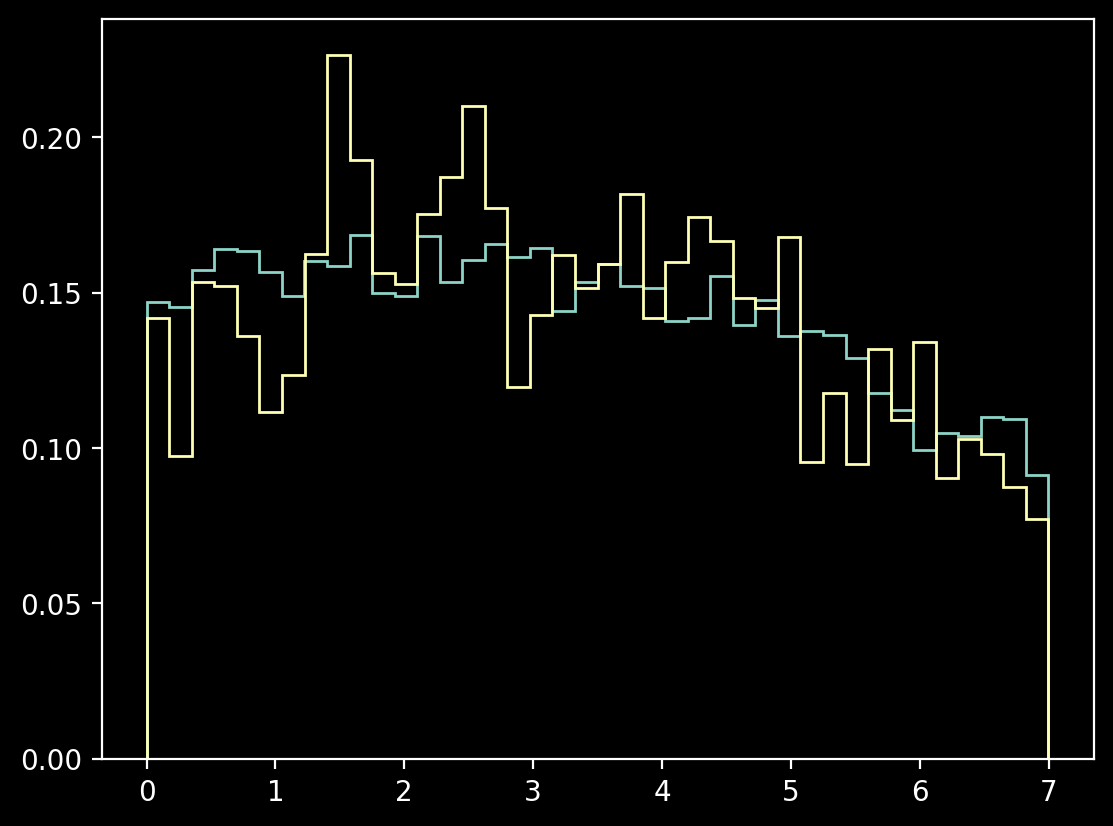

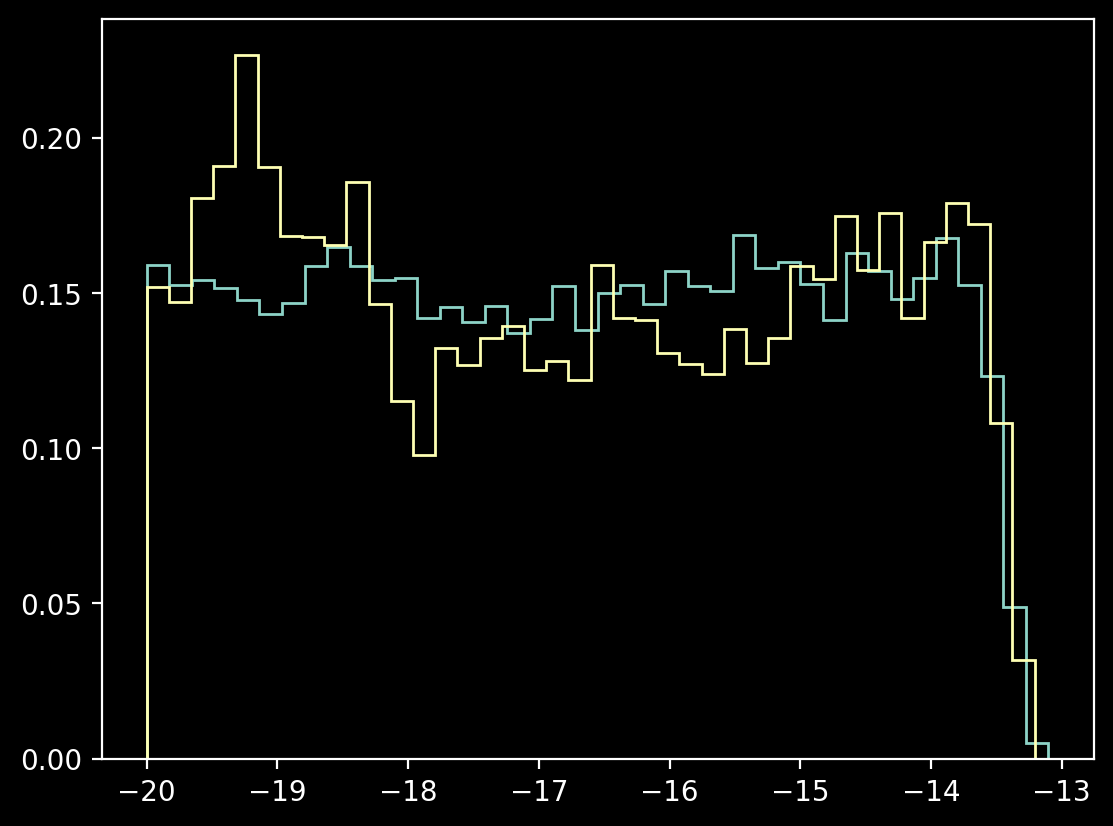

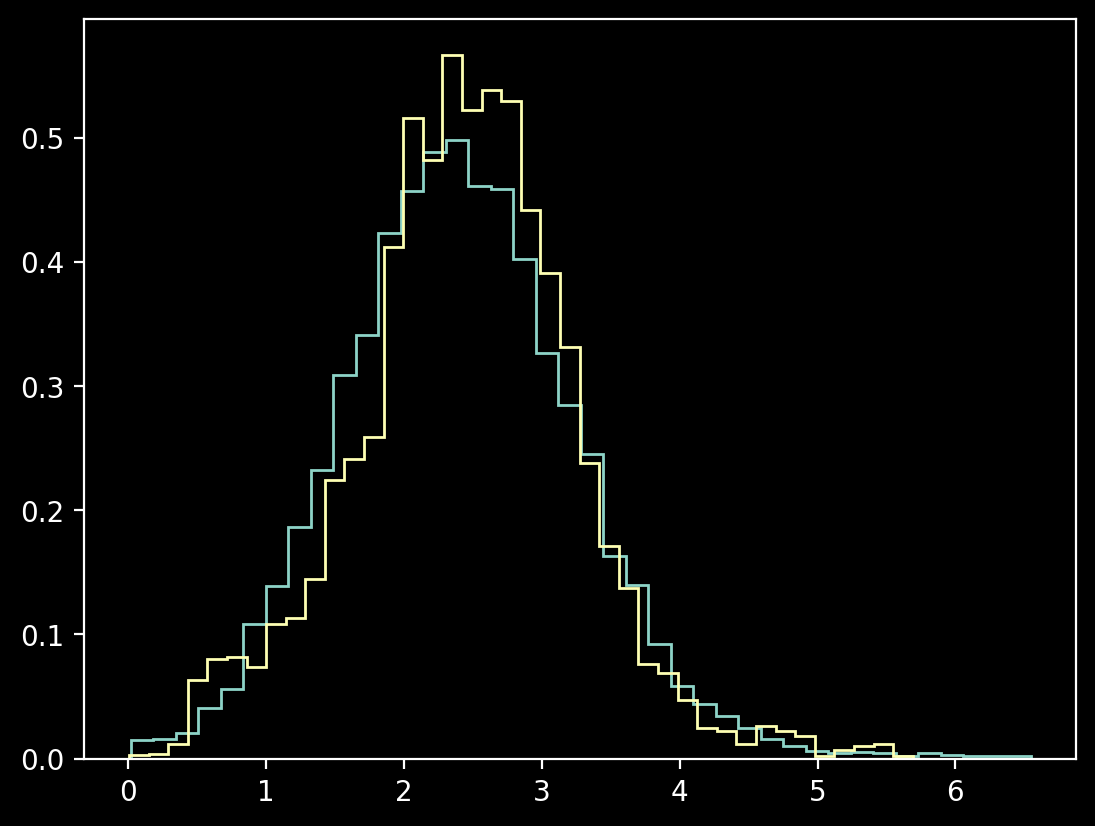

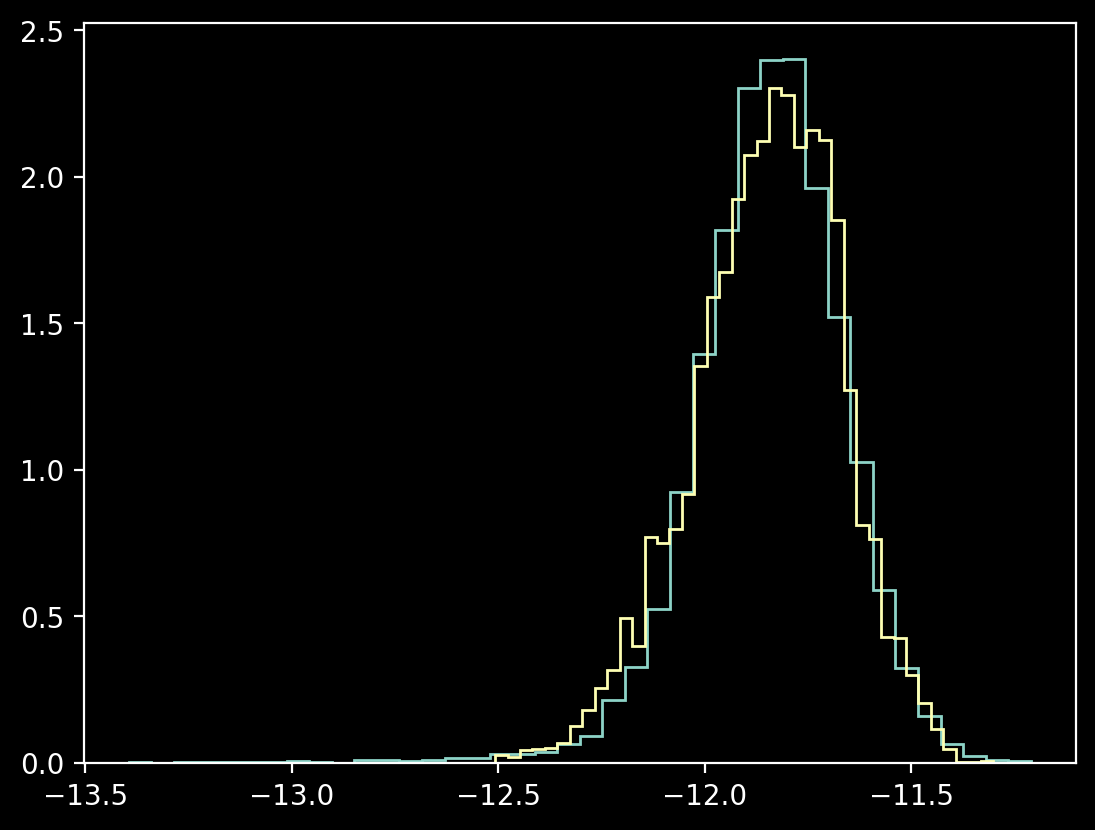

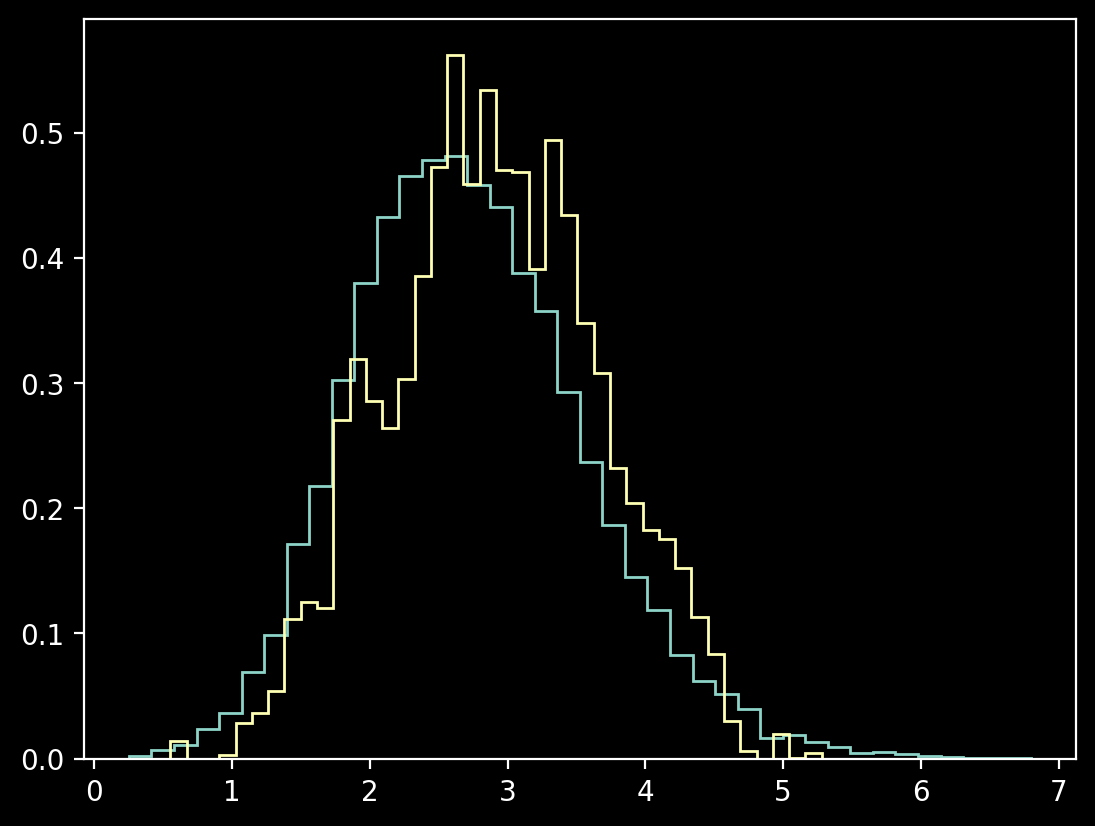

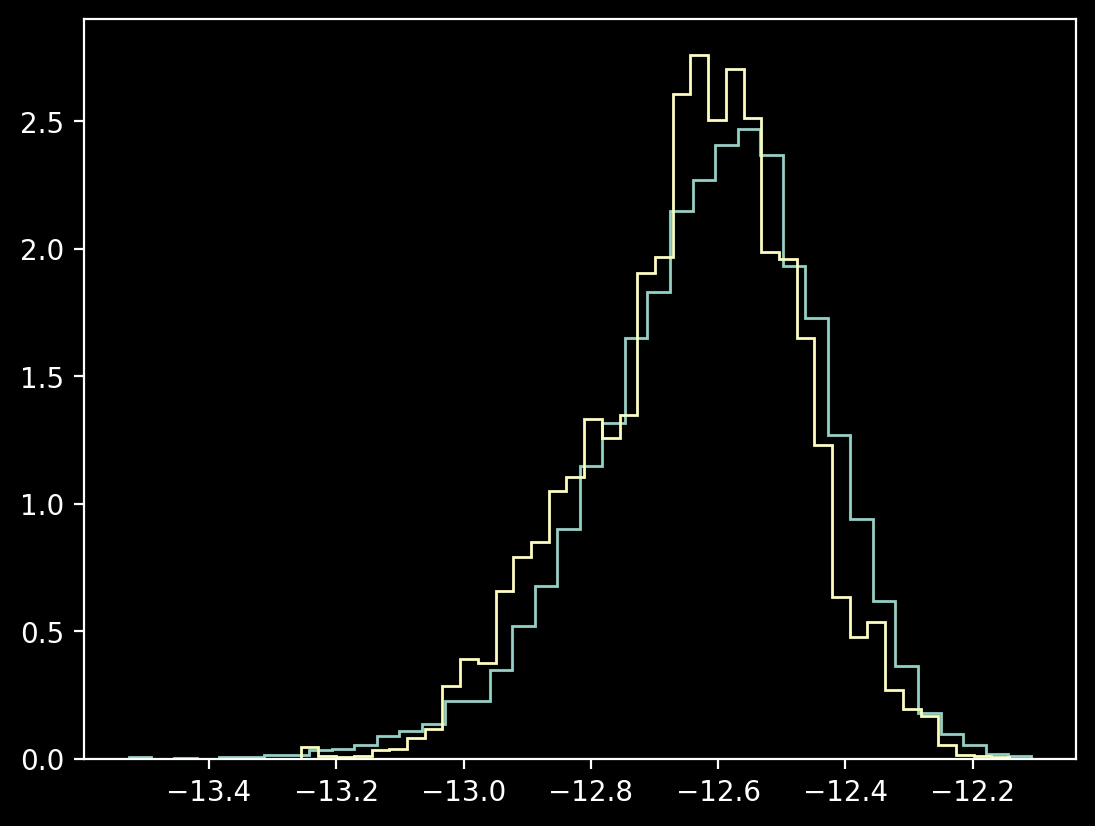

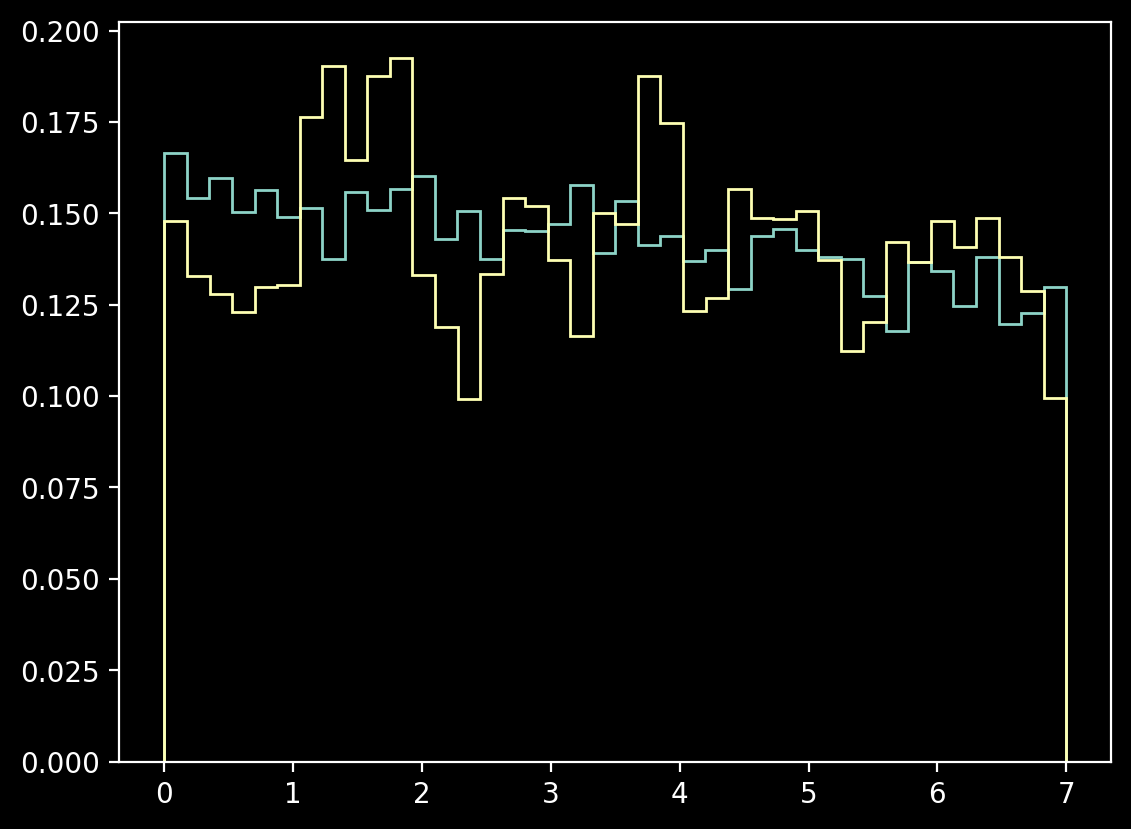

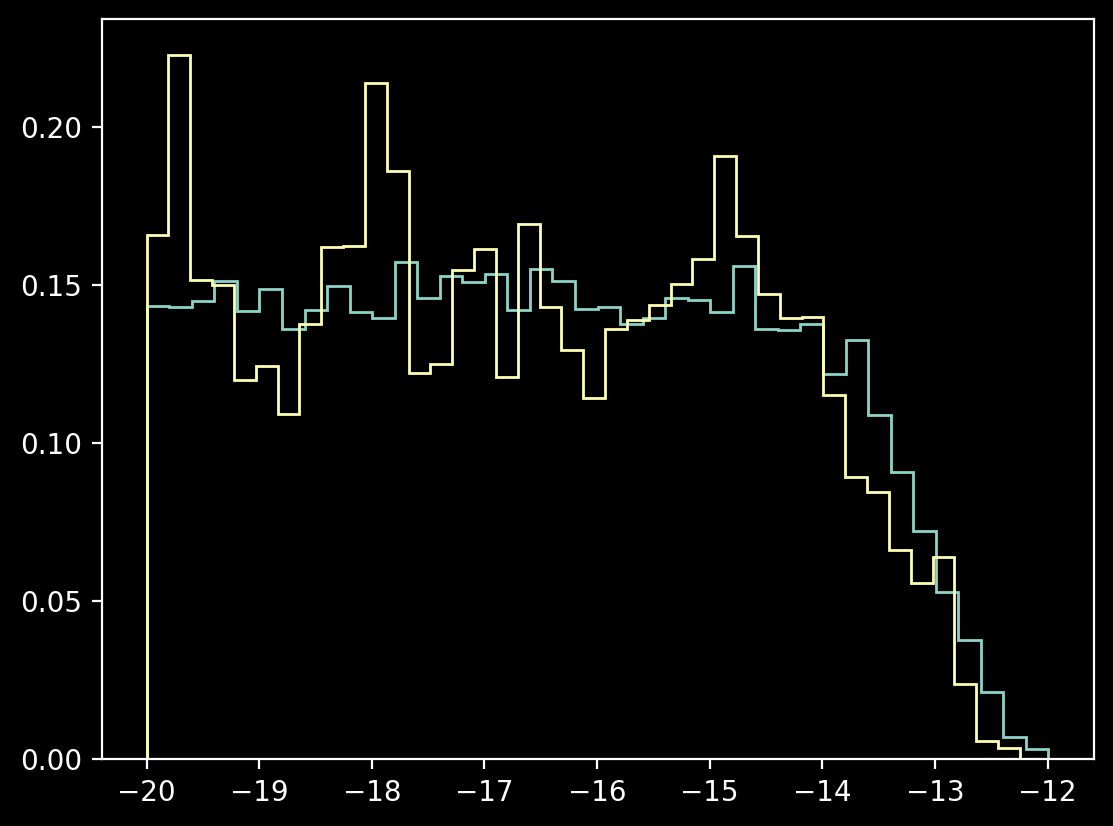

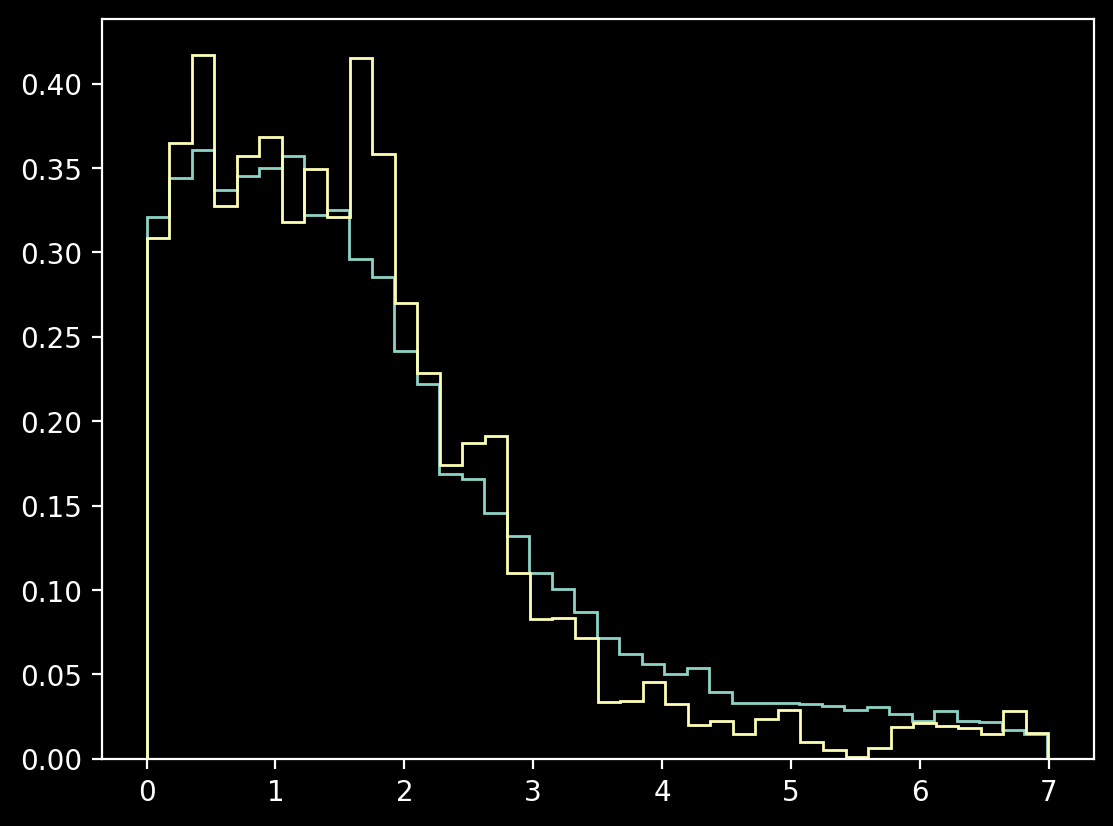

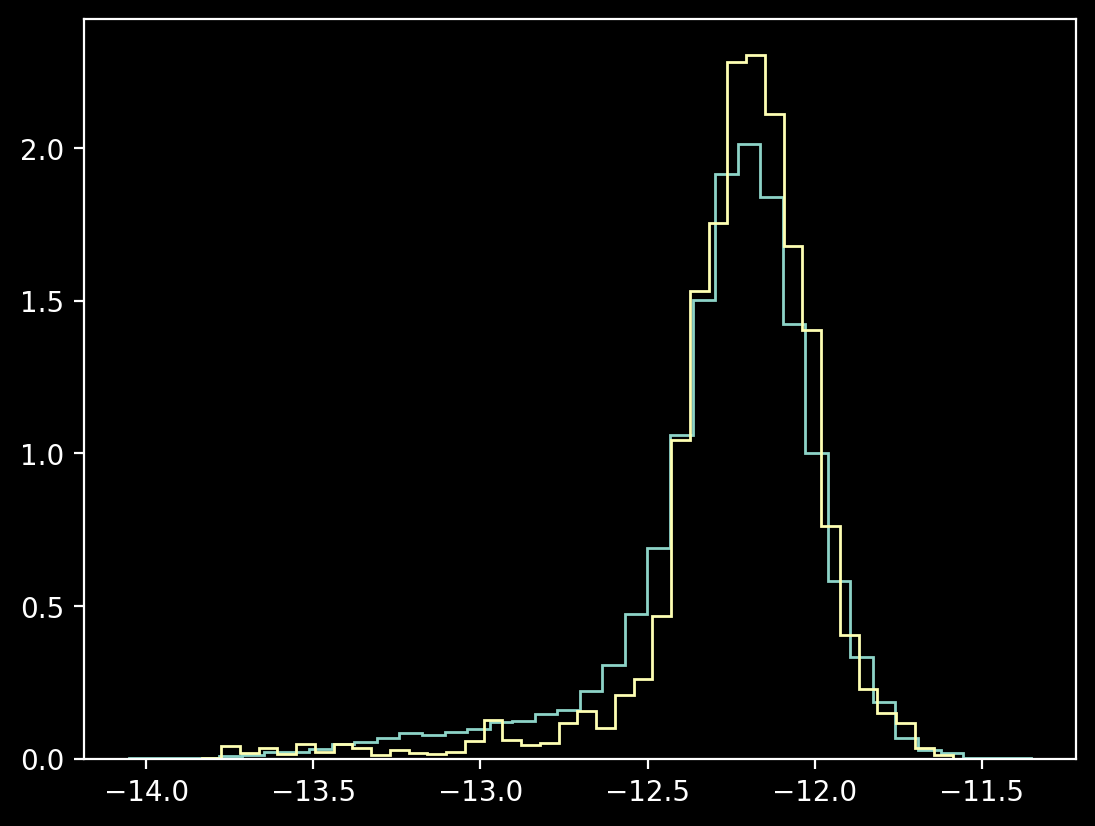

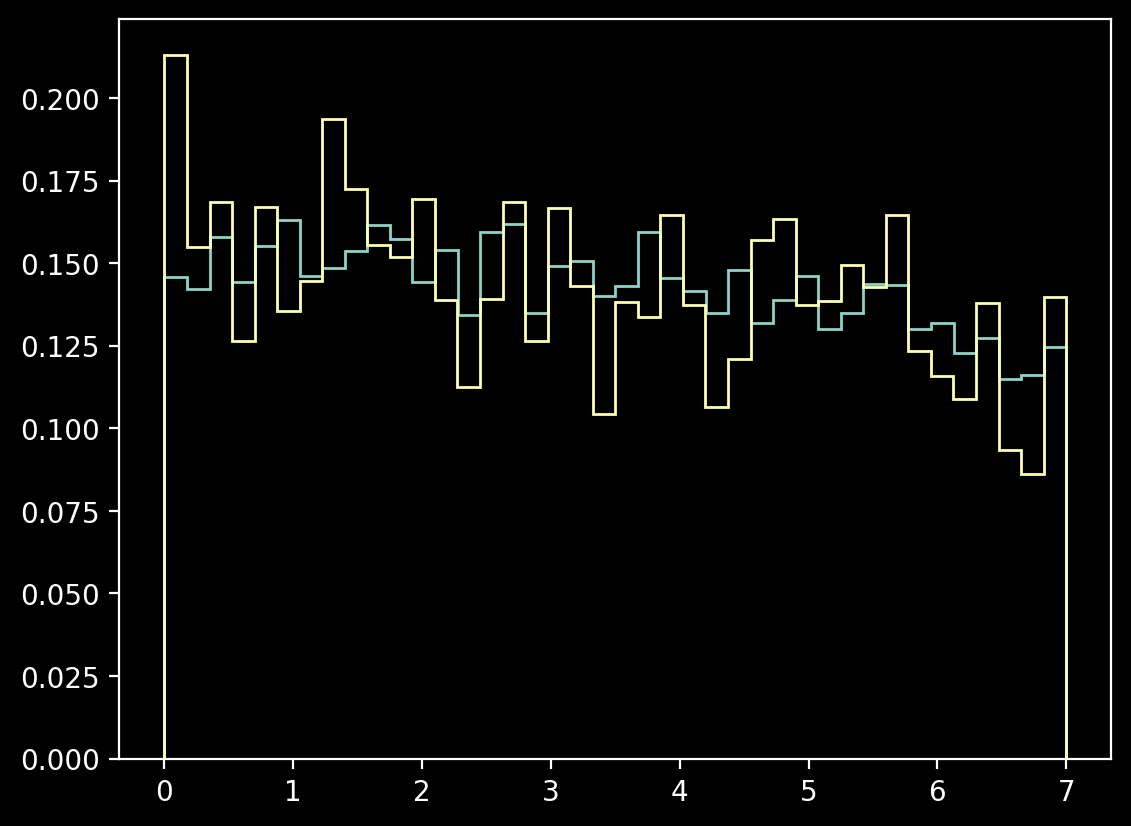

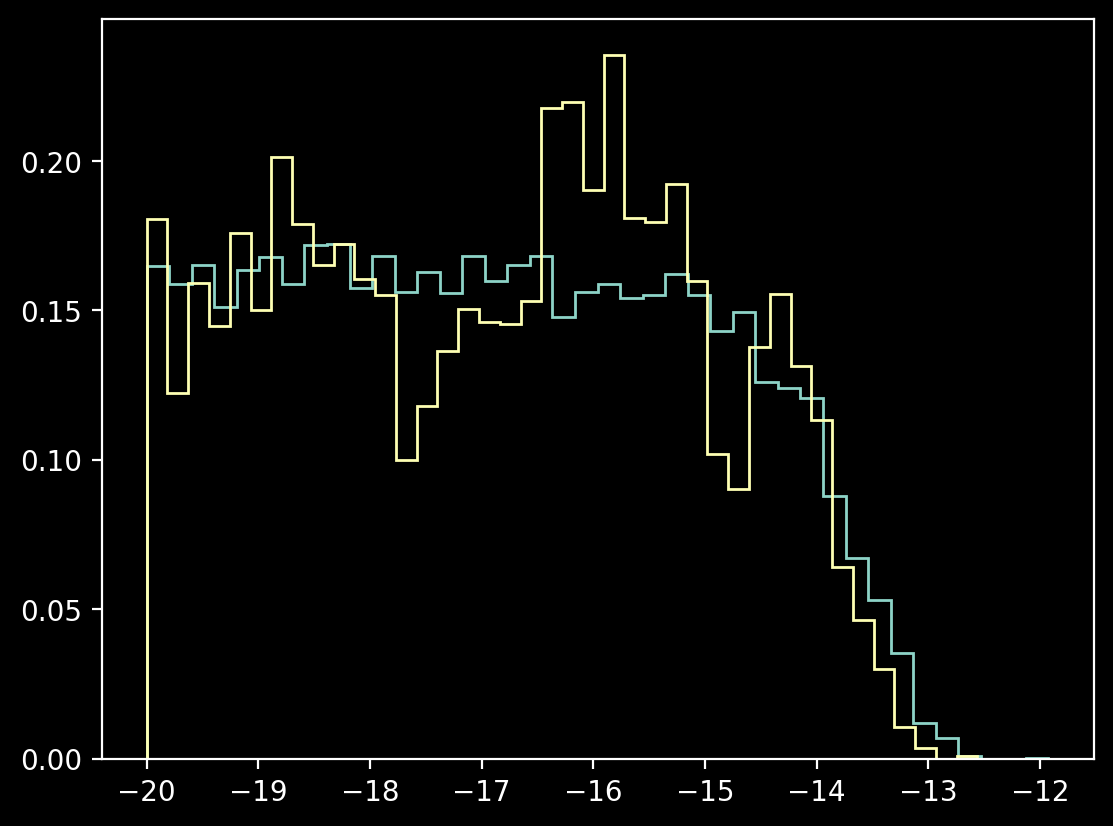

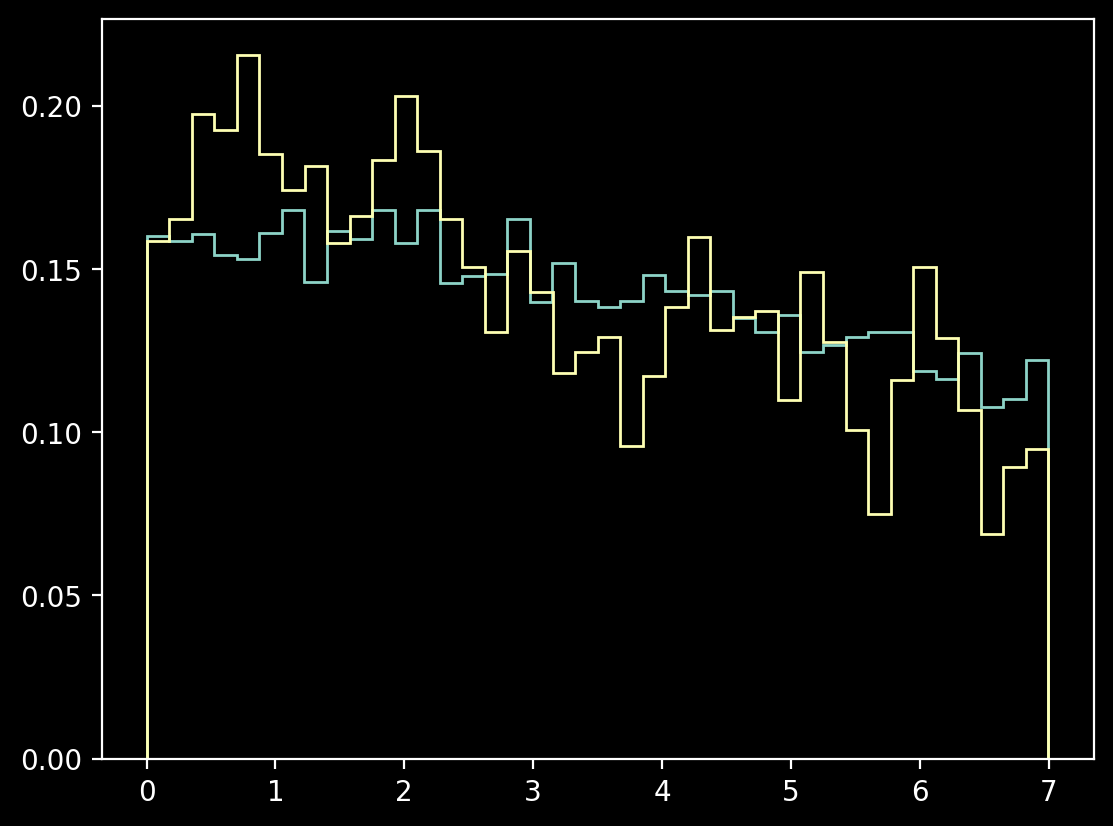

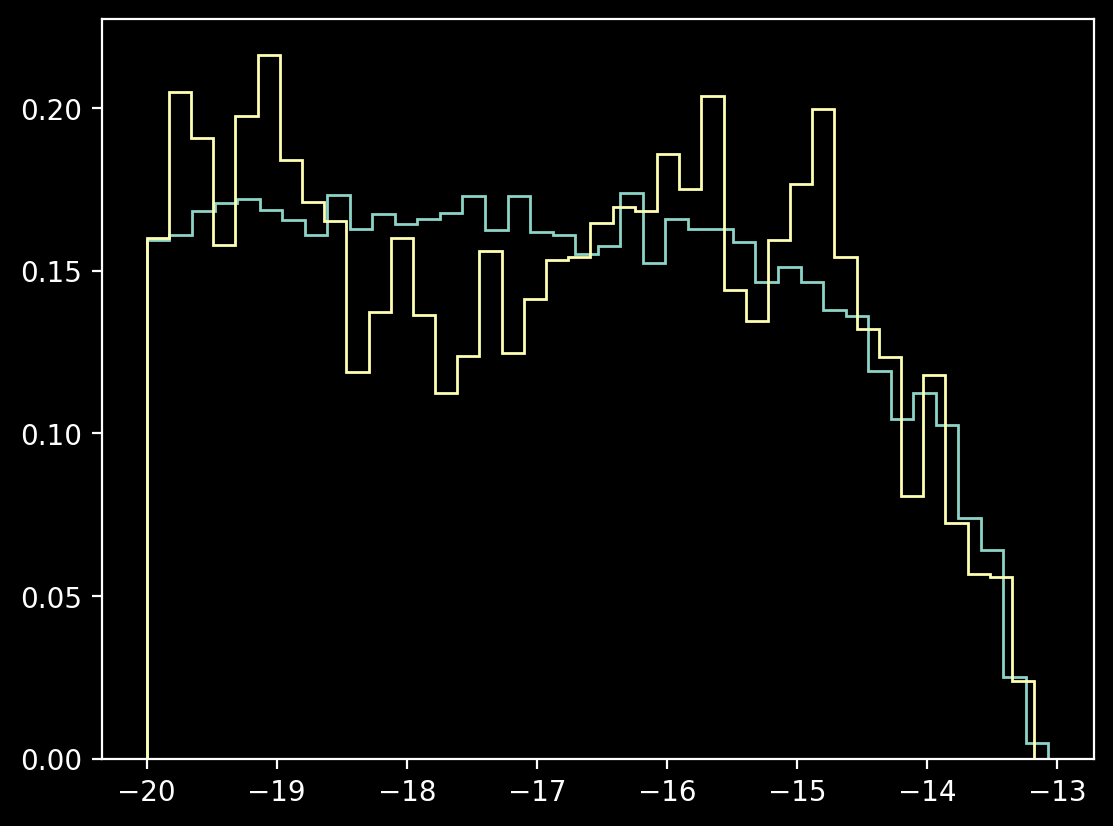

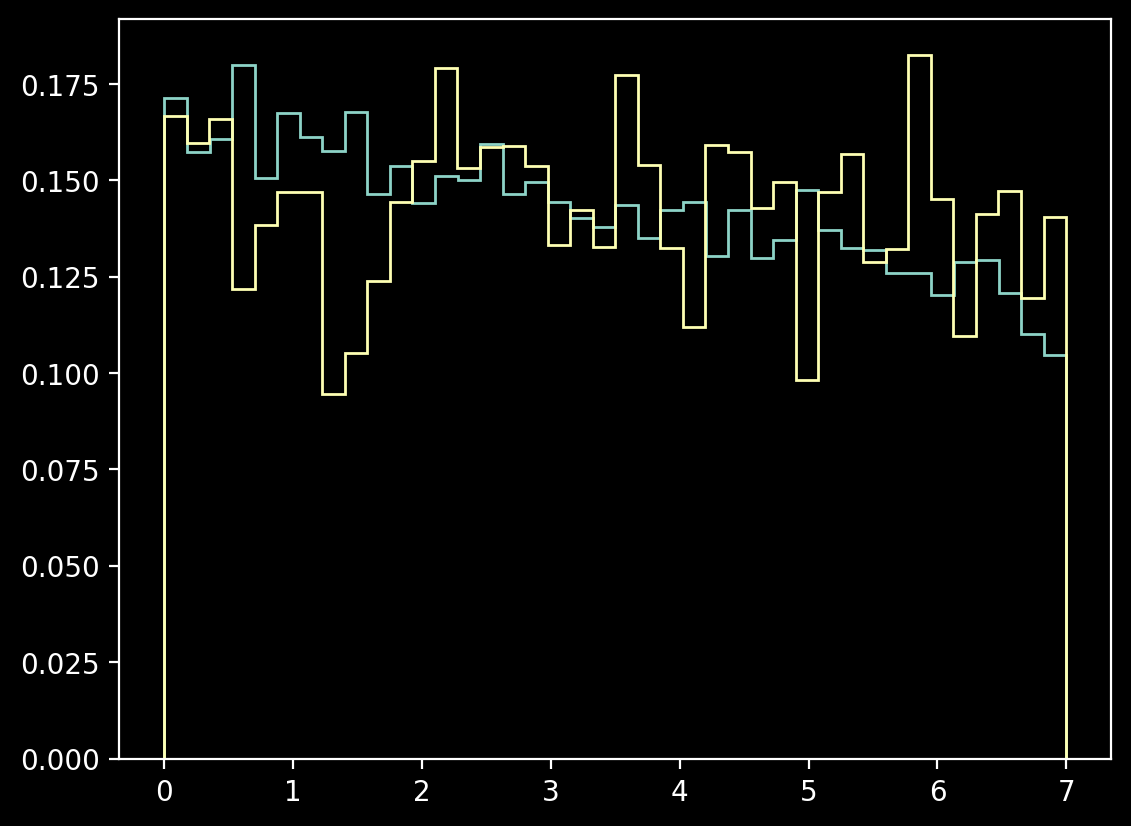

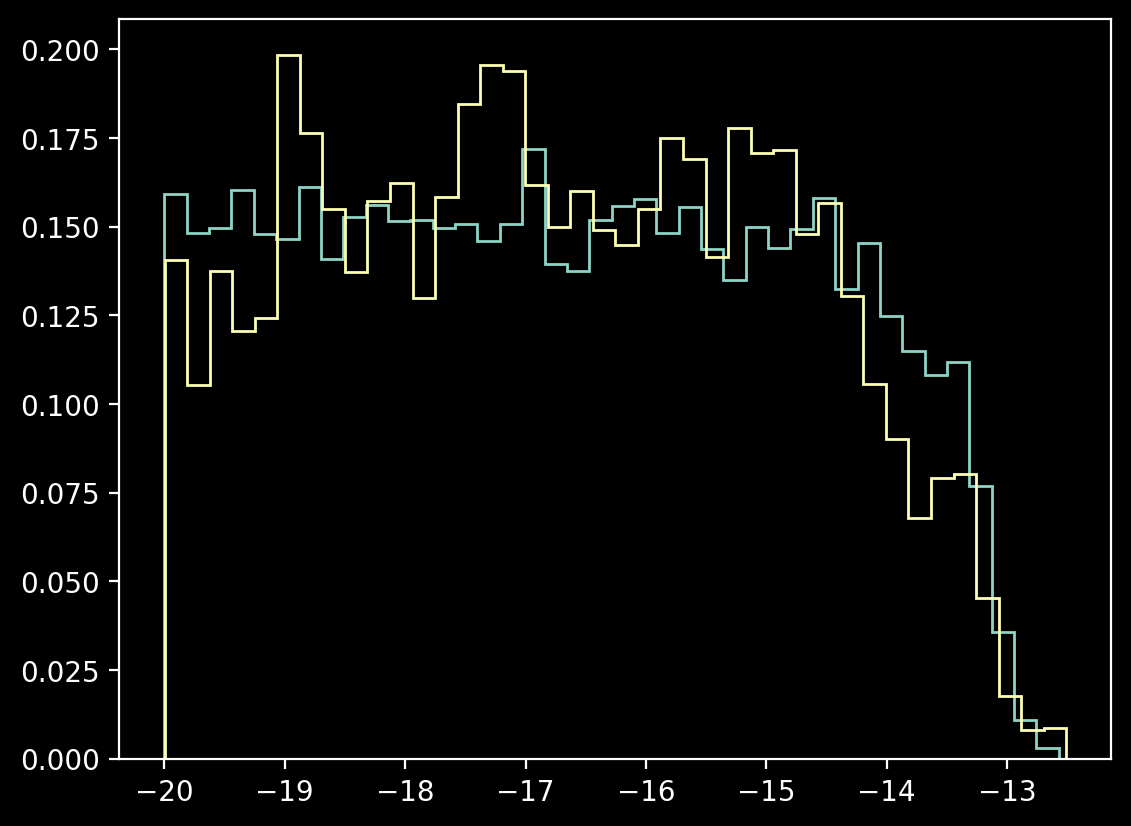

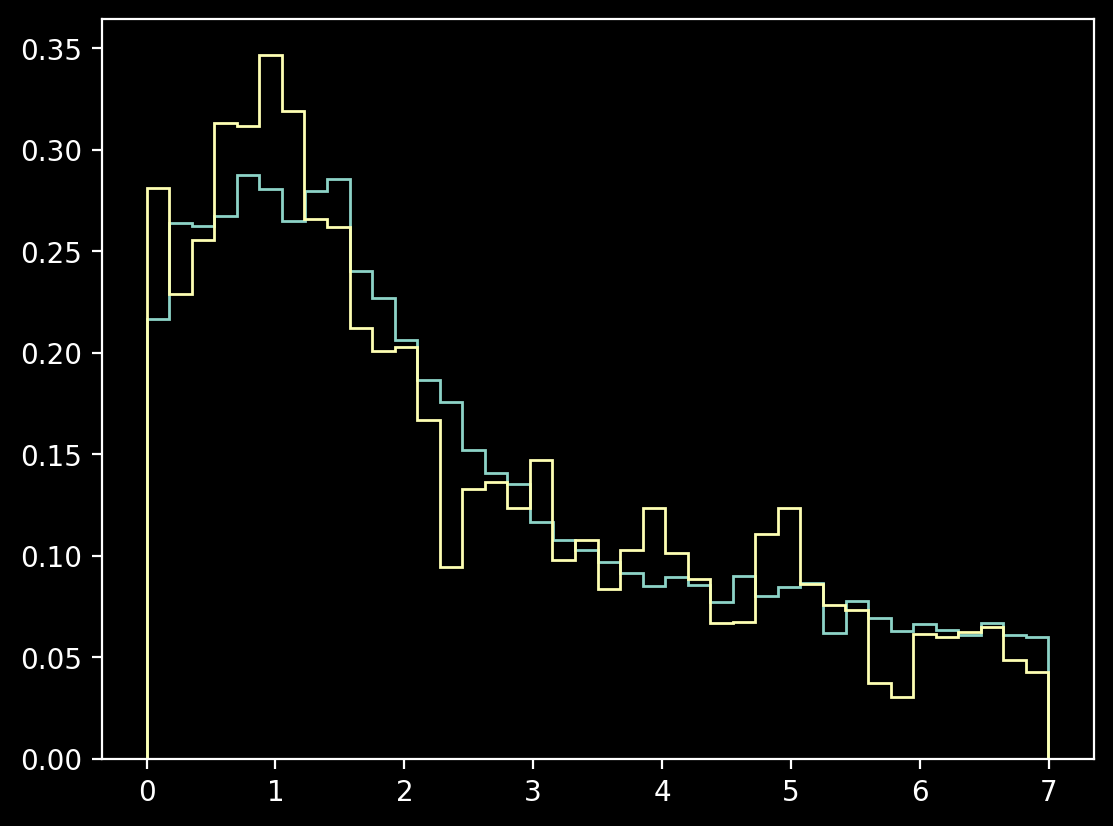

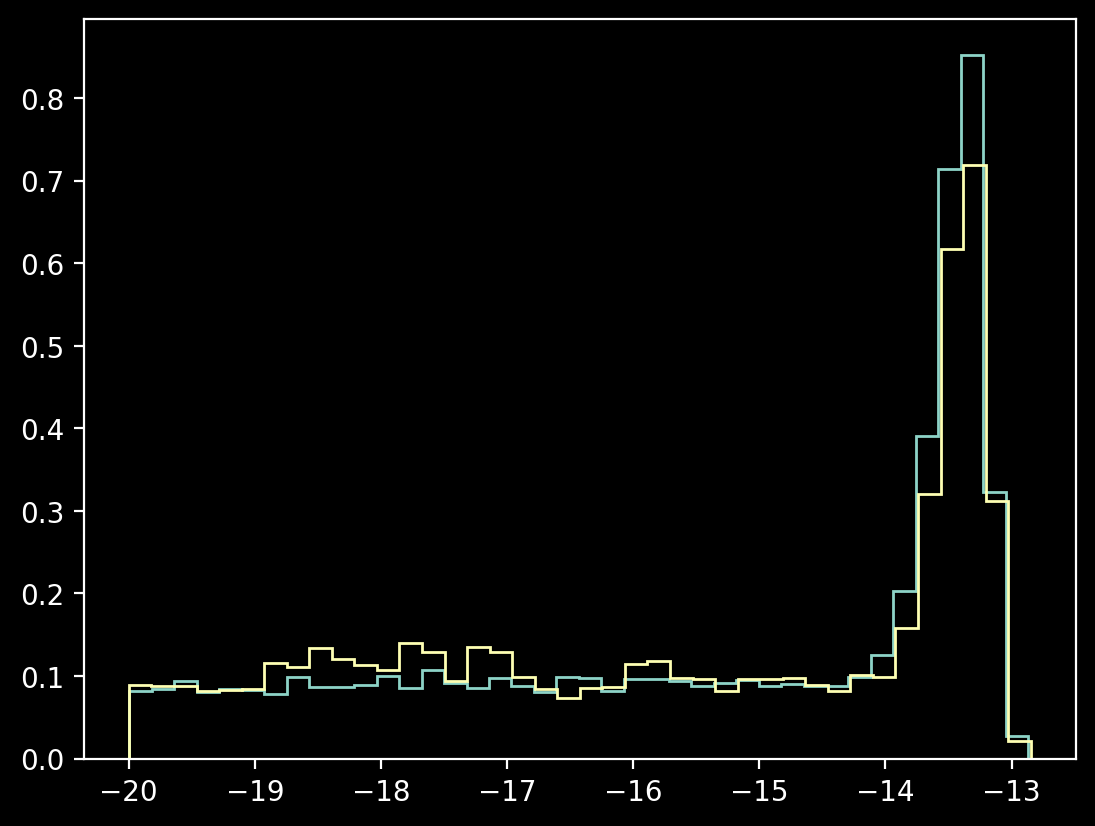

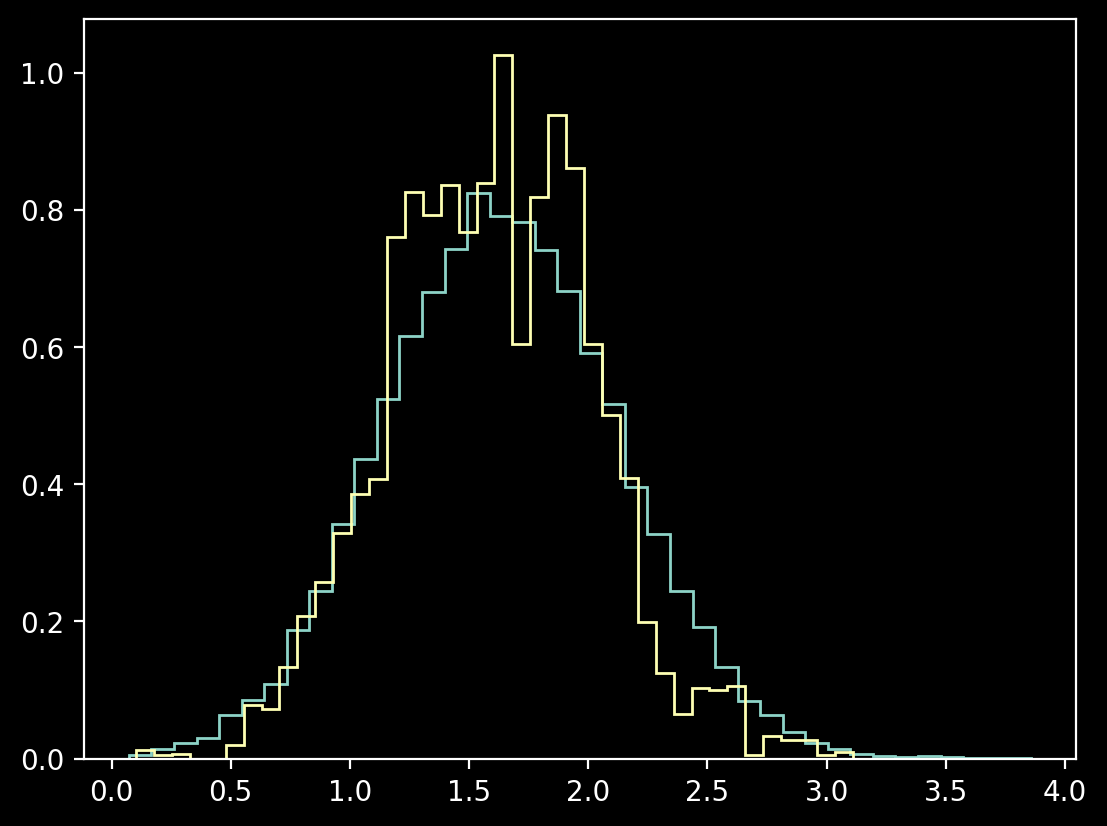

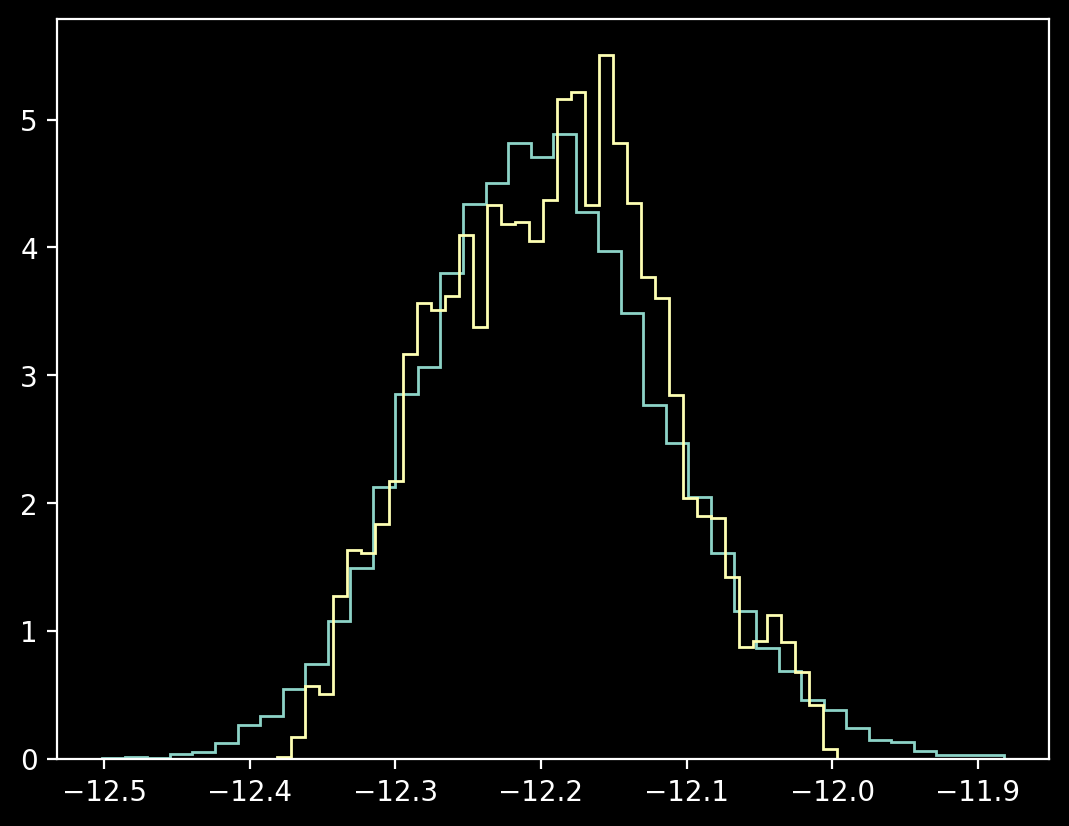

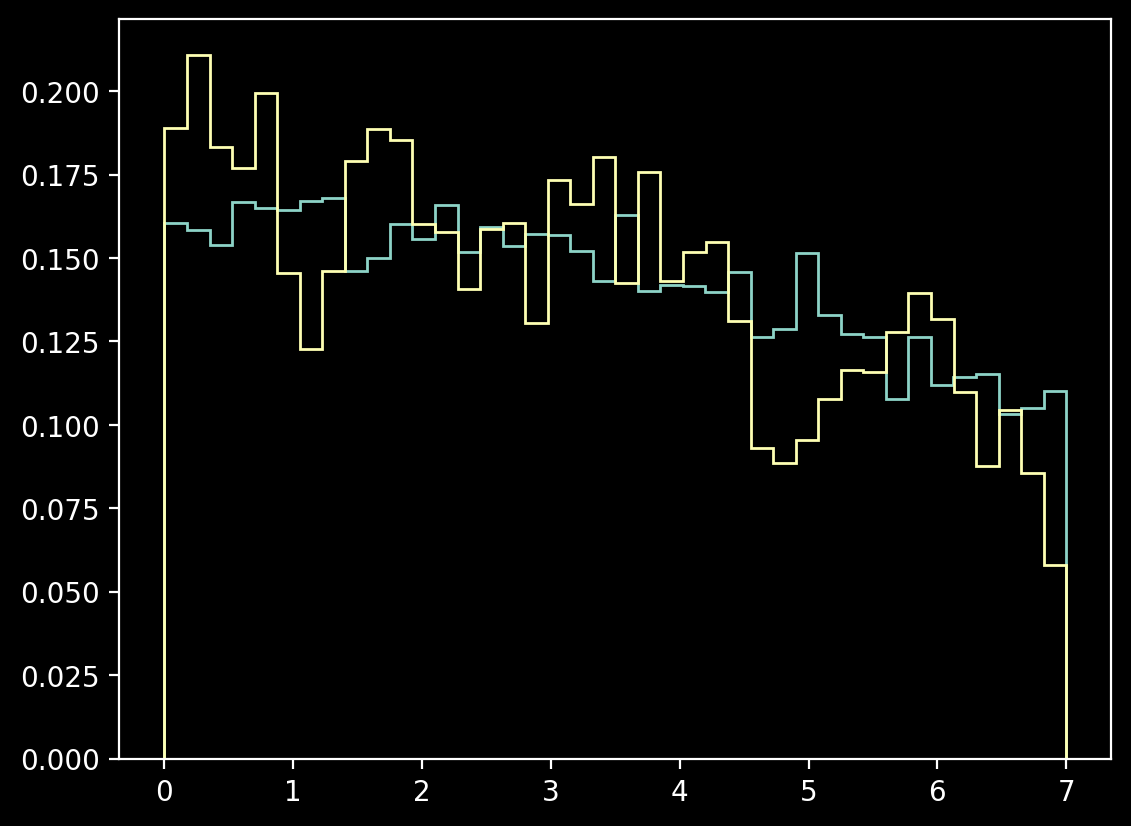

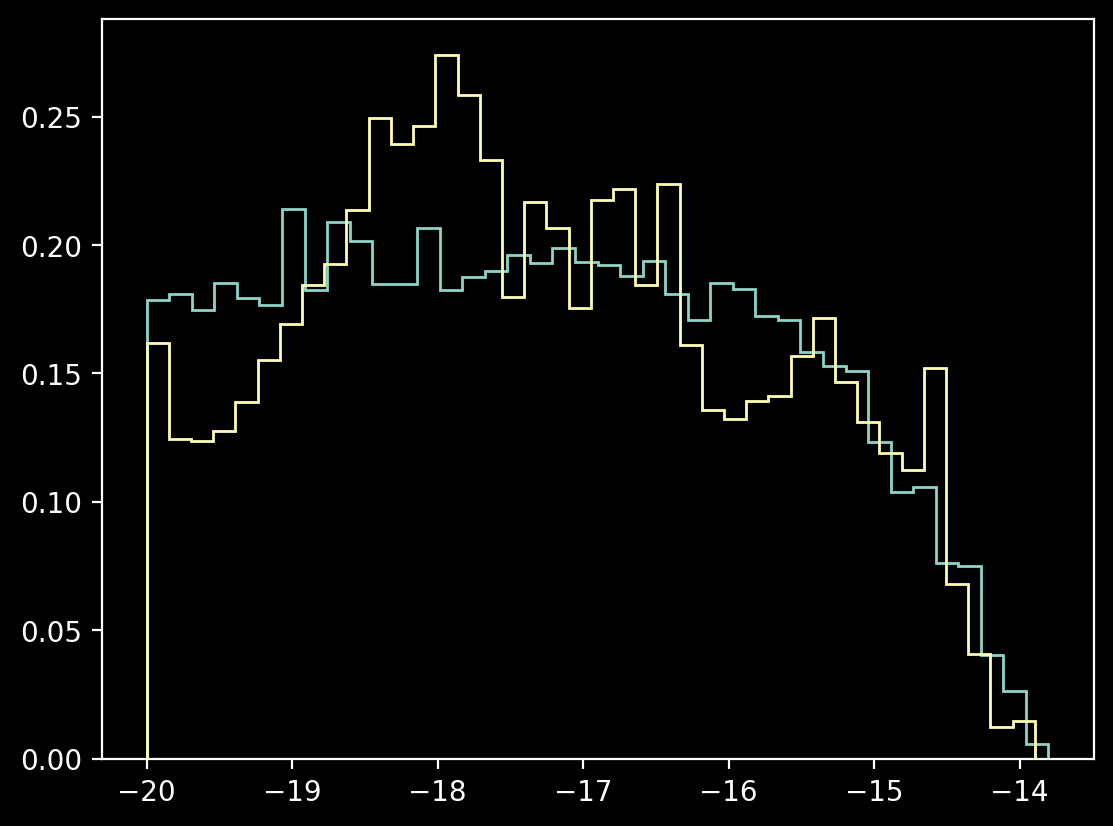

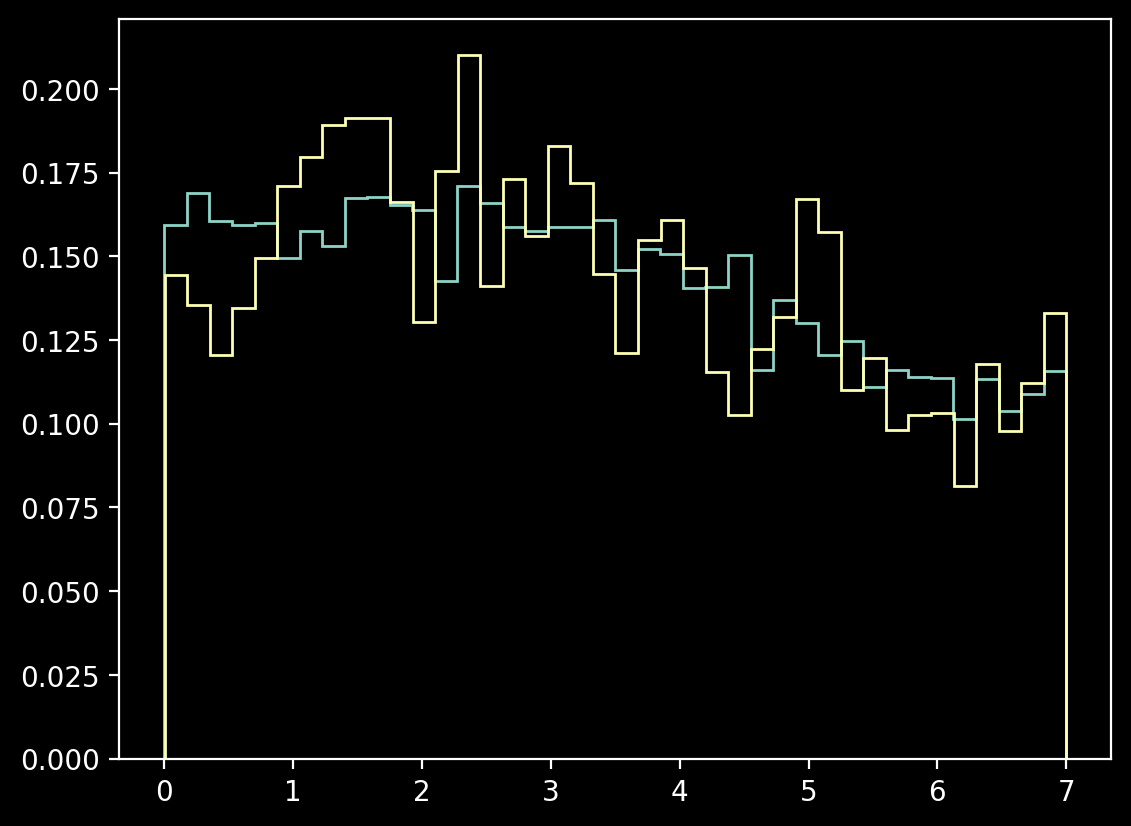

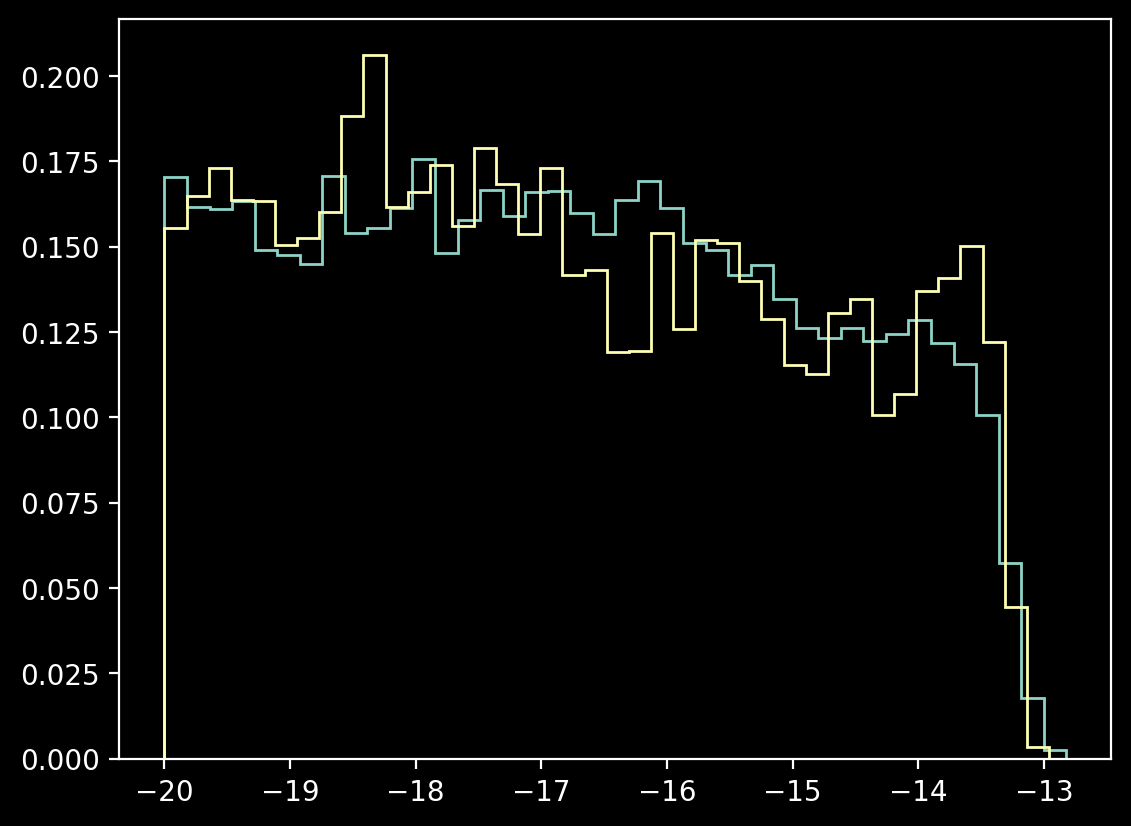

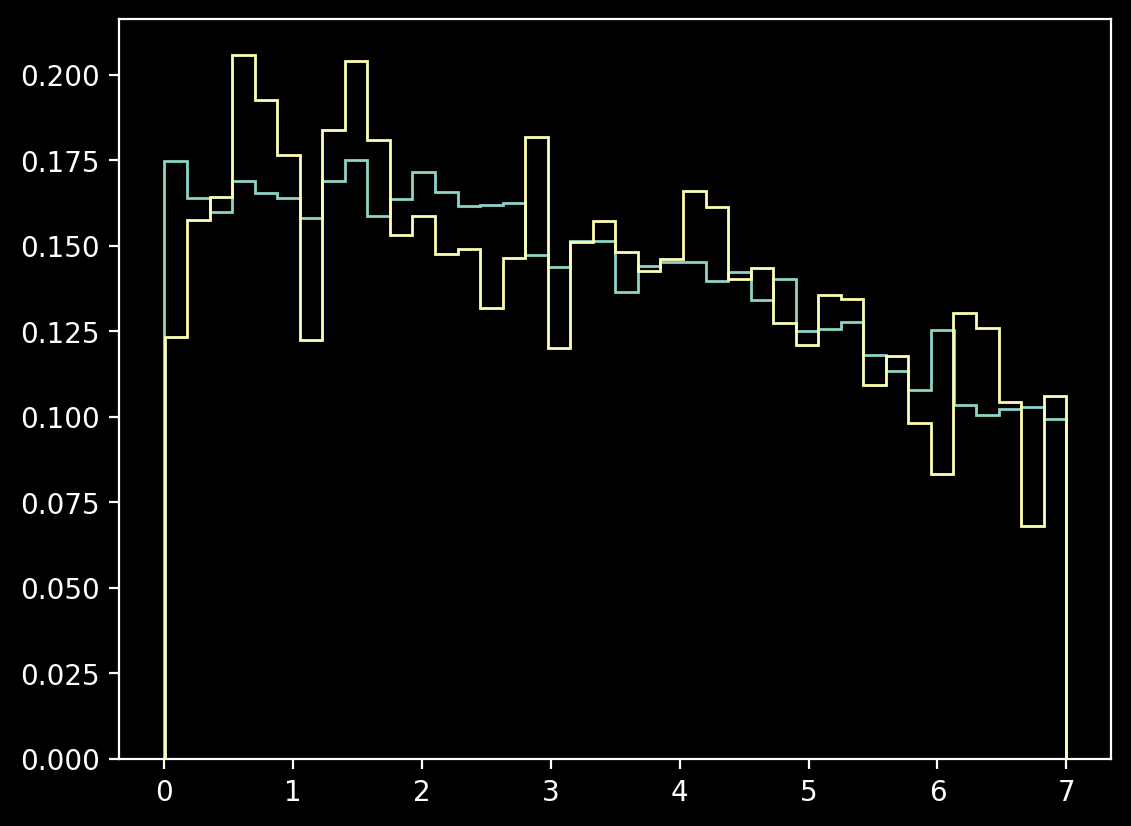

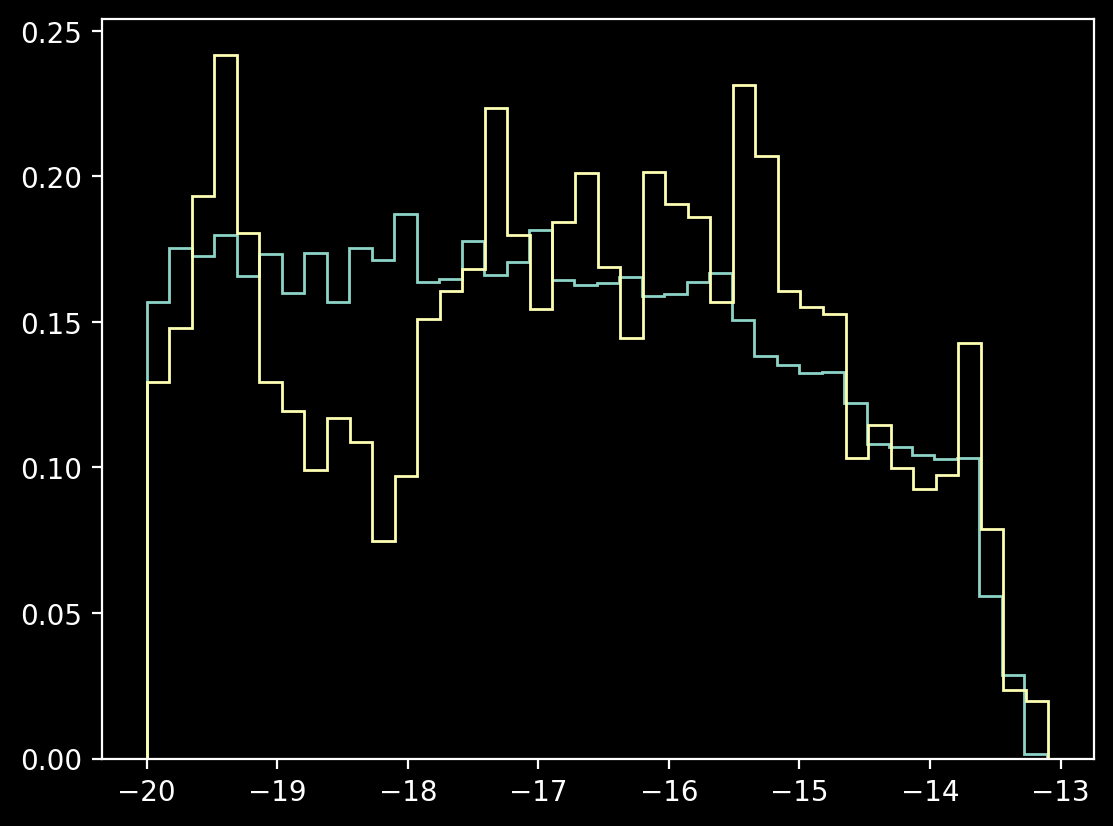

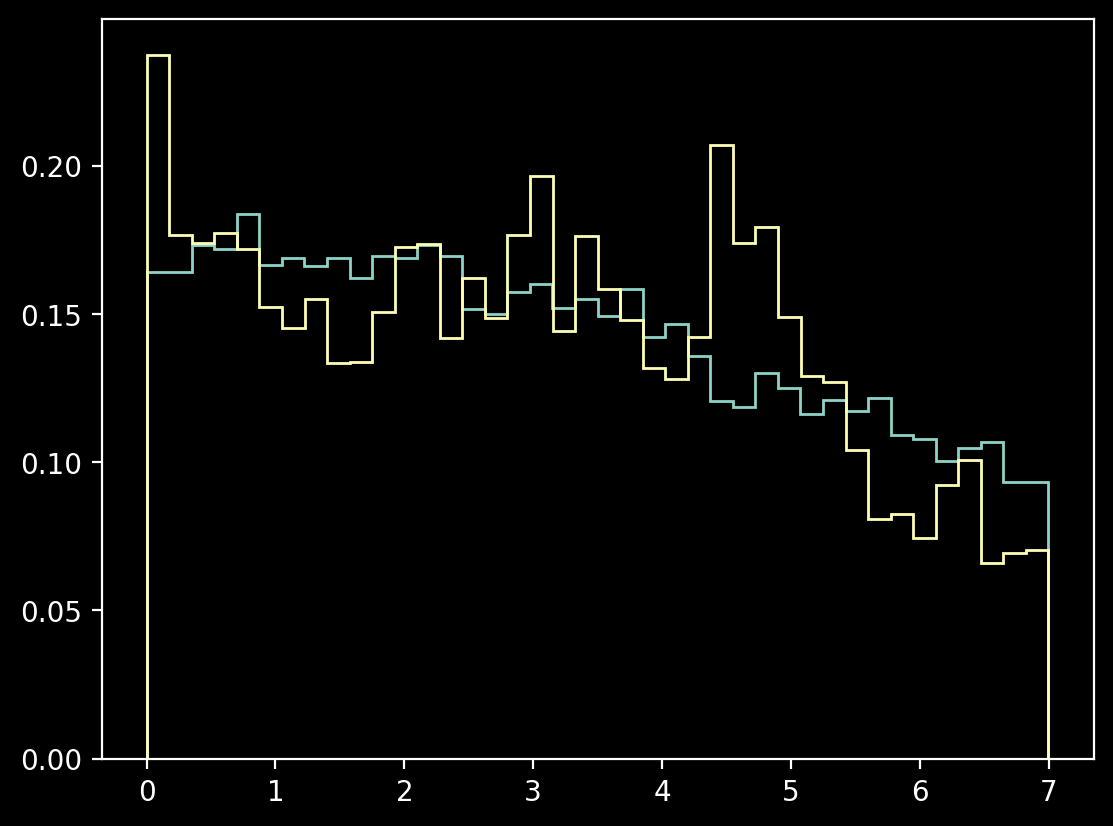

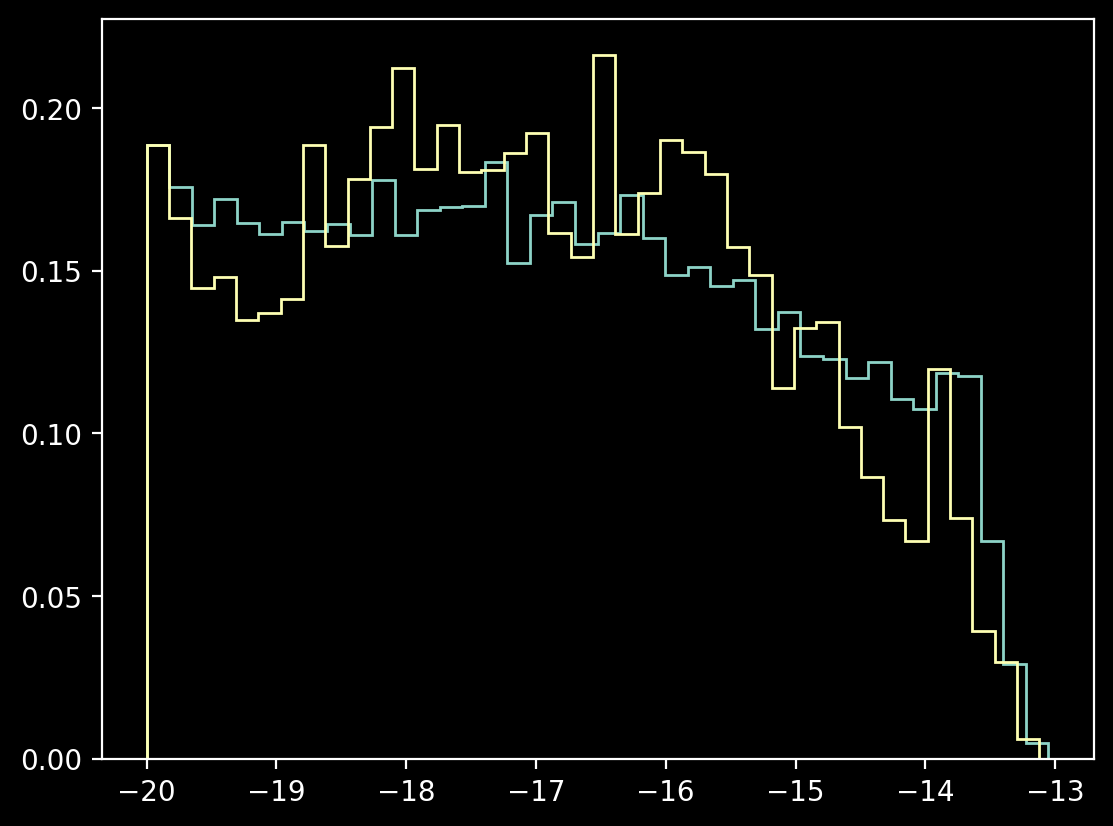

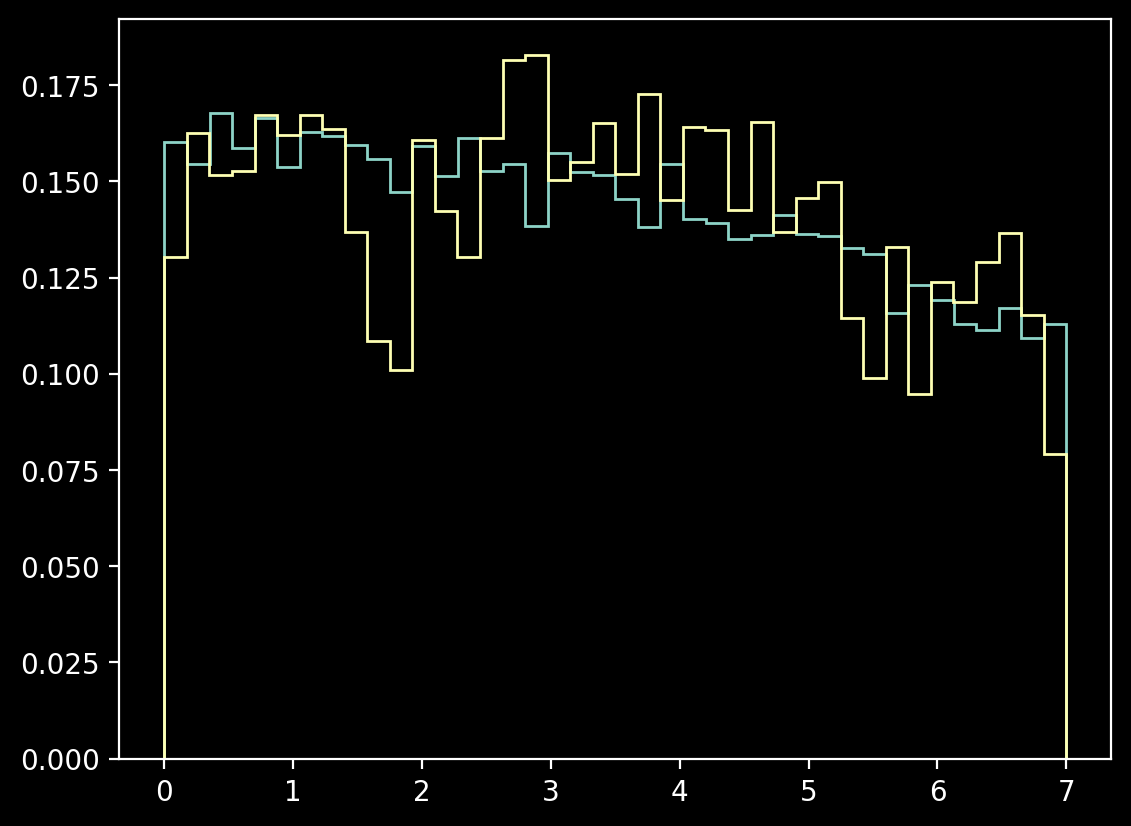

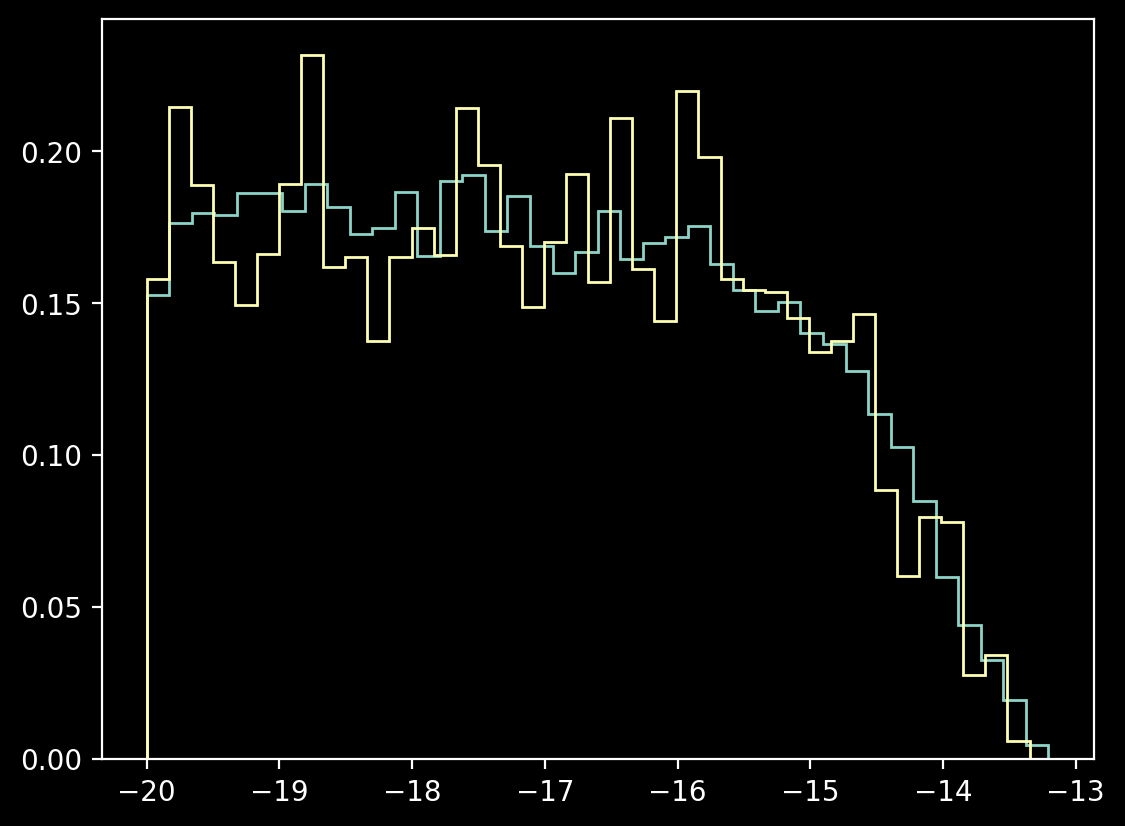

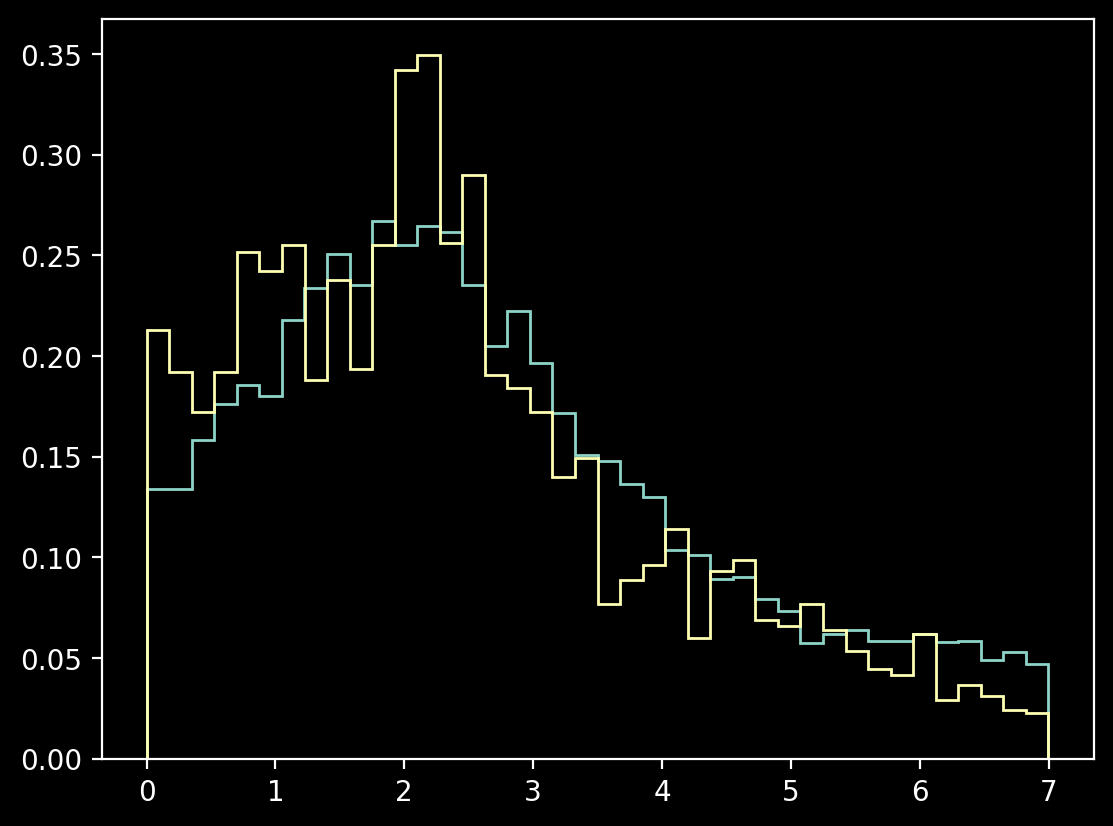

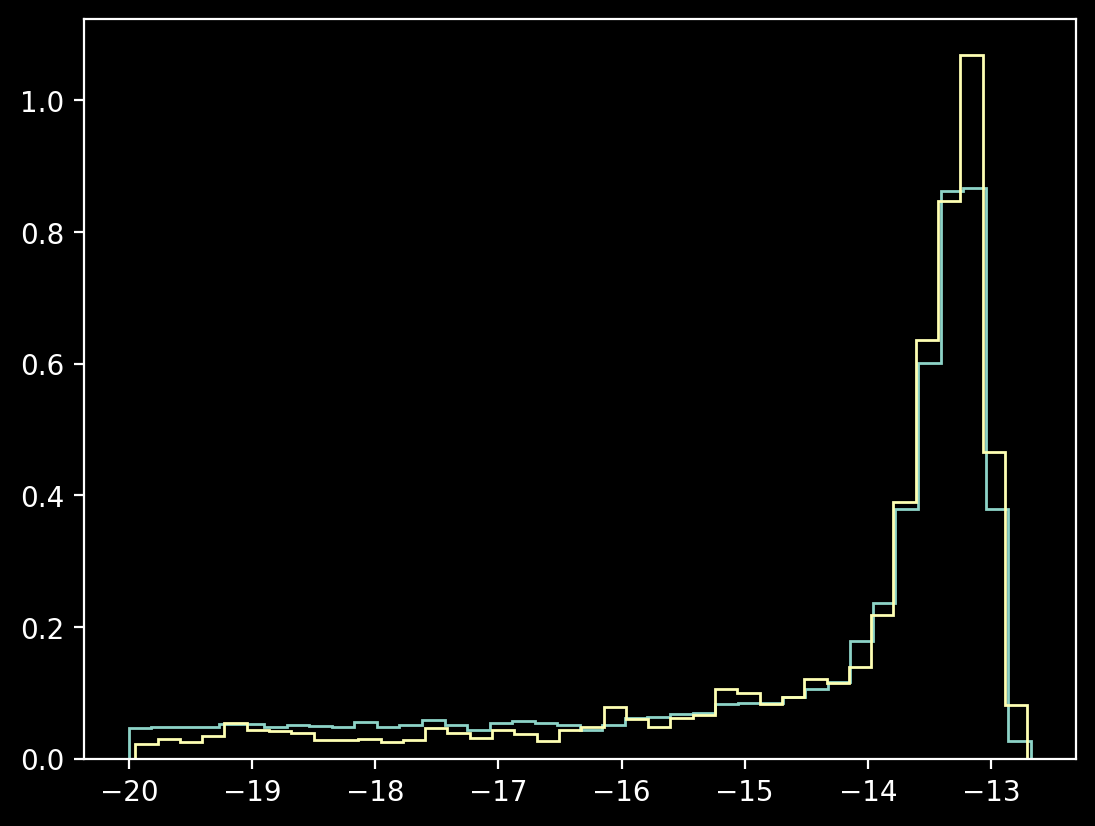

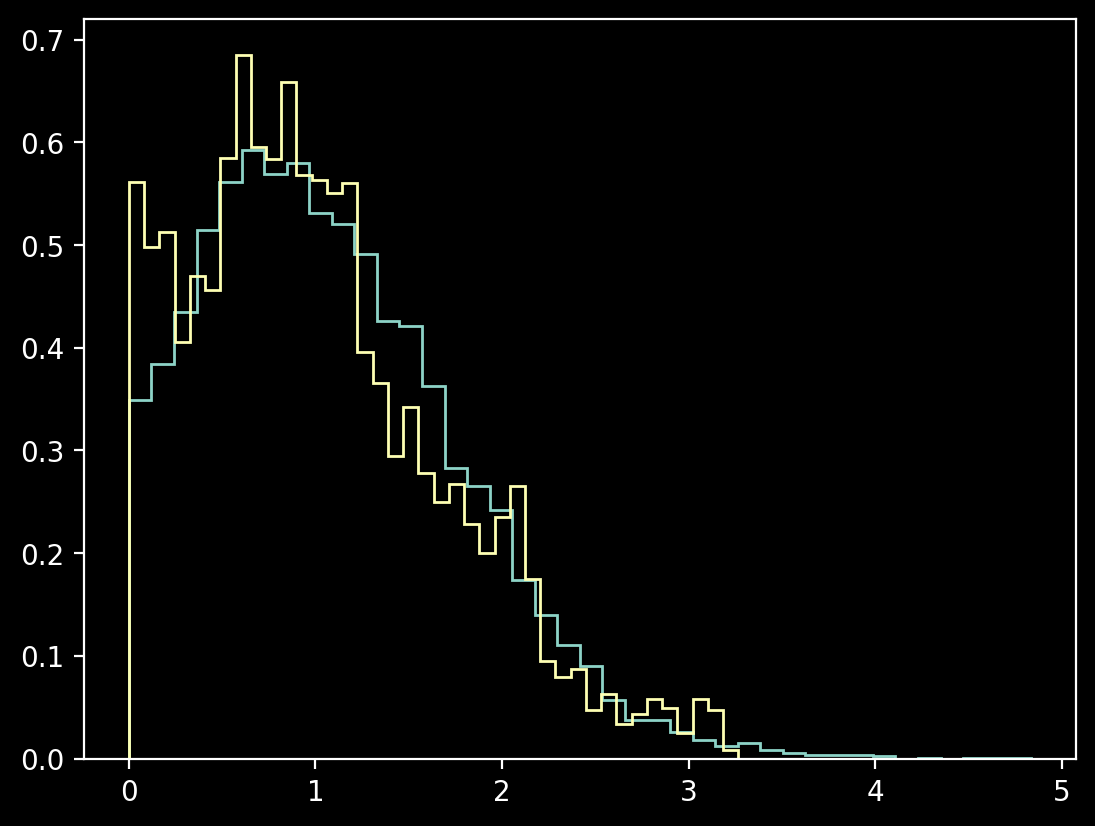

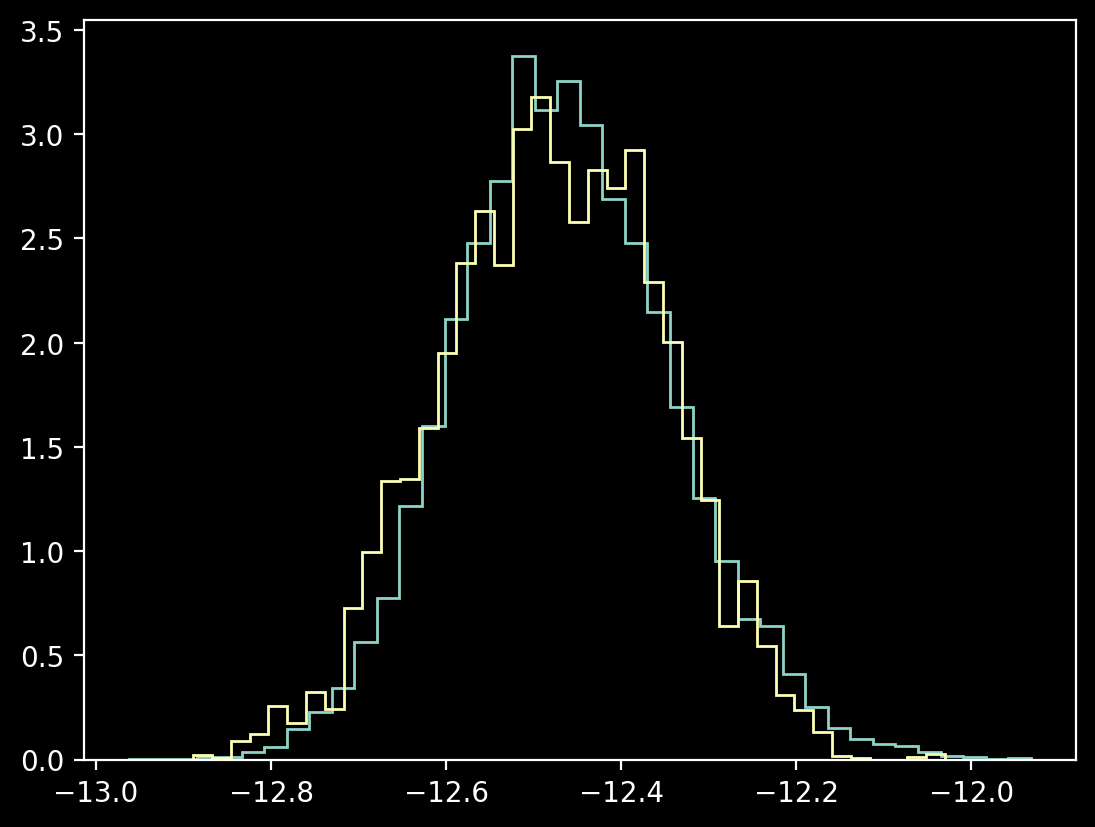

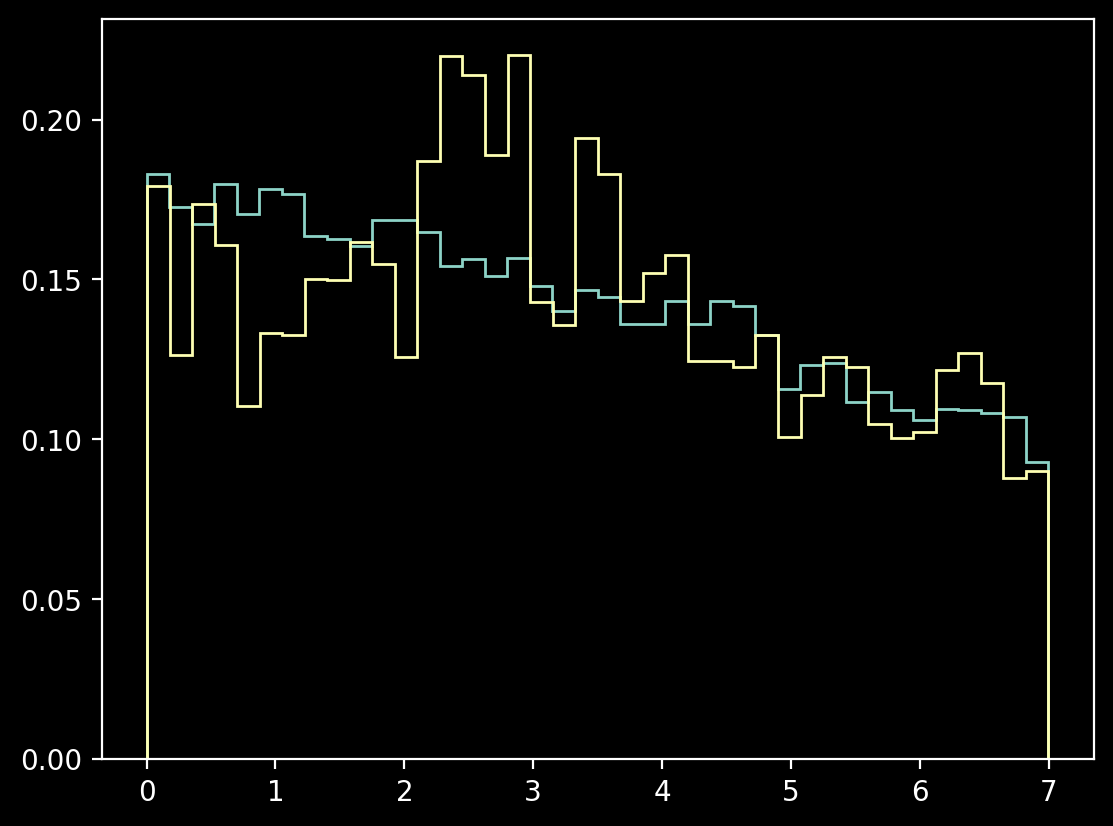

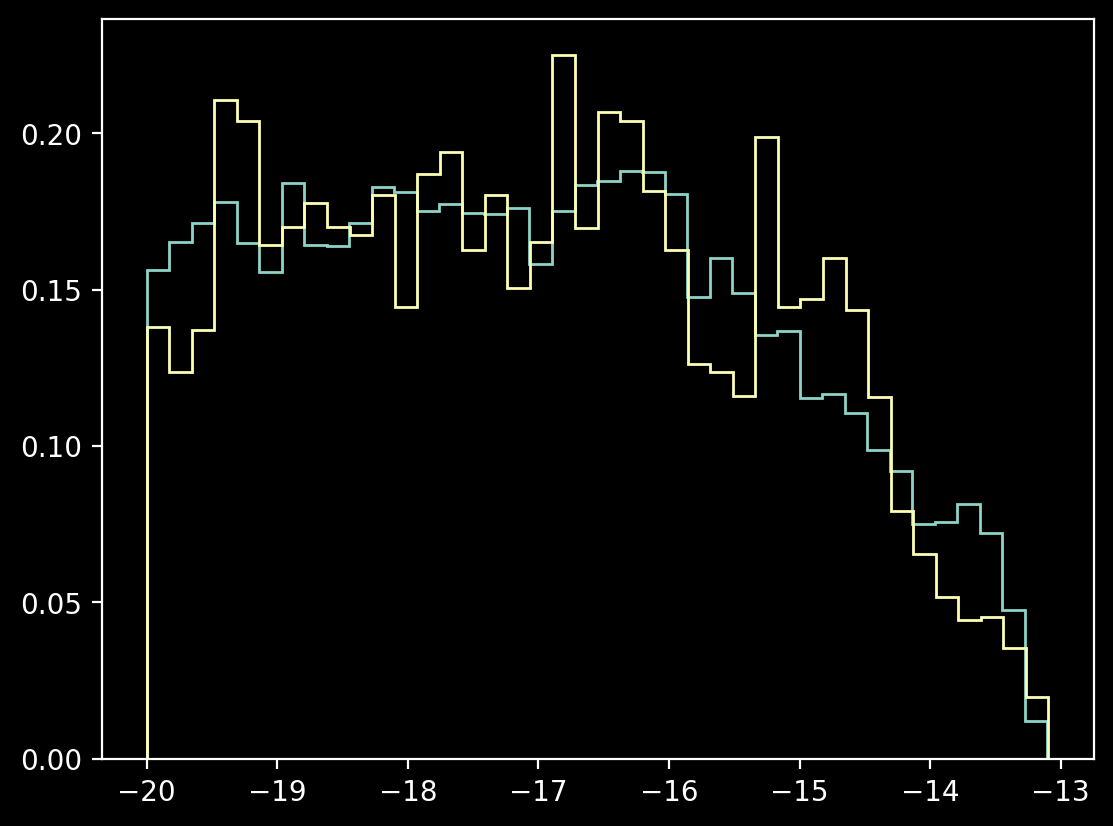

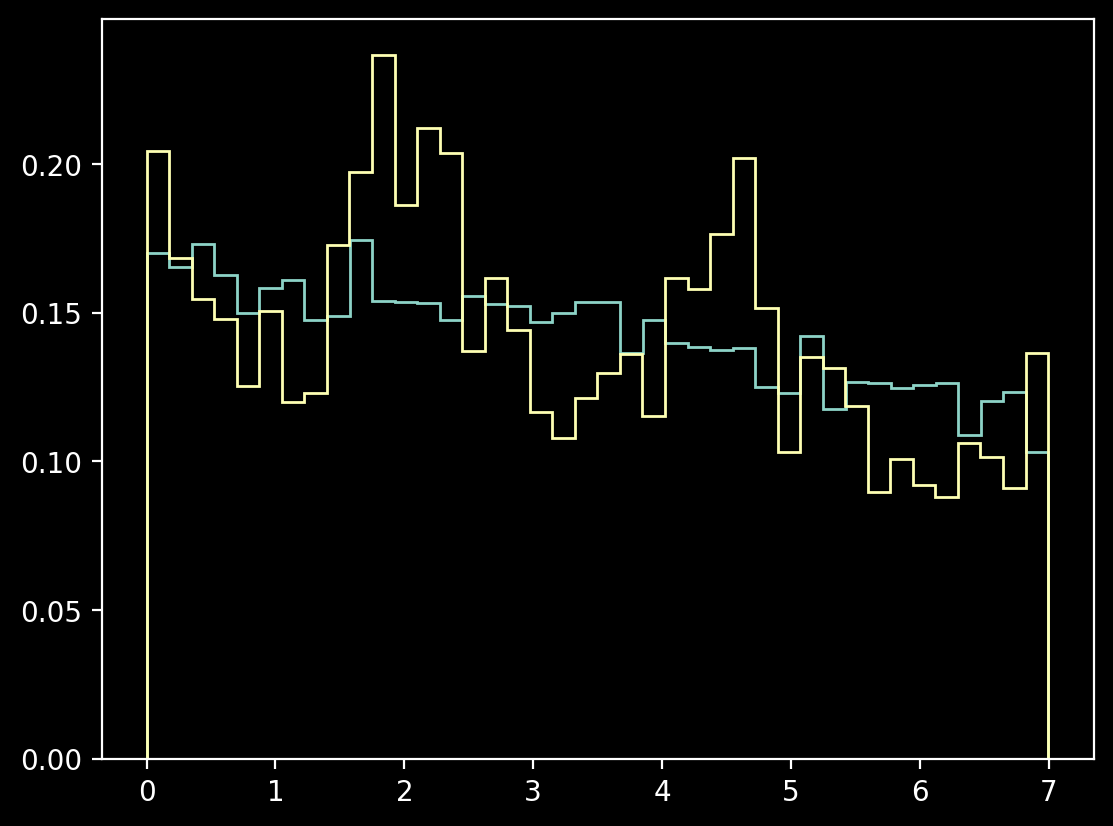

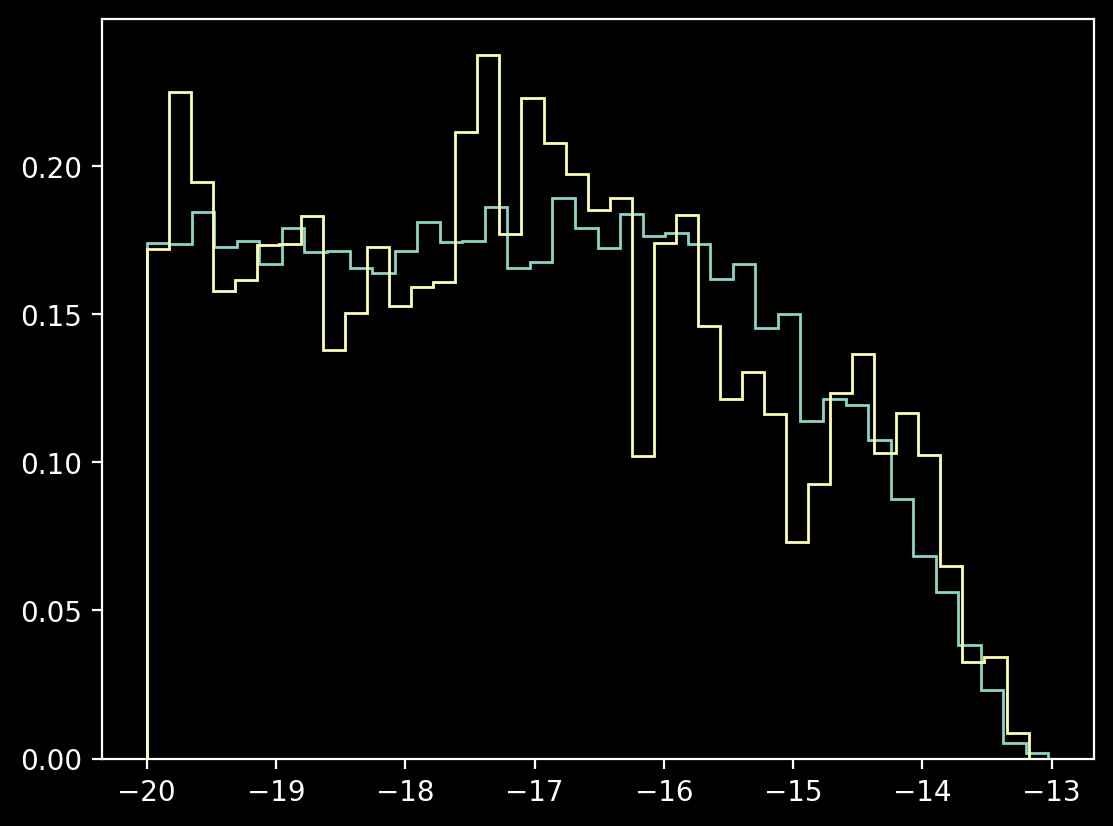

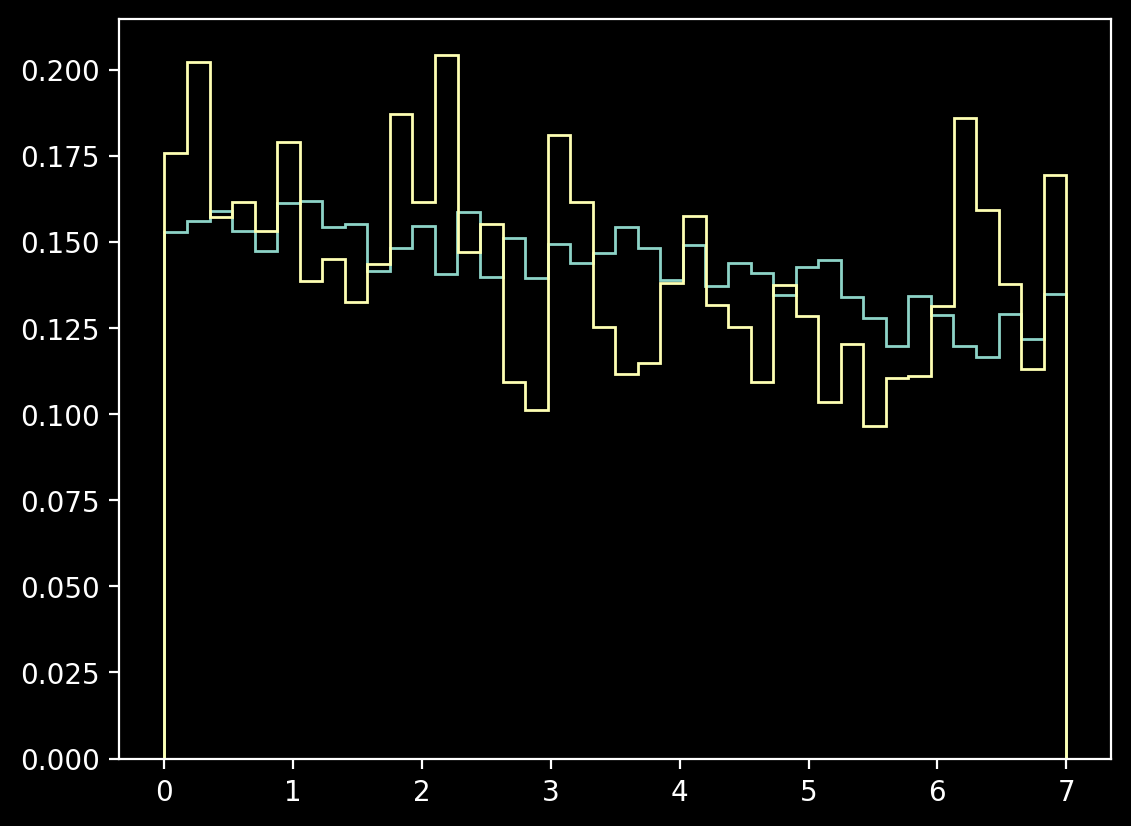

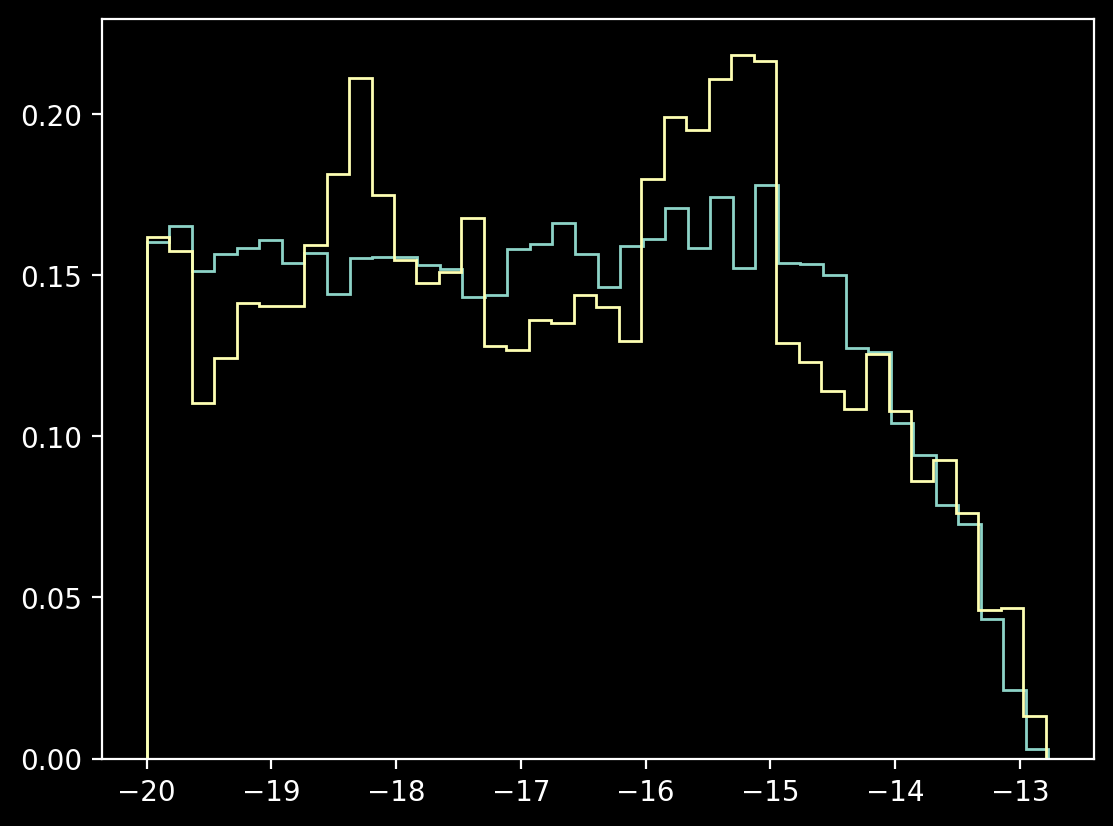

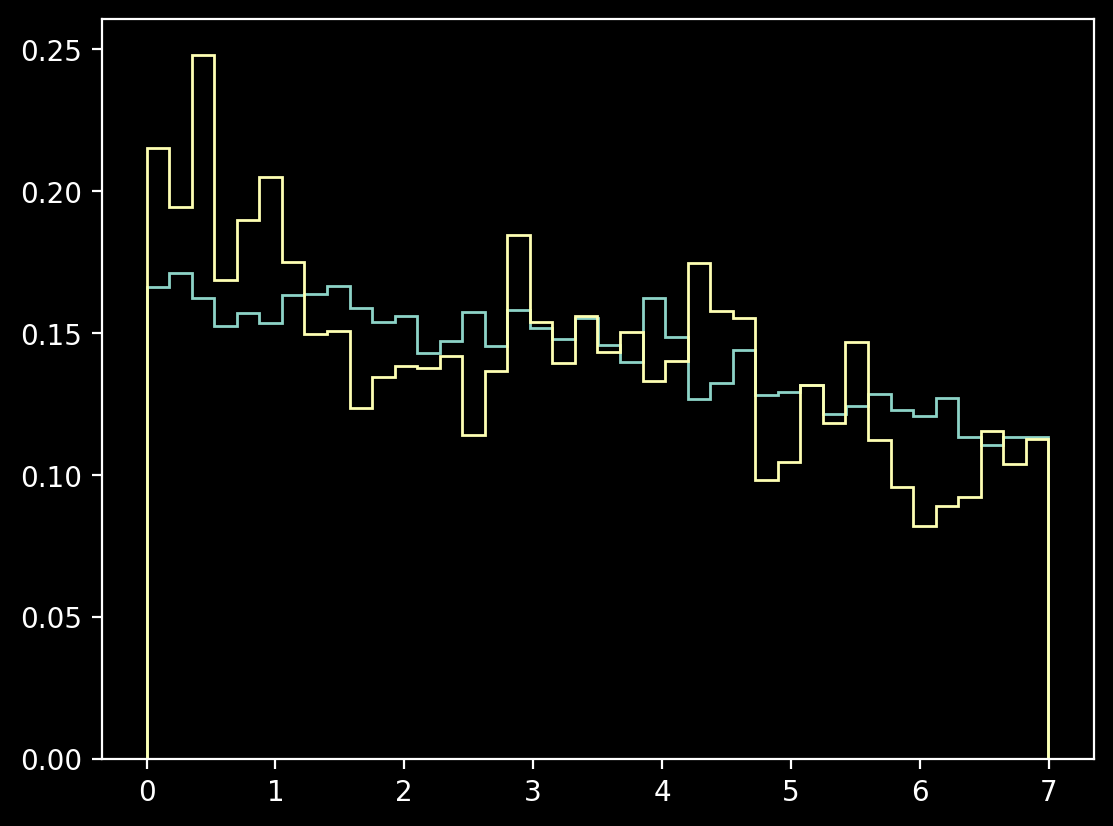

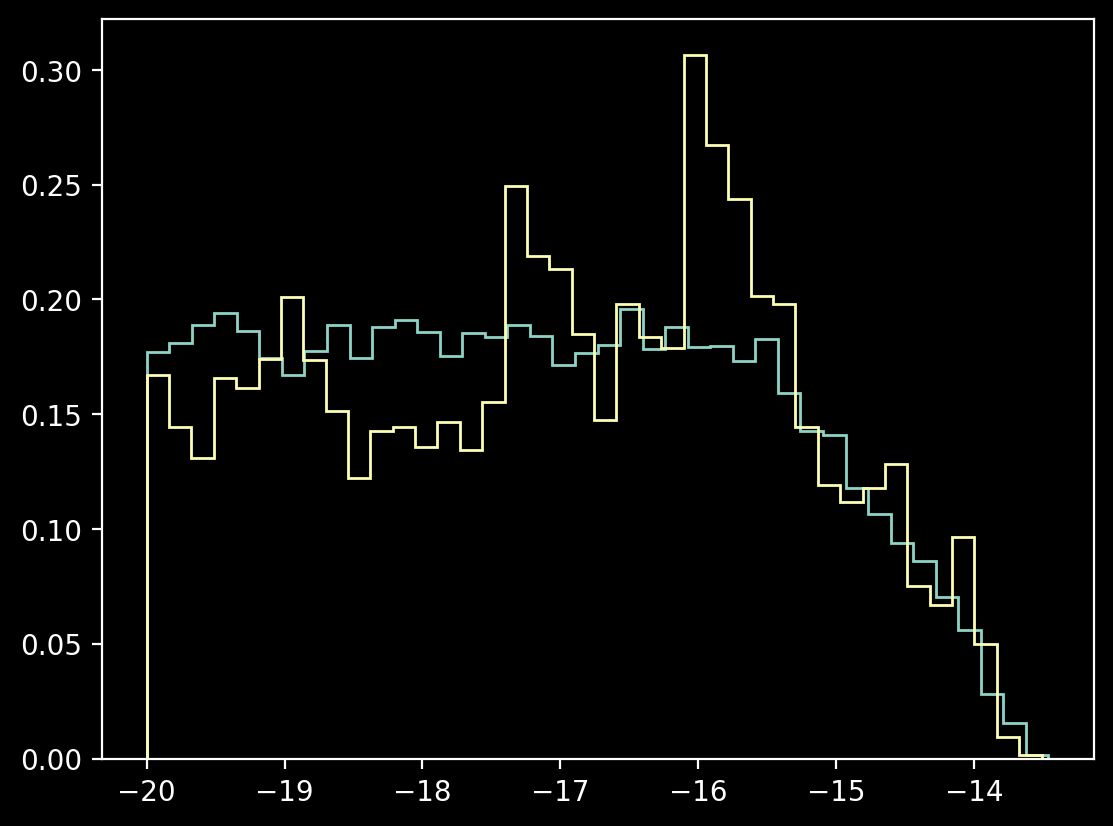

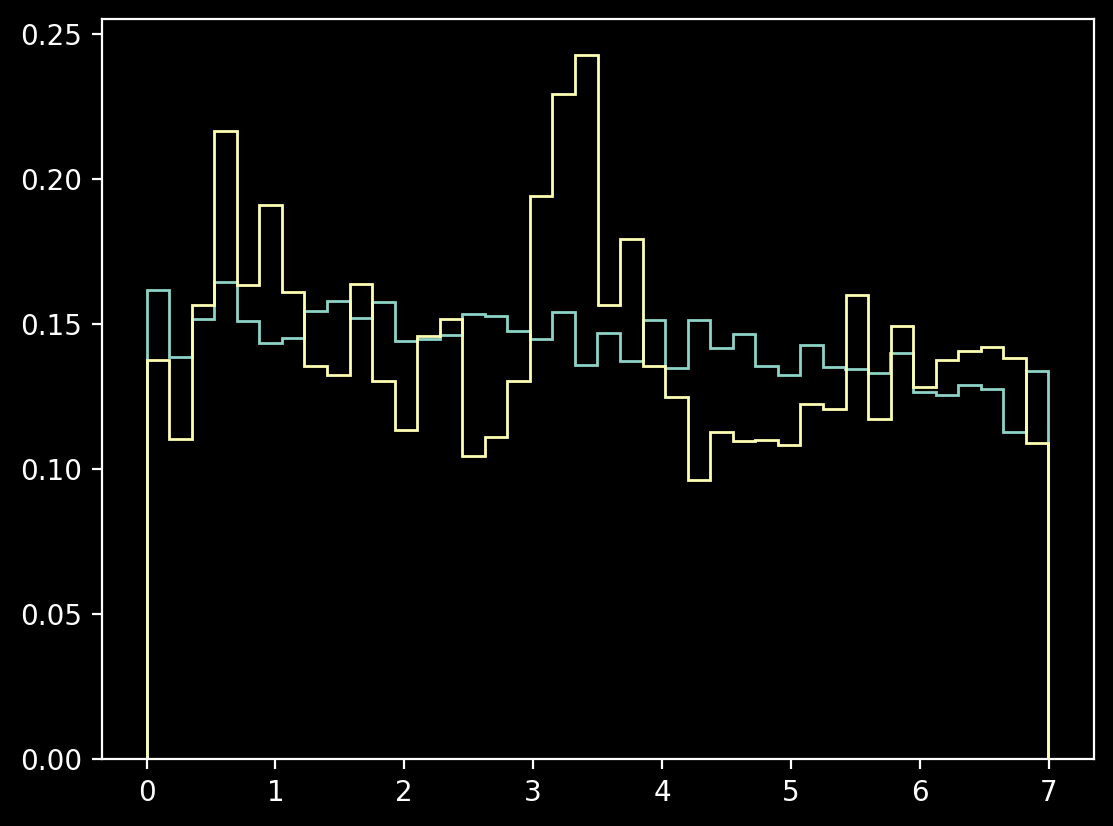

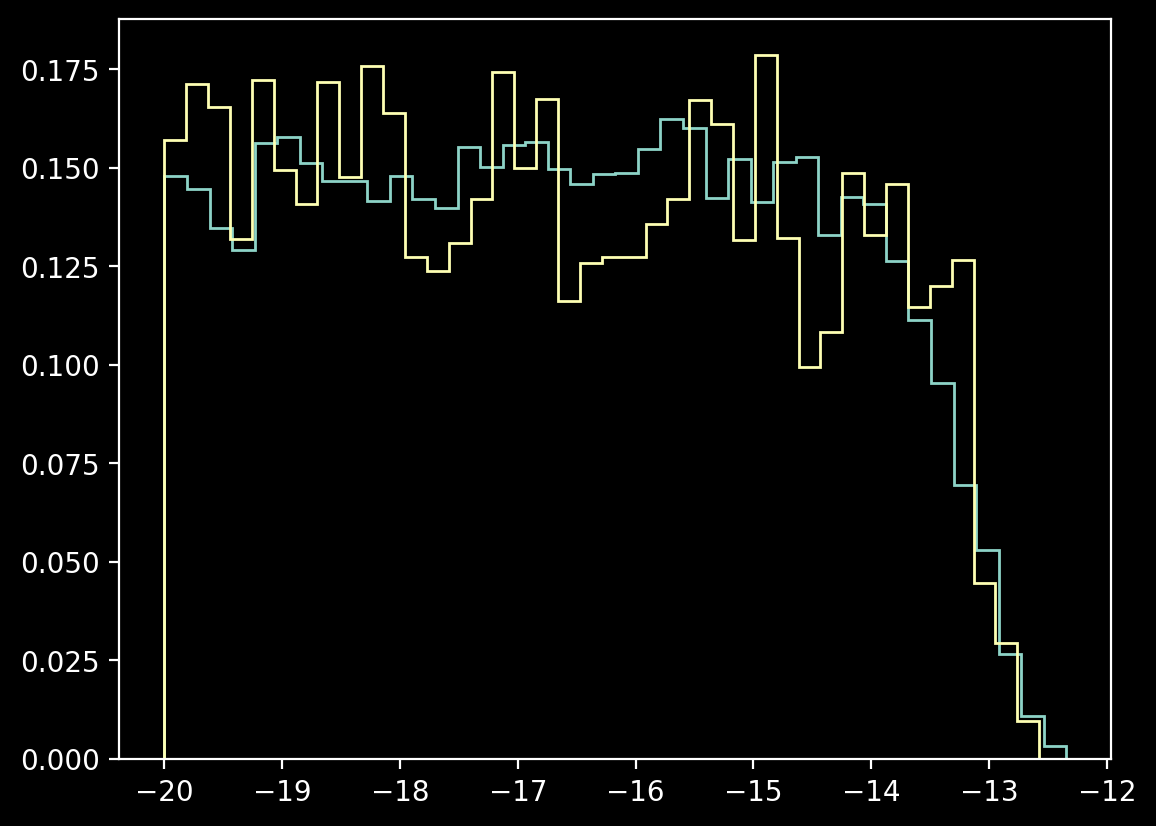

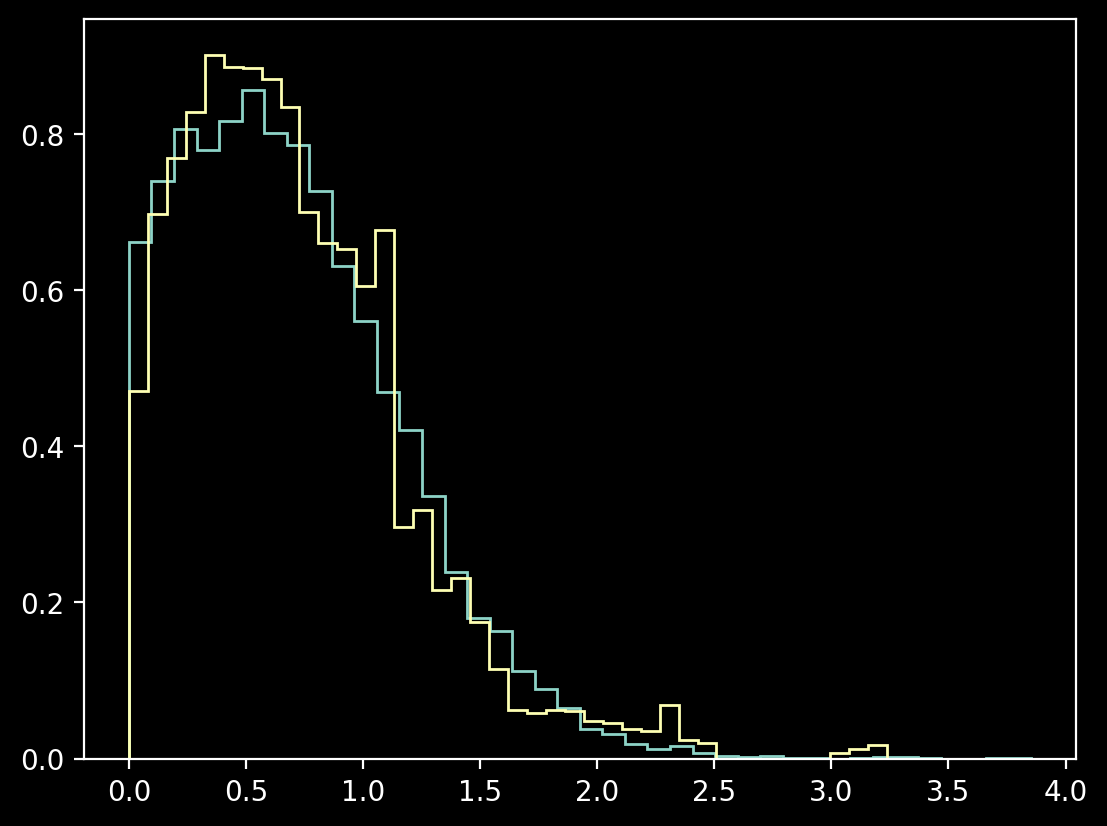

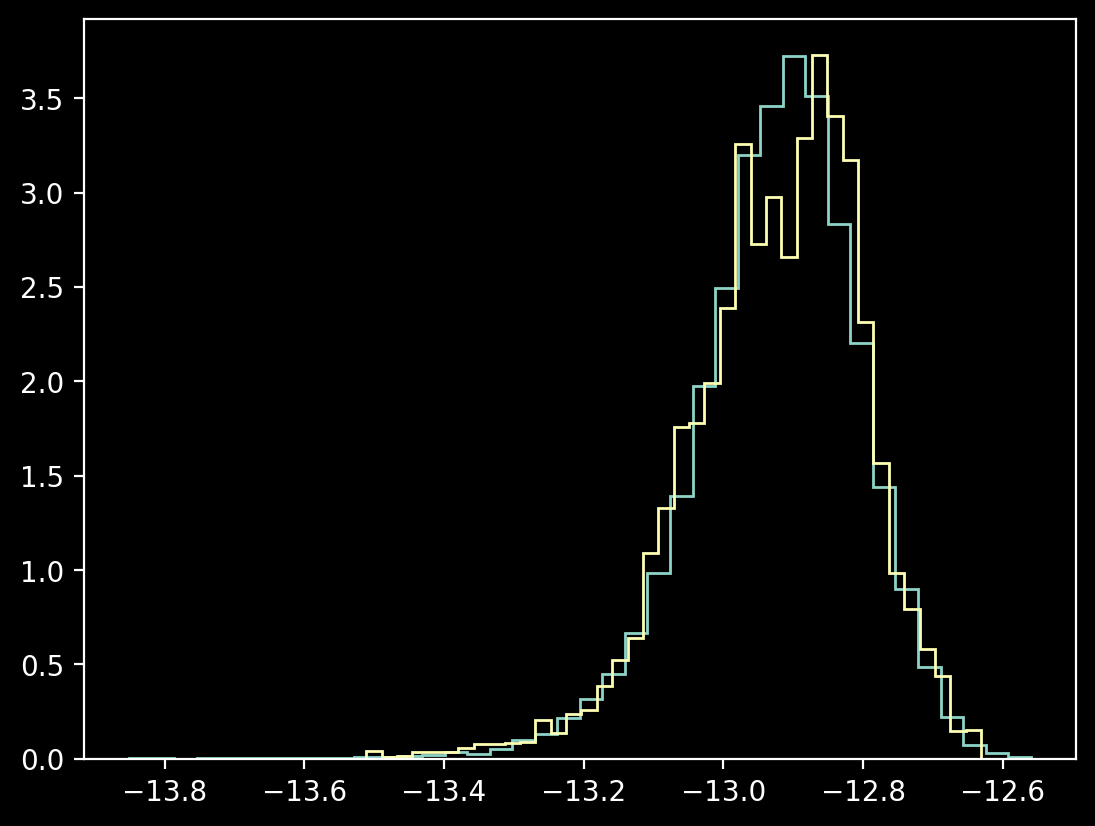

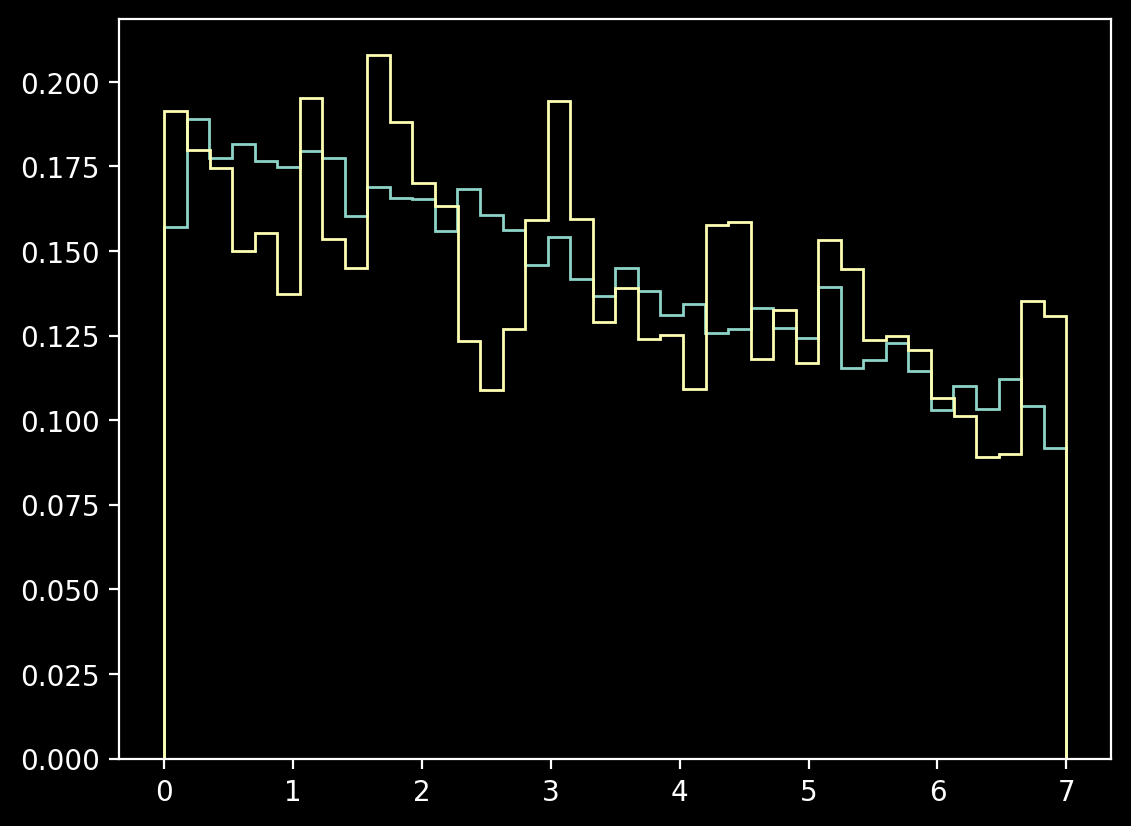

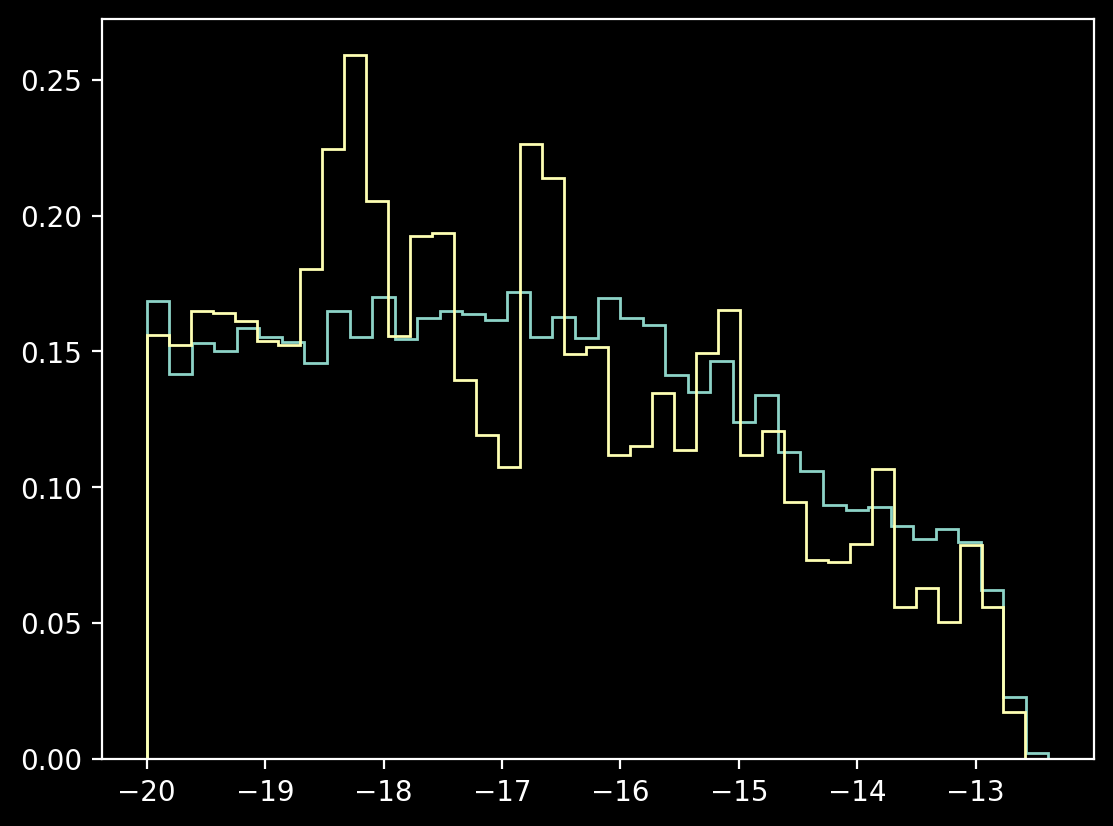

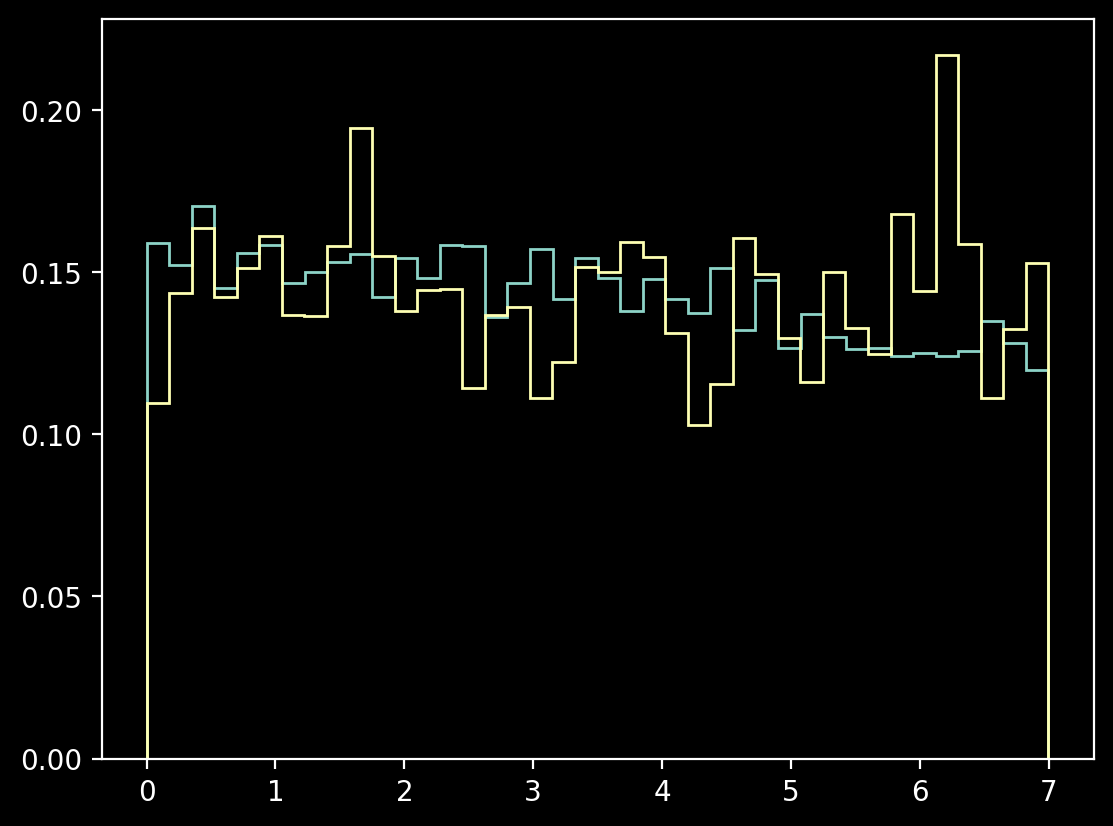

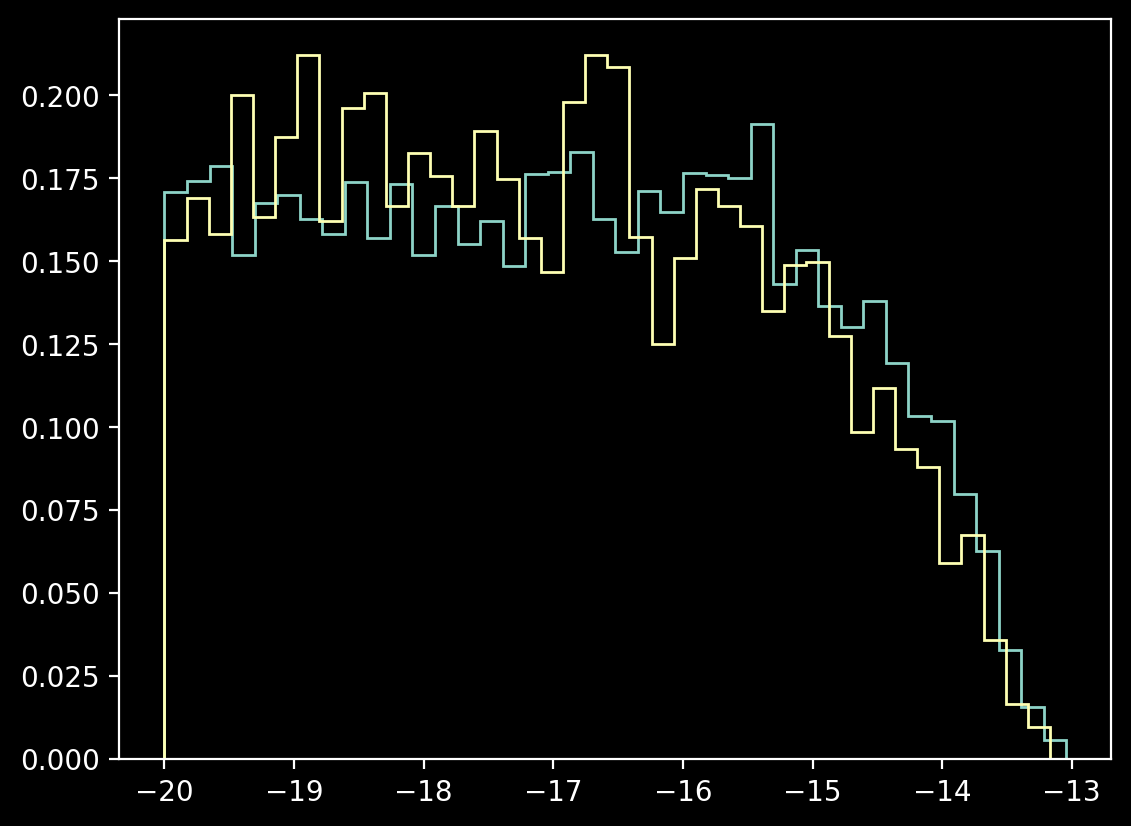

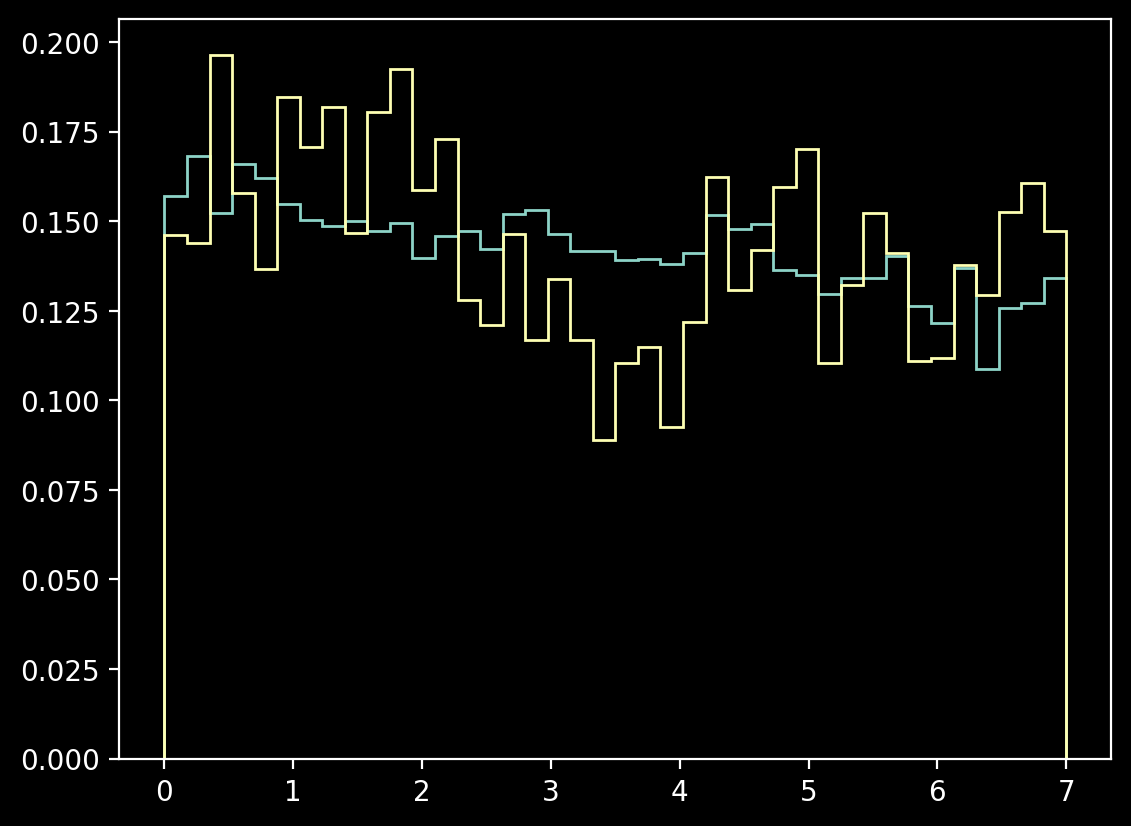

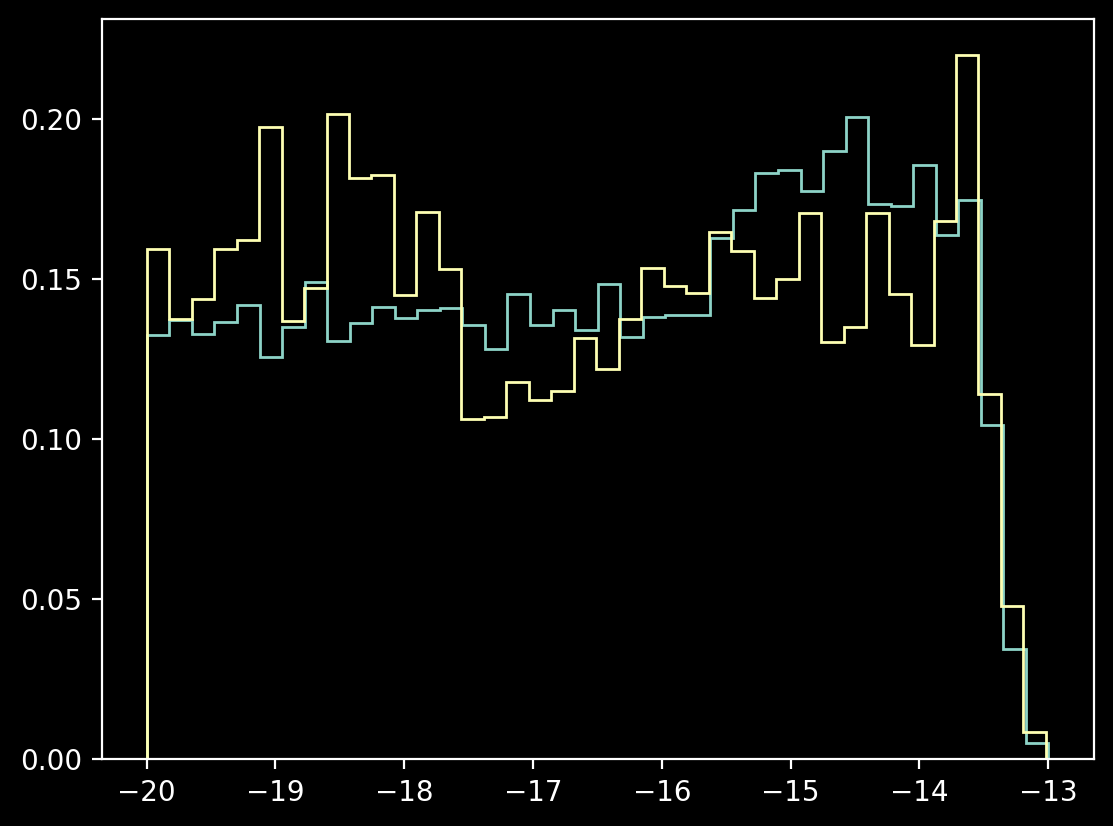

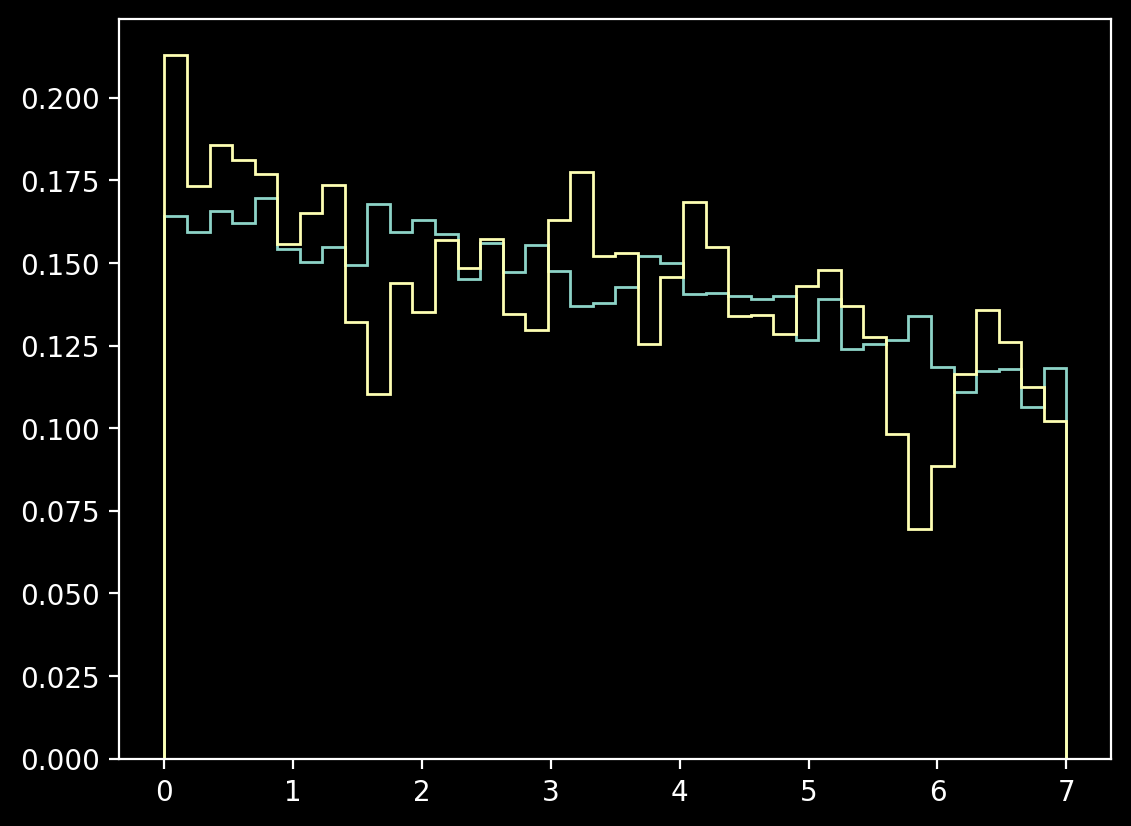

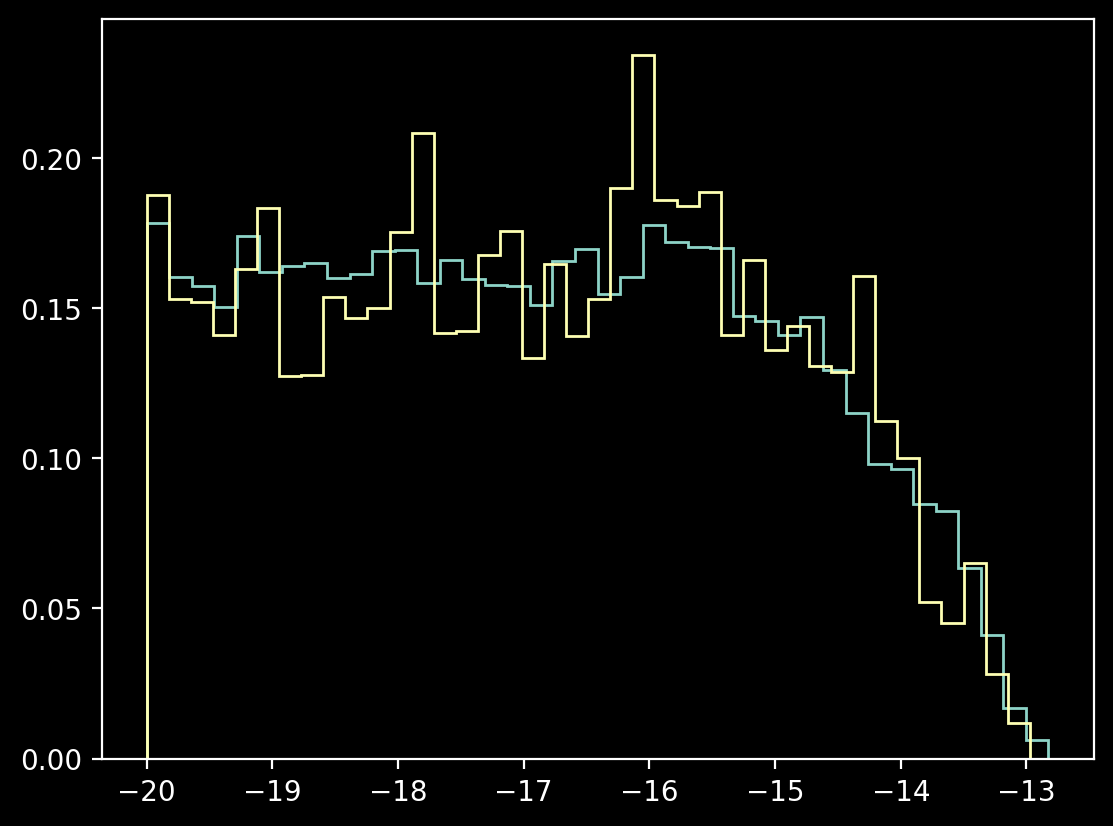

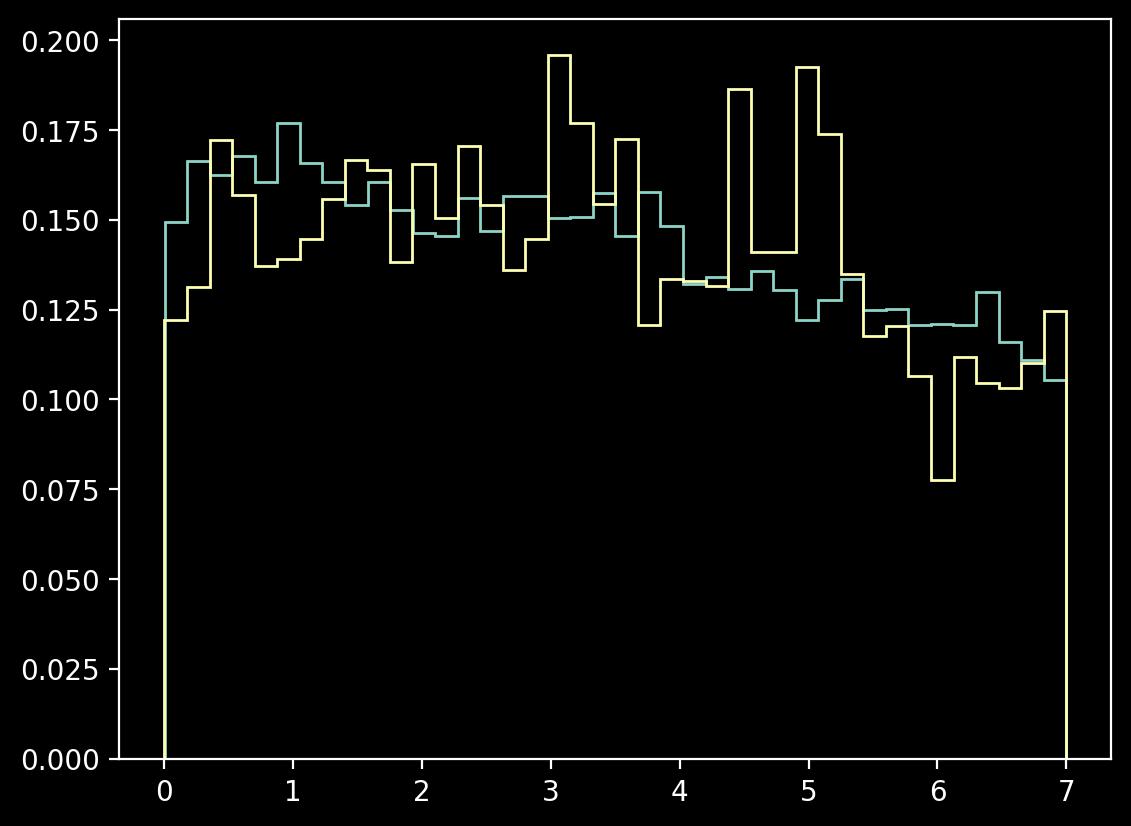

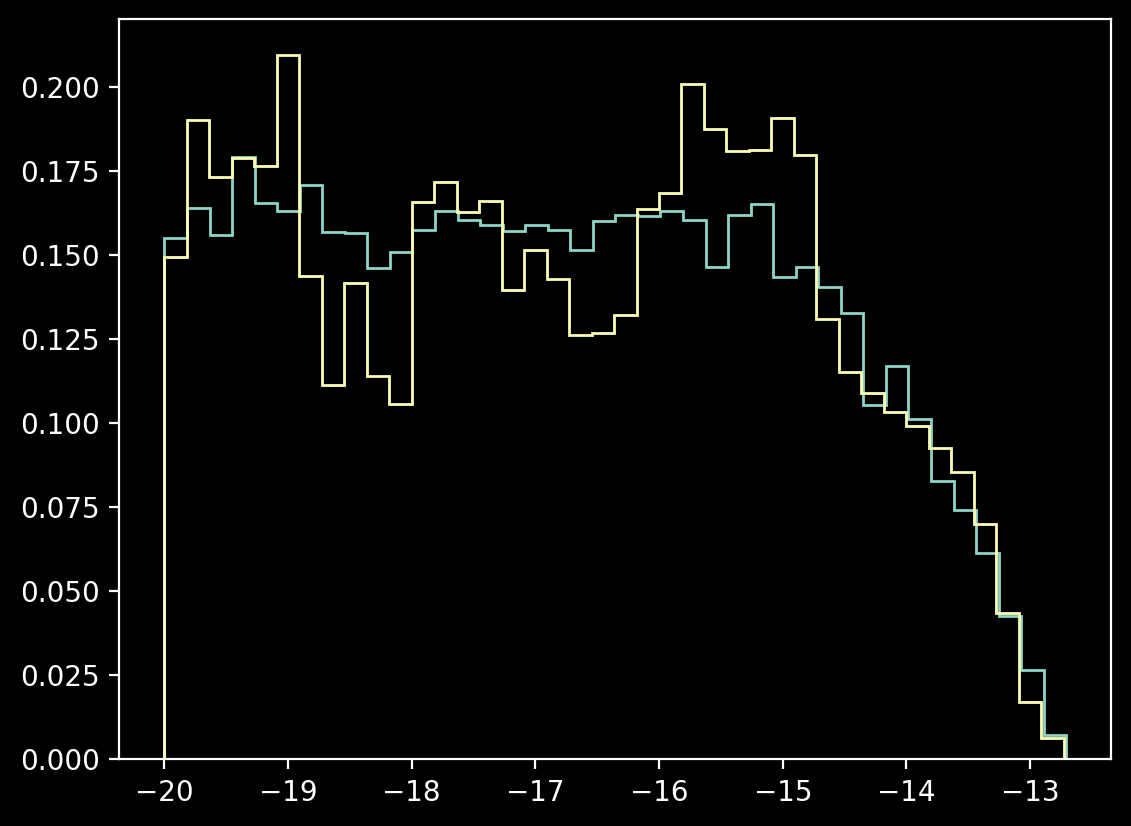

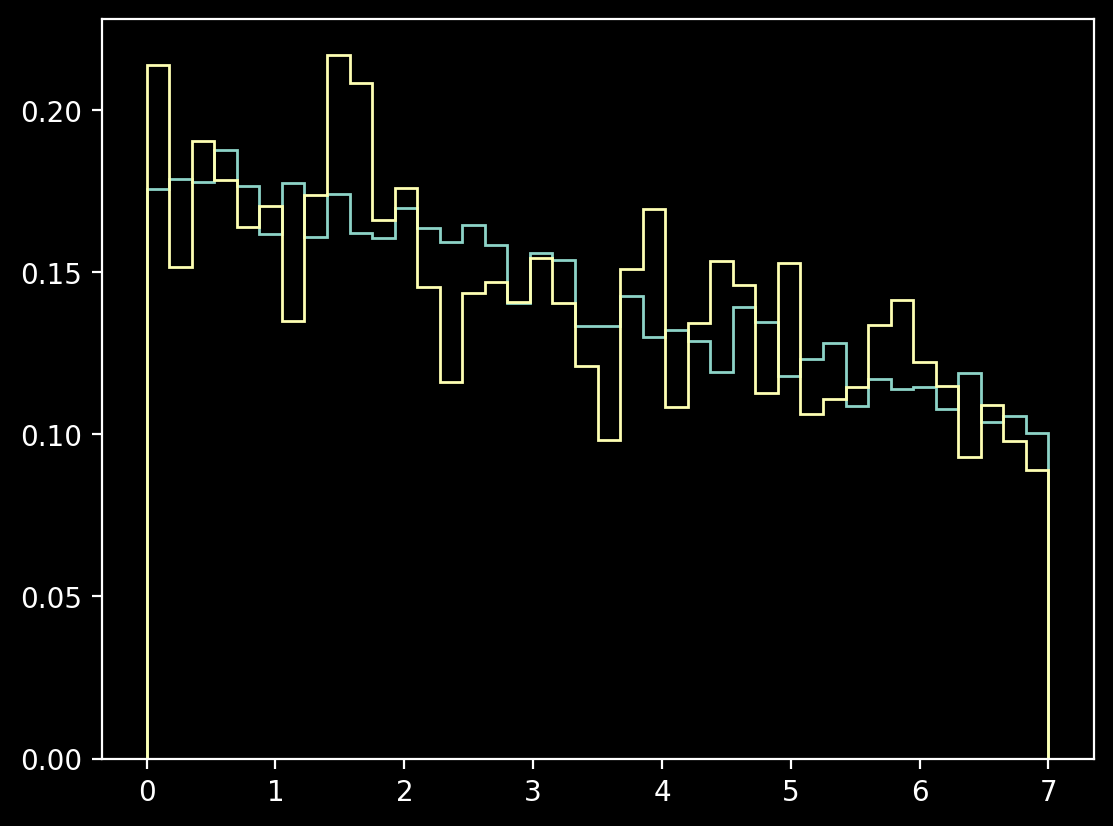

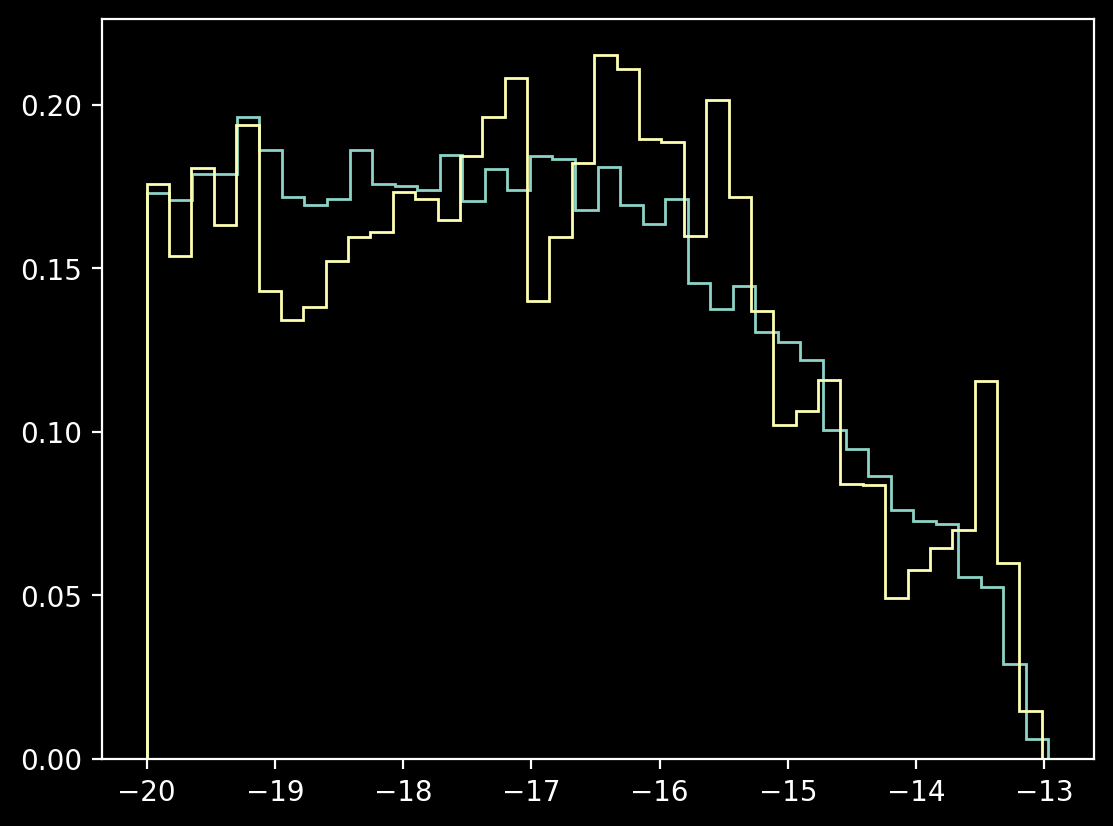

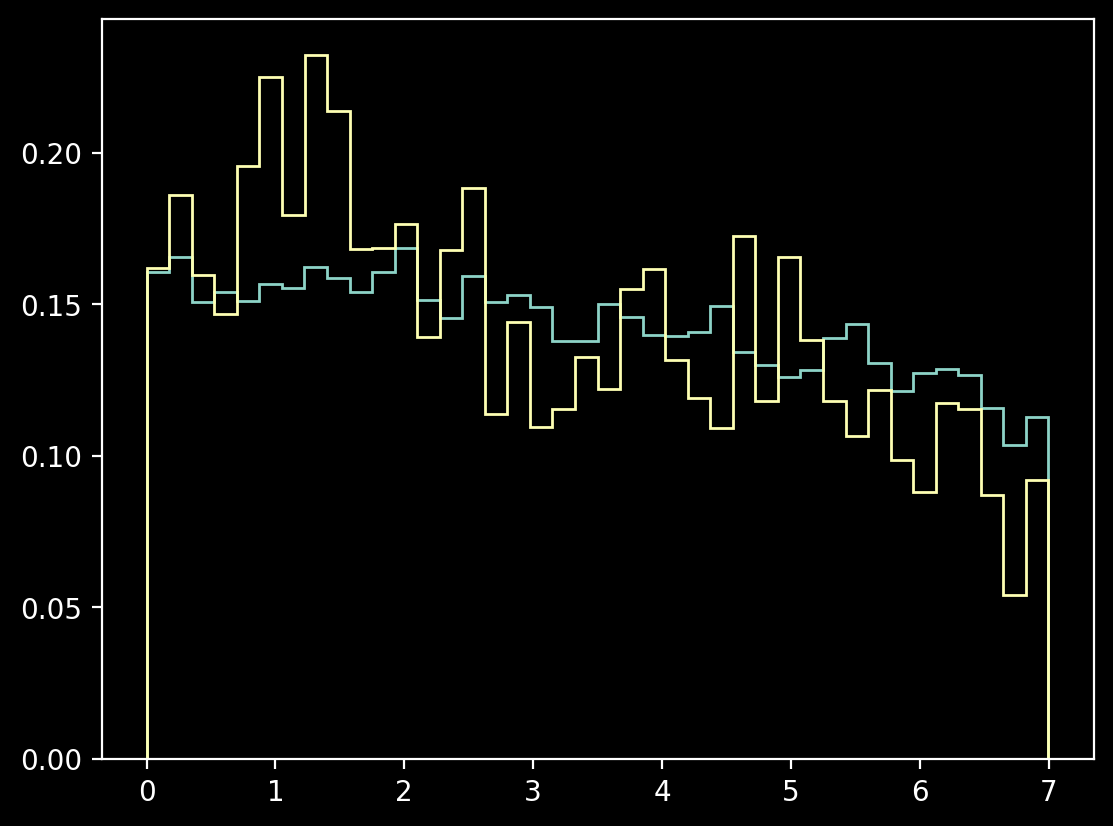

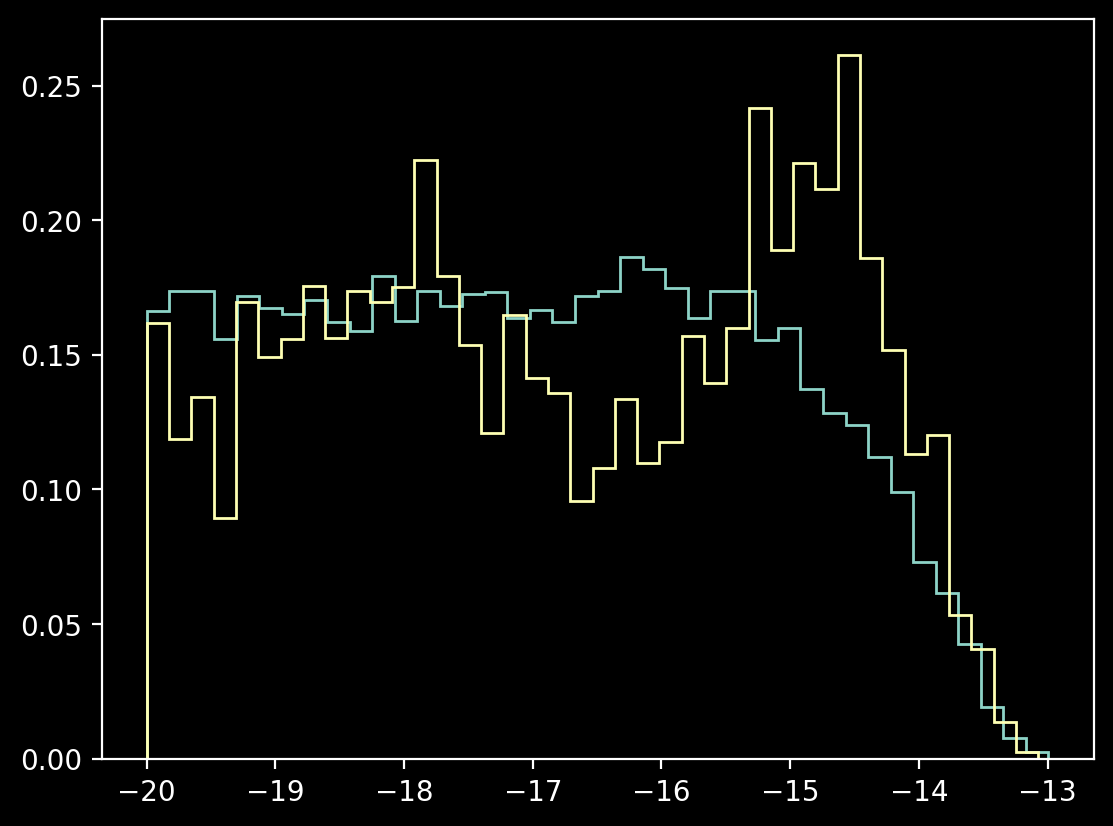

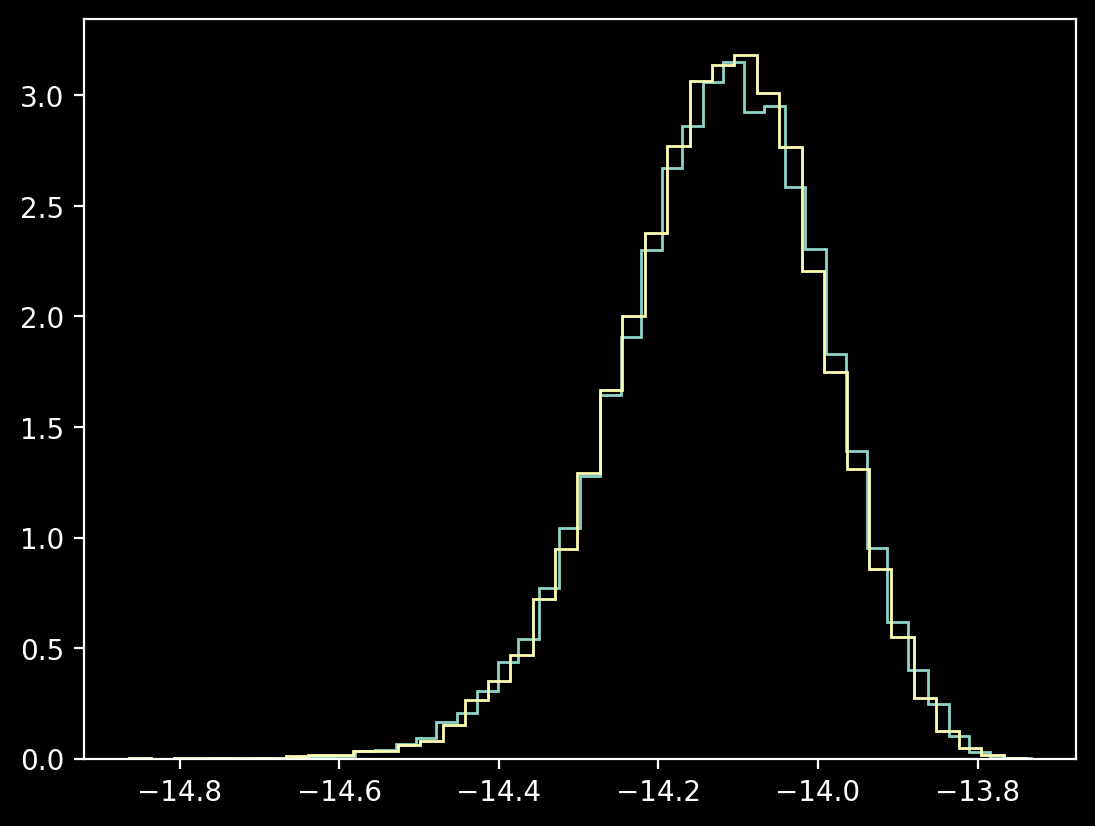

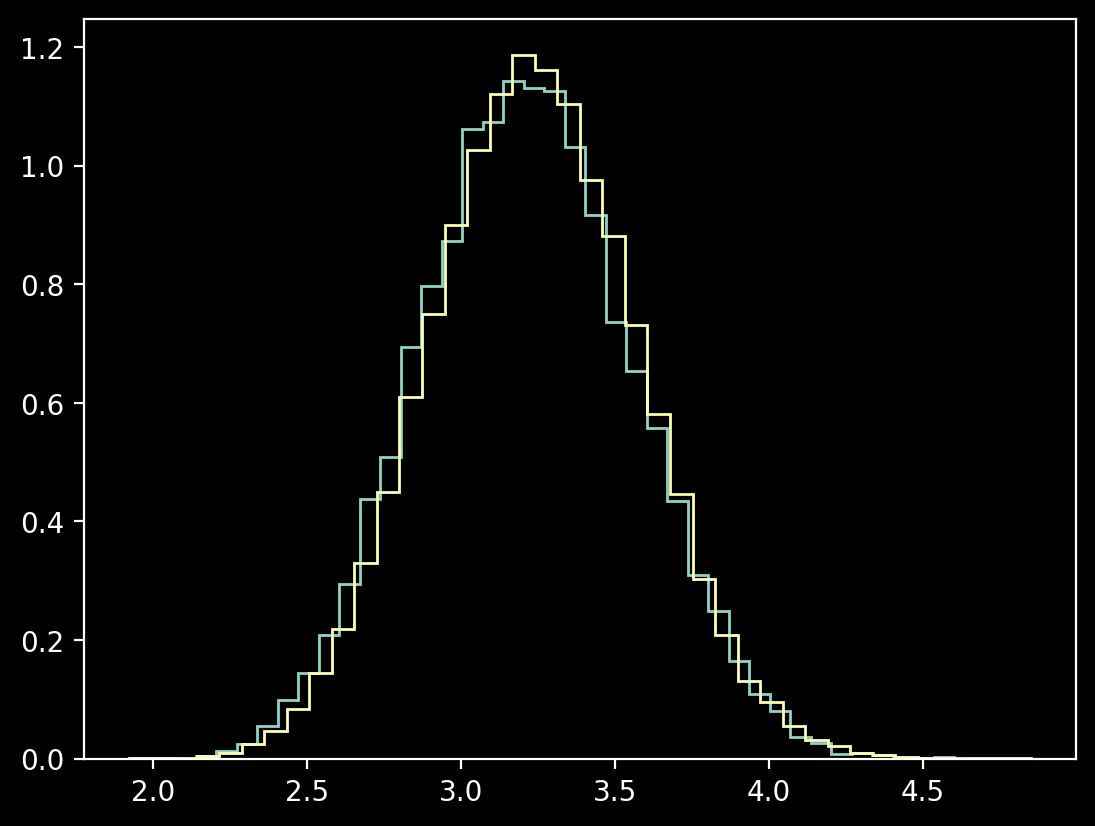

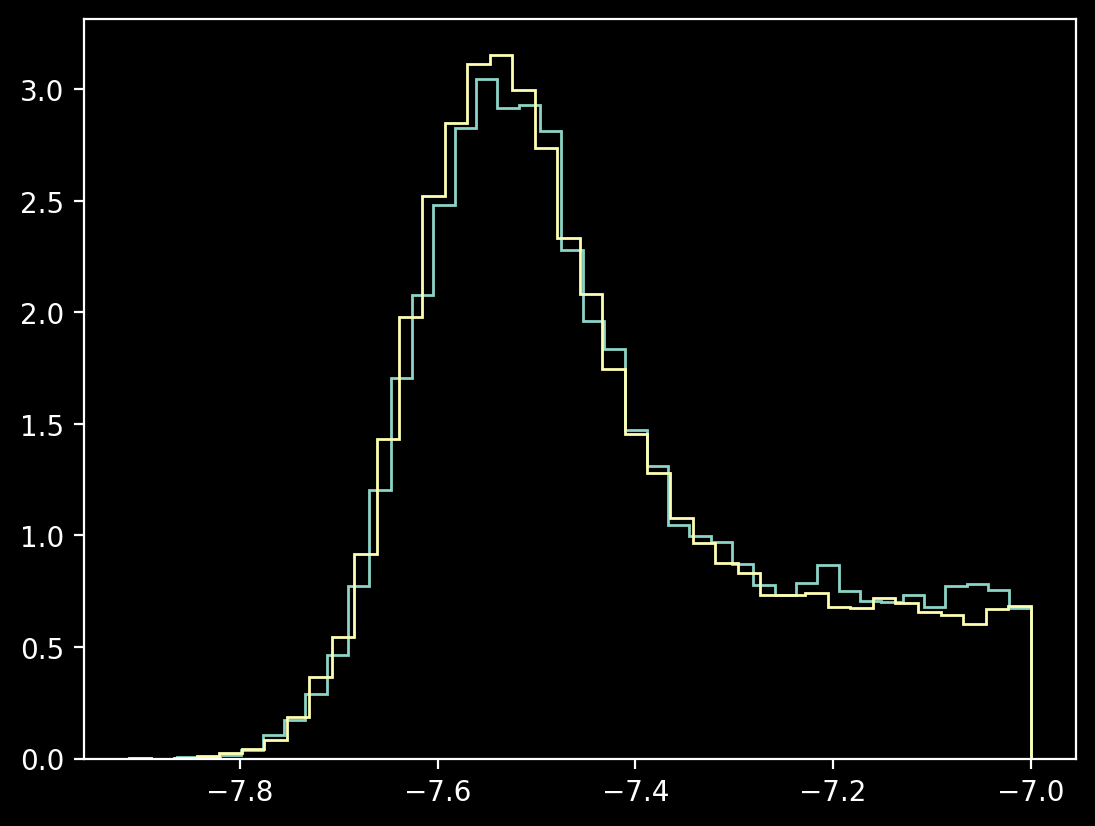

In [71]:
for idx in range(chain.shape[1]):
    plt.hist(samps[:, idx], **hist_settings)
    plt.hist(chain[:, idx], **hist_settings)
    plt.show()

In [ ]:
# np.save('bpl_samp.npy', samps)

In [20]:
from enterprise_extensions import blocks
from enterprise.signals import signal_base, gp_signals

In [21]:
from enterprise.signals import gp_priors as gpp
from enterprise.signals import (gp_signals, parameter, selections, utils,
                                white_signals)

In [22]:
log10_Agw = parameter.Uniform(-18., -11.)('gw_log10A')
gamma_gw = parameter.Uniform(0., 7.)('gw_gamma')
delta_gw = parameter.Constant(0.)('gw_delta')
kappa_gw = parameter.Constant(0.1)('gw_kappa')
log10_fb_gw = parameter.Uniform(-8.7, -7.)('gw_fbend')


cpl = gpp.broken_powerlaw(log10_A=log10_Agw,
                            gamma=gamma_gw,
                            delta=delta_gw,
                            log10_fb=log10_fb_gw,
                            kappa=kappa_gw)

In [32]:
tm = gp_signals.MarginalizingTimingModel(use_svd=True)
wn = blocks.white_noise_block(
    vary=False,
    inc_ecorr=True,
    gp_ecorr=False,
    select='backend',
    tnequad=tnequad,
)
rn = blocks.red_noise_block(
    psd="powerlaw",
    prior="log-uniform",
    Tspan=Tspan,
    components=int_bins,
    gamma_val=None,
)
# gwb = blocks.common_red_noise_block(
#     psd="broken_powerlaw",
#     prior="log-uniform",
#     Tspan=Tspan,
#     components=crn_bins,
#     gamma_val=None,
#     name="gw",
#     orf="crn",
# )
gwb = gp_signals.FourierBasisGP(cpl, coefficients=False, combine=True,
                                        components=30, Tspan=Tspan,
                                        name='gw', pshift=None, pseed=None)

s = tm + wn + rn + gwb

pta = signal_base.PTA(
    [s(p) for p in psrs], signal_base.LogLikelihoodDenseCholesky
)
pta.set_default_params(noise_dict)

In [33]:
pta.params

[B1855+09_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1855+09_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1937+21_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1937+21_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 B1953+29_red_noise_gamma:Uniform(pmin=0, pmax=7),
 B1953+29_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0023+0923_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0023+0923_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0030+0451_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0030+0451_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0340+4130_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0340+4130_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0406+3039_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0406+3039_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0437-4715_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0437-4715_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J0509+0856_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0509+0856_red_noise_log10_A:Uniform(pmin=-20, pmax=-11),
 J05

In [34]:
# y0 = np.hstack([p.sample() for p in pta.params])
y0 = np.array(x0).copy()
y0[-1] = x0[134] 
y0[134] = x0[-1] 
# y0

In [35]:
pta.get_lnlikelihood(y0)

KernelMatrix(7971335.99522102)

In [36]:
def lnlike_offset(params):
    likelihood_adjust = 0
    likelihood_adjust += -0.5 * np.sum([ell for ell in m.pta.get_rNr_logdet(params)])
    likelihood_adjust += sum(m.pta.get_logsignalprior(params))
    return likelihood_adjust
params = pta.map_params(y0)
lnlike_offset(params)

np.float64(7925203.020110495)

In [37]:
m.get_lnliklihood(x0) + lnlike_offset(params), pta.get_lnlikelihood(y0)

(Array(7971335.99522102, dtype=float64), KernelMatrix(7971335.99522102))

In [38]:
x = jnp.tril(jar.normal(key = jar.key(101), shape = (2, 2, 2)))
x = x @ x.T + jnp.eye(x.shape[0])

###time this
jnp.linalg.cholesky(x)

Array([[[ 1.47870869,  0.        ],
        [-0.78328677,  0.81642324]],

       [[ 1.        ,  0.        ],
        [-0.0182755 ,  1.00598847]]], dtype=float64)

In [39]:
y = np.array(x)
np.linalg.cholesky(y)

array([[[ 1.47870869,  0.        ],
        [-0.20261417,  1.1131184 ]],

       [[ 1.        ,  0.        ],
        [-0.03655099,  1.00549033]]])

## NUTS sampler

In [21]:
import blackjax
from blackjax.progress_bar import progress_bar_scan

In [22]:
m.get_lnliklihood(x0)

Array(44636.45207812, dtype=float64)

In [ ]:
warmup = blackjax.window_adaptation(blackjax.nuts, m.get_lnliklihood, progress_bar = True)
rng_key, warmup_key, sample_key = jax.random.split(jar.key(100), 3)
(state, parameters), _ = warmup.run(warmup_key, x0, num_steps=100)

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    scan_fn = progress_bar_scan(num_samples, progress_bar=True)
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = scan_fn(one_step, initial_state, keys)

In [ ]:
kernel = blackjax.nuts(m.get_lnliklihood, **parameters).step

# Postprocessing

In [18]:
plt.style.use('default')
def figsize(scale, wc = 1, hc = 1):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [wc * fig_width,hc * fig_height]
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {#'backend': 'pdf',
        'axes.labelsize': 12,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        "xtick.top": True,
        "ytick.right": True,
        "xtick.minor.visible": True,
        "xtick.major.top": True, 
        "xtick.minor.top": True,
        "ytick.minor.visible": True, 
        "ytick.major.right": True, 
        "ytick.minor.right": True,
        "ytick.direction": "in",
        "xtick.direction": "in",
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        "text.usetex": True,
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5, 1, 1)}
plt.rcParams.update(params)

In [19]:
chain_ent = np.loadtxt('../testnew/Standard/chain_1.txt')
chain_ent = chain_ent[int(0.25 * chain_ent.shape[0]):, :-4]
chain_ent.shape

(57225, 139)

In [20]:
chain_pan = np.loadtxt('../testnew/Standard_PANDORA/chain_1.txt')
chain_pan = chain_pan[int(0.25 * chain_pan.shape[0]):, :-4]
chain_pan.shape

(74925, 139)

In [21]:
chain_pan_ss = np.loadtxt('../testnew/Standard_PANDORA_LU/chain_1.txt')
chain_pan_ss = chain_pan_ss[int(0.25 * chain_pan_ss.shape[0]):, :-4]
chain_pan_ss.shape

(63150, 139)

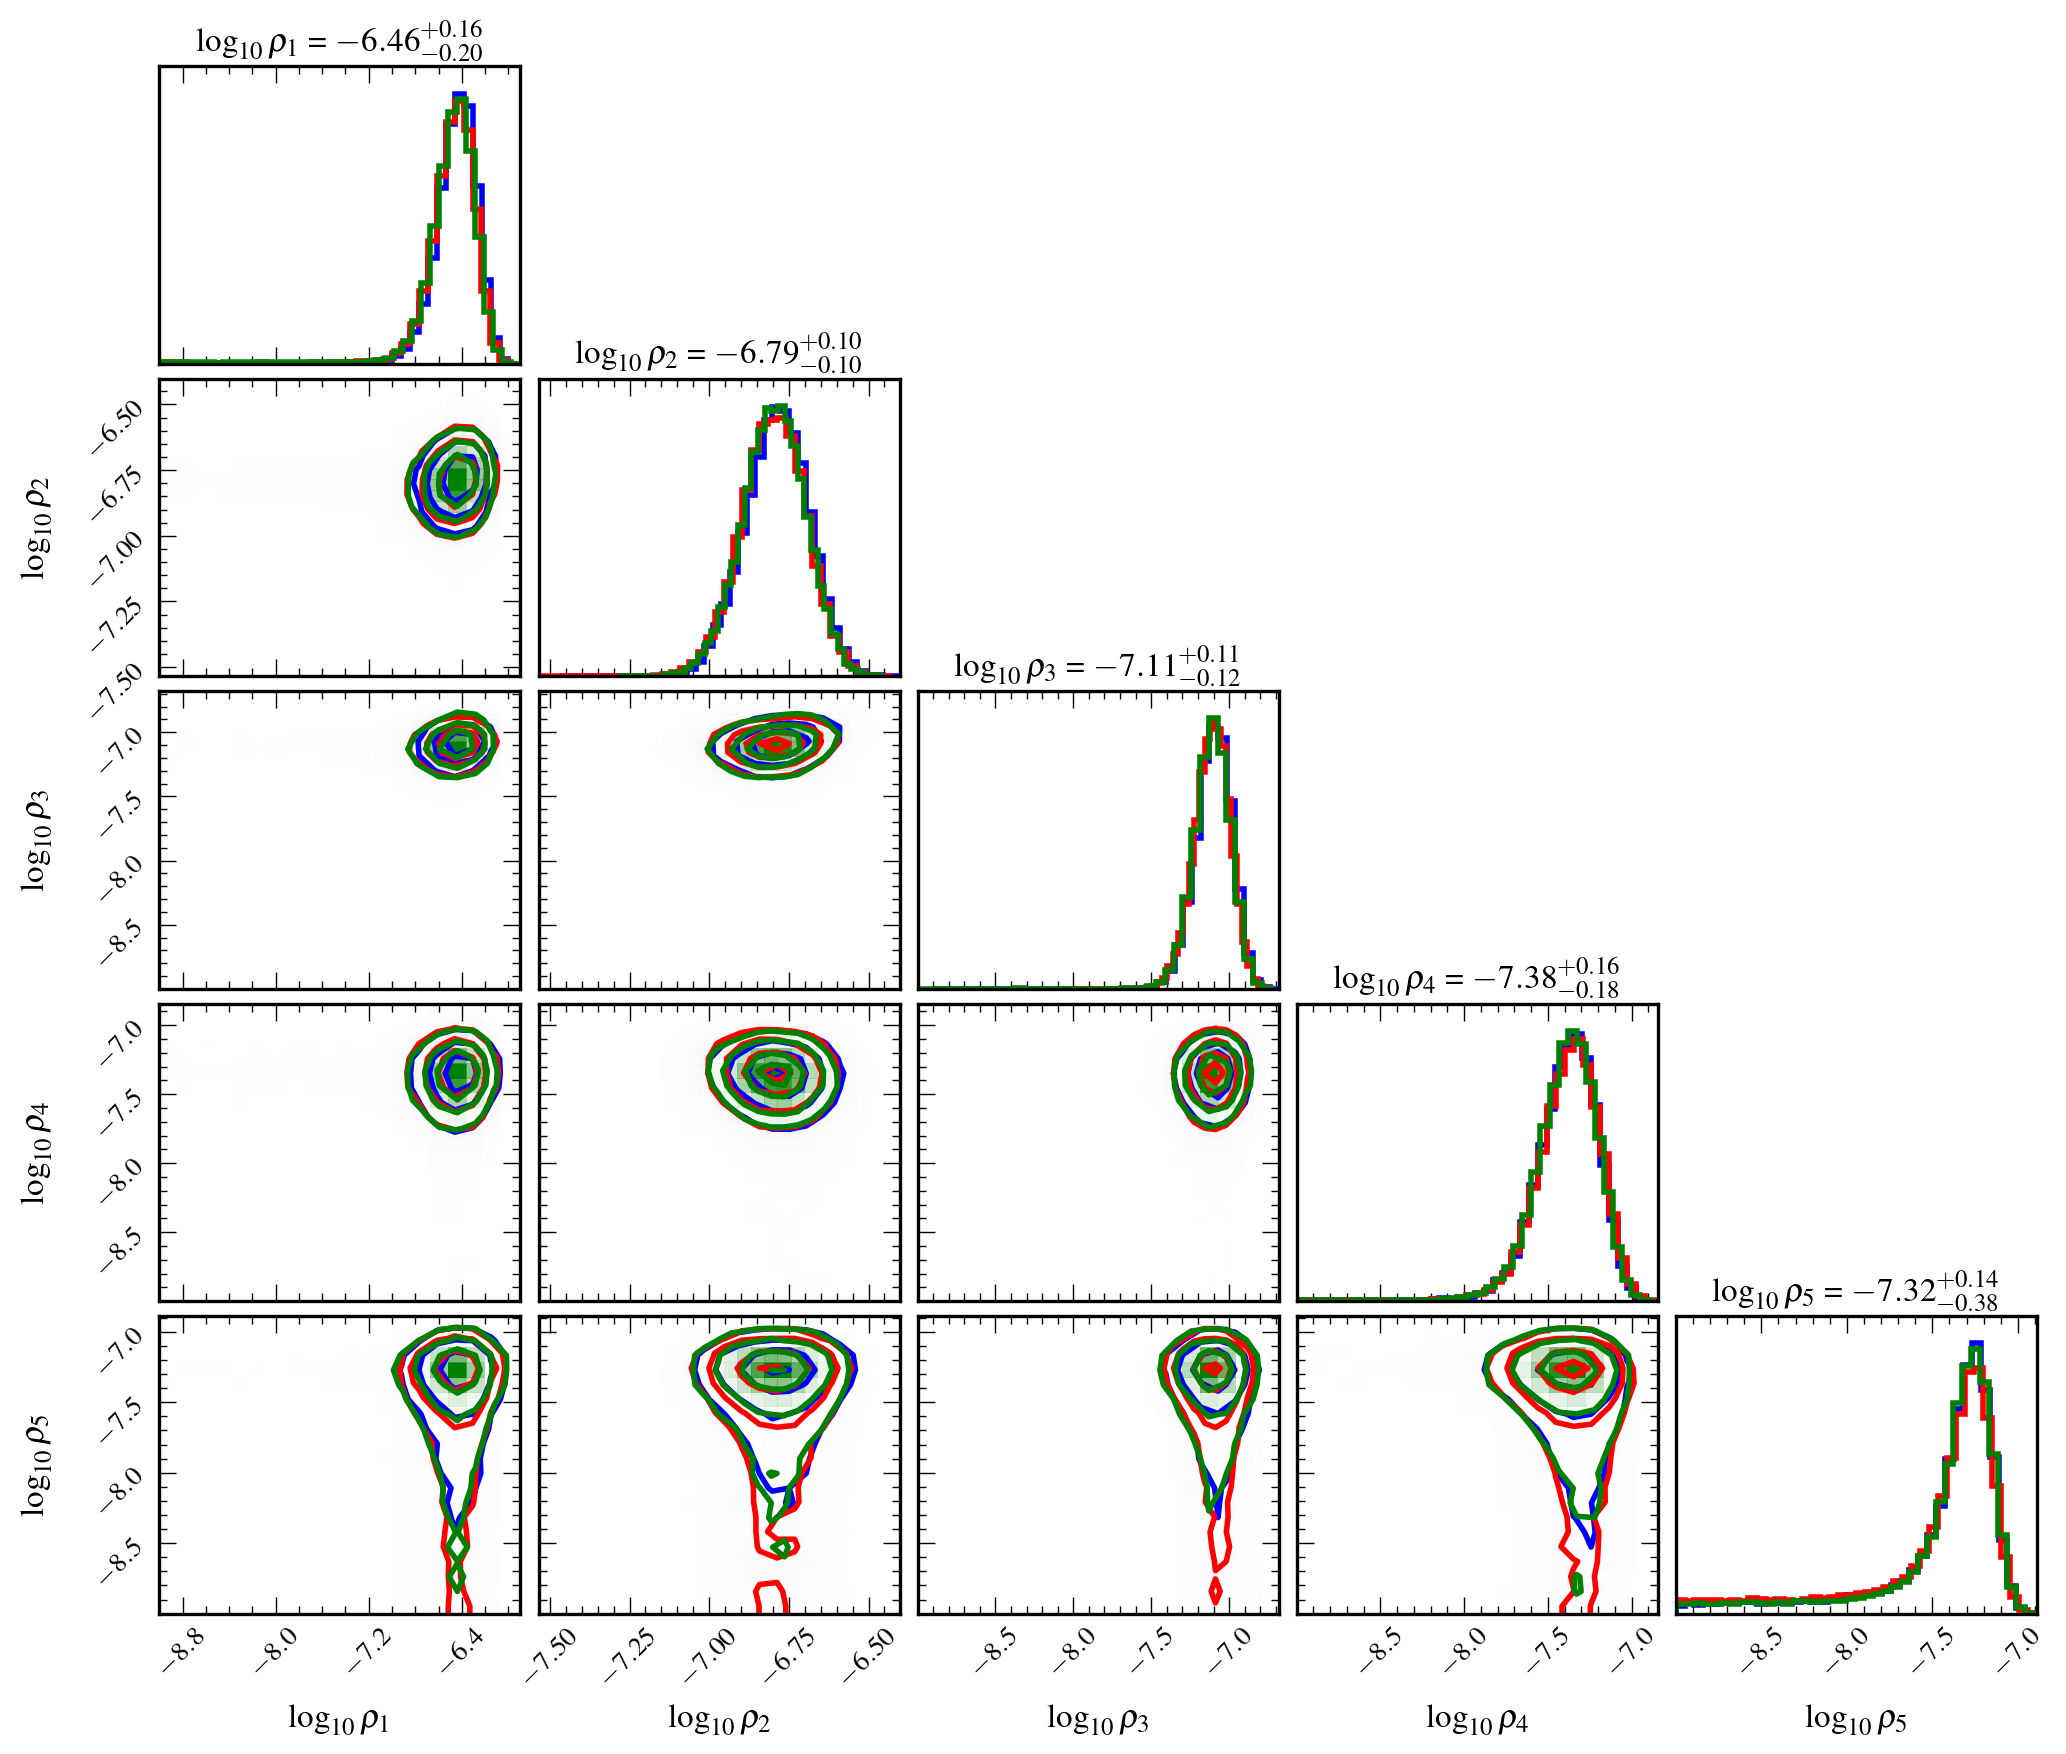

In [22]:
labels = [r'$\log_{{{0}}}\rho_{{{1}}}$'.format(10, _+1) for _ in range(5)]
fig = plt.figure(figsize=figsize(0.5, 3, 4))
fig = corner.corner(chain_ent[:, -crn_bins:], fig = fig, color='blue', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)
fig = corner.corner(chain_pan[:, -crn_bins:], fig = fig, color='red', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)

fig = corner.corner(chain_pan_ss[:, -crn_bins:], fig = fig, color='green', bins=20, hist_bin_factor=2, data_kwargs={'ms':3}, hist_kwargs={'density': True, 'lw':2}, 
                    contour_kwargs={'linewidths':2}, labels = labels,show_titles = True,
            truth_color = 'red', desity = True, plot_datapoints = False)

plt.show()

In [32]:
def Hellinger(p, q):
    diff = np.sqrt(p) - np.sqrt(q)
    return 1/np.sqrt(2) * np.sqrt(np.sum(diff**2, axis = 0))

In [44]:
h = []
for fidx in range(crn_bins):
            
        vh1, be = np.histogram(chain_ent[:, -crn_bins + fidx], 
                                density = False, bins = 20)
        vh0, _ = np.histogram(chain_pan[:, -crn_bins + fidx],
                                density = False, bins = be)
        
        h.append(Hellinger(vh1/vh1.sum(), vh0/vh0.sum()))

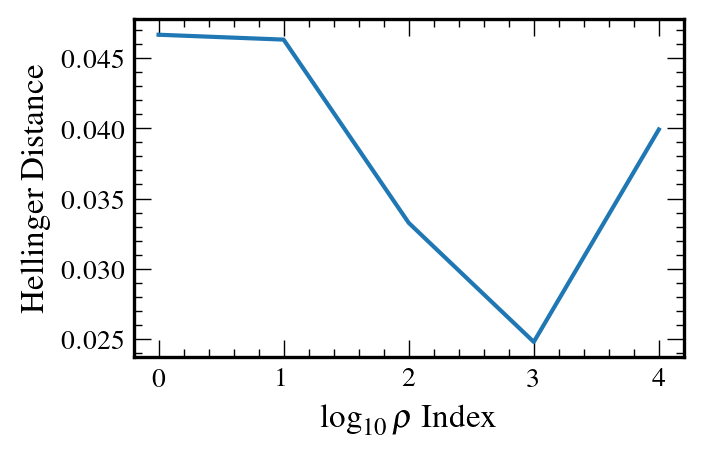

In [45]:
plt.plot(h)
plt.ylabel('Hellinger Distance')
plt.xlabel(r'$\log_{10}{\rho}$' + ' Index')
plt.show()

In [46]:
max(h)

0.04666367481521061